<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Web Scraping and Salary Prediction

<br/><br/>

This project was completed during my Data Science Immersive bootcamp at General Assembly in London.

The project aims to determine the industry factors that are most important in predicting the salary amounts in various data related fields.  
To achieve this, I decided to collect and analyse data from a job aggregator website, Indeed.com.  
To limit the scope, it was suggested to *focus on data-related job postings*, e.g. data scientist, data analyst, research scientist, business intelligence, and any others relevant terms. In addition, I could decrease the scope by *limiting the search to a single region.*  



**Goals:**
- Scrape data from a job aggregation tool in order to collect the data to best answer the initial question.
- Discover which job features impact salary the most.
- Create a classification model to predict whether a job will pay more or less than the median salary, based on the features of the job.  

<br/><br/>

### Factors that impact salary

To predict salary the most appropriate approach would be a regression model.
Here instead I just want to estimate which factors (like location, job title, job level, industry sector) lead to high or low salary and work with a classification model. To do so, I'll split the salary into two groups of high and low salary, by choosing the median salary as a threshold (in principle I could choose any single or multiple splitting points).  

<br/><br/>

## Libraries Import  

<br/><br/>

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
from tqdm import tqdm
import re

In [2]:
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from time import time, sleep

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

plt.style.use('fivethirtyeight')
sns.set(font_scale=1)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [4]:
# run to avoid warnings
import warnings
warnings.filterwarnings('ignore')

## Data Extraction  

<br/><br/>

### Functions to extract job details: title, company, location, salary....

In [5]:
# Job Title
def get_job_title(cards):
    job_title = []
    try:
        jt = card.find('h2', class_='jobTitle').text.strip('\\\n ')
    except:
        jt = 'Not Available'
    job_title.append(jt)
    return job_title

# Company Name
def get_company_name(cards):
    company_name = []
    try:
        cn = card.find('span', class_='companyName').text.strip('\\\n ')
    except:
        cn = 'Not Available'
    company_name.append(cn)
    return company_name

# Company Rating
def get_company_rating(cards):
    company_rating = []
    try:
        cr = card.find('span', class_='ratingNumber').text.strip('\\\n ')
    except Exception as e:
        cr = 'Not Available'
    company_rating.append(cr)
    return company_rating

# Company Location
def get_company_location(cards):
    company_location = []
    cl = card.find('div', class_='companyLocation').text.strip('\\\n ')
    cl = re.sub('\\\\\\n\s*', ' ', cl)
    cl = re.sub('\xa0', ' ', cl)
    company_location.append(cl)
    return company_location

# Salary Amount
def get_salary_amount(cards):
    salary_amount = []
    try:
        sa = card.find('div', class_='salary-snippet-container').text.strip('\\\n ')
    except:
        sa = 'Not Available'
    salary_amount.append(sa)
    return salary_amount

# Salary Estimate
def get_salary_estimate(cards):
    salary_estimate = []
    try:
        se = card.find('span', class_='estimated-salary').text.strip('\\\n ')
    except:
        se = 'Not Available'
    salary_estimate.append(se)
    return salary_estimate

# Multi Candidate
def get_multi_candidate(cards):
    multi_candidate = []
    try:
        mc = card.find('div', class_='hiringMultipleCandidatesCaption').text.strip('\\\n ')
    except:
        mc = 'Not Available'
    multi_candidate.append(mc)
    return multi_candidate

# Job Snippet
def get_job_snippet(cards):
    job_snippet = []
    try:
        js = card.find('div', class_='job-snippet').text.strip('\\\n ')
        js = re.sub('\\\\\\n\s*', ' ', js)
        js = re.sub('\\n', ' ', js)
    except:
        js = 'Not Available'
    job_snippet.append(js)
    return job_snippet

### Code to scrape Indeed.com website 

#### FIRST SCRAPE: looking at major US cities retrieving a small number of results

In [5]:
### DO NOT RUN THIS CELL!


max_results_per_city = 30

# Creating an empty dataframe
results = pd.DataFrame(columns = ['job_title',
                                  'company_name',
                                  'company_rating',
                                  'company_location',
                                  'salary_amount',
                                  'salary_estimate',
                                  'multi_candidate',
                                  'job_snippet'])

# Launching Chrome
dr = webdriver.Chrome()

# Iterating over each job role and each city, scraping the first 3 pages of search results
for role in set(['data+analyst', 'research+scientist', 'business+intelligence',
                 'machine+learning', 'data+engineer', 'statistician',
                 'data+consultant', 'cloud+engineer', 'natural+language+processing',
                 'quantitative+researcher']):

    for city in set(['Albuquerque', 'Atlanta', 'Austin', 'Baltimore', 'Boston', 'Charlotte',
                     'Chicago', 'Cincinnati', 'Cleveland', 'Columbus', 'Dallas',
                     'Denver', 'Detroit', 'Houston', 'Kansas+City', 'Los+Angeles',
                     'Menlo+Park', 'Miami', 'Minneapolis', 'Nashville', 'New+Orleans',
                     'New+York', 'Orlando', 'Palo+Alto', 'Philadelphia', 'Phoenix',
                     'Pittsburgh', 'Portland', 'Raleigh+Durham', 'Salt+Lake+City', 'San+Antonio',
                     'San+Diego', 'San+Francisco', 'San+Jose', 'Seattle', 'St+Louis',
                     'Tampa', 'Washington']):
        
        for start in range(0, max_results_per_city, 10):
            URL = f'http://www.indeed.com/jobs?q={role}&l={city}&start={start}'
        
            # Going to the URL
            dr.get(URL)
        
            html = dr.page_source
        
            soup = BeautifulSoup(html, 'html.parser')
            
            # Getting data from a page
            page_df = pd.DataFrame(columns = ['job_title',
                                              'company_name',
                                              'company_rating',
                                              'company_location',
                                              'salary_amount',
                                              'salary_estimate',
                                              'multi_candidate',
                                              'job_snippet'])

            # Getting all cards
            cards = soup.find_all('div', class_='cardOutline')
            
            # Iterating over each card, extracting info and combining into a row for the page
            for index, card in enumerate(cards):
                record = [get_job_title(cards[card]),
                          get_company_name(cards[card]),
                          get_company_rating(cards[card]),
                          get_company_location(cards[card]),
                          get_salary_amount(cards[card]),
                          get_salary_estimate(cards[card]),
                          get_multi_candidate(cards[card]),
                          get_job_snippet(cards[card])]
                          
                page_df.loc[len(page.df.index)] = record
                          
            # Concatenating the page to the main dataframe        
            results = pd.concat([results, page_df])
            
            sleep(3)

results.reset_index(inplace=True)

# Closing Chrome
dr.quit()

In [132]:
# Saving the scraping results as CSV
results.to_csv('datasets/scrape/results_scrape.csv', encoding='utf-8', index=False)

In [4]:
# Loading the data from CSV for consistency reasons
results_m = pd.read_csv('datasets/scrape/results_scrape.csv')

In [5]:
results_m.head(17)

index                                          job_title  \
0       0                         Student Research Assistant   
1       1                             Data Scientist Manager   
2       2                             Data Scientist, Senior   
3       3                      Solution Architecture Manager   
4       4                 Manager, Cognitive and AI - Remote   
5       5                             Software Engineer (JR)   
6       6                               Data Science Manager   
7       7  Software Engineer, Manager - Tax Analysis & De...   
8       8  Lead Software Engineer, Tax Analysis & Debt In...   
9       9                              Sr. Software Engineer   
10     10  Senior Software Engineer, Backend (Speech to T...   
11     11  Senior / Staff NLP Engineer (Speech to Text St...   
12     12                               Senior Data Engineer   
13     13                  Principal Data Engineer (Pre-IPO)   
14     14                   Senior Machine Learning Engineer   
15      0                         Student Research Assistant   
16      1                             Data Scientist Manager   

                                company_name company_rating  \
0                   University of New Mexico            4.0   
1                                   Deloitte            3.9   
2                        Booz Allen Hamilton            3.9   
3                                   Deloitte            3.9   
4                                       KPMG            3.9   
5   Alaka`ina Foundation Family of Companies            3.3   
6   Alaka`ina Foundation Family of Companies            3.3   
7                                   Deloitte            3.9   
8                                   Deloitte            3.9   
9   Alaka`ina Foundation Family of Companies            3.3   
10                   Recruiting From Scratch  Not Available   
11                   Recruiting From Scratch  Not Available   
12                   Recruiting From Scratch  Not Available   
13                   Recruiting From Scratch  Not Available   
14                   Recruiting From Scratch  Not Available   
15                  University of New Mexico            4.0   
16                                  Deloitte            3.9   

                               company_location               salary_amount  \
0   Albuquerque, NM 87106 (University Hts area)                 $16 an hour   
1         Albuquerque, NM 87102 (Downtown area)               Not Available   
2                    Remote in Kirtland AFB, NM               Not Available   
3         Albuquerque, NM 87102 (Downtown area)               Not Available   
4               Remote in Albuquerque, NM 87110               Not Available   
5                              Kirtland AFB, NM               Not Available   
6                              Kirtland AFB, NM               Not Available   
7         Albuquerque, NM 87102 (Downtown area)               Not Available   
8         Albuquerque, NM 87102 (Downtown area)               Not Available   
9                              Kirtland AFB, NM               Not Available   
10              Remote in Albuquerque, NM 87105  $150,000 - $230,000 a year   
11              Remote in Albuquerque, NM 87105  $190,000 - $230,000 a year   
12              Remote in Albuquerque, NM 87105  $150,000 - $200,000 a year   
13              Remote in Albuquerque, NM 87105  $150,000 - $200,000 a year   
14  Remote in Albuquerque, NM 87105+2 locations  $150,000 - $200,000 a year   
15  Albuquerque, NM 87106 (University Hts area)                 $16 an hour   
16        Albuquerque, NM 87102 (Downtown area)               Not Available   

                    salary_estimate multi_candidate  \
0                     Not Available   Not Available   
1    Estimated $178K - $225K a year   Not Available   
2   Estimated $95.2K - $121K a year   Not Available   
3    Estimated $179K - $227K a year   Not Available   
4    Estimated $12

In [6]:
results_m.shape

(15755, 9)

In [7]:
results_m.drop(columns='index', inplace=True)

In [8]:
results_m.shape

(15755, 8)

In [9]:
# Removing duplicate entries
results_m.drop_duplicates(keep='first', inplace=True, ignore_index=False)

In [10]:
results_m.shape

(13599, 8)

In [11]:
results_m.salary_amount.value_counts()

Not Available                 10420
$150,000 - $200,000 a year       60
$82,100 - $146,900 a year        45
$90,000 - $110,000 a year        43
$66,100 - $118,300 a year        29
                              ...  
$52,650 - $90,000 a year          1
$110,000 - $120,000 a year        1
$160,130 - $268,093 a year        1
$100,000 - $350,000 a year        1
$42,596 - $49,310 a year          1
Name: salary_amount, Length: 1810, dtype: int64

In [12]:
list(results_m.salary_amount.unique())

['$16 an hour',
 'Not Available',
 '$150,000 - $230,000 a year',
 '$190,000 - $230,000 a year',
 '$150,000 - $200,000 a year',
 '$275,000 - $400,000 a year',
 '$135,000 - $200,000 a year',
 '$90,000 a year',
 '$80,000 - $200,000 a year',
 '$135,000 - $155,000 a year',
 '$110,000 - $400,000 a year',
 '$183,000 - $208,000 a year',
 '$135,000 - $185,000 a year',
 '$100,000 - $140,000 a year',
 '$90,000 - $110,000 a year',
 '$70,000 - $130,000 a year',
 '$95,000 - $209,000 a year',
 '$58,955 - $74,991 a year',
 '$53,760 a year',
 '$85,000 - $170,400 a year',
 '$60,000 - $100,000 a year',
 '$18.00 - $20.55 an hour',
 '$60 - $70 an hour',
 '$100,000 - $160,000 a year',
 '$65 - $90 an hour',
 '$15 - $20 an hour',
 '$150,000 - $180,000 a year',
 '$110,000 - $140,000 a year',
 '$80,000 - $110,000 a year',
 '$65 a day',
 '$147,250 - $235,000 a year',
 '$126,700 - $145,000 a year',
 '$22.88 - $38.31 an hour',
 '$52.52 - $82.69 an hour',
 '$47,600 - $79,699 a year',
 '$36.49 - $62.52 an hour',
 '$

In [13]:
# Removing entries without salary amount information
results_m = results_m[results_m.salary_amount != 'Not Available']

In [14]:
results_m.shape

(3179, 8)

In [15]:
# Removing entries with salary amount refering to hour, day
results_m = results_m[~results_m.salary_amount.str.contains('hour')]
results_m = results_m[~results_m.salary_amount.str.contains('day')]
results_m.shape

(2765, 8)

In [193]:
# Saving the modified dataframe as CSV
results_m.to_csv('datasets/mod/results_m.csv', encoding='utf-8', index=False)

This initial dataset is slightly small for this exercise, I will increase the number of results trying a different approach.  
  
  
I am going to define 3 tiers for the US cities, based on the number of job postings.  
Tier 1 contains cities with more than 480 jobs for data scientist on Indeed.  
Tier 2 contains cities with a number of jobs between 120 and 480.  
Tier 3 contains cities with less than 120 jobs.  

<br/><br/>

#### SECOND SCRAPE: looking at major US cities with a tiered approach for retrieving results

##### Tier 1 cities

In [6]:
### DO NOT RUN THIS CELL!


us01_max_results_per_city = 320   # Multiple of 10. 10 = 1 step, 15 results for each step.
us02_max_results_per_city = 160 
us03_max_results_per_city = 40 

# Creating an empty dataframe
us01_res = pd.DataFrame(columns = ['job_title',
                                   'company_name',
                                   'company_rating',
                                   'company_location',
                                   'salary_amount',
                                   'salary_estimate',
                                   'multi_candidate',
                                   'job_snippet'])

# Launching Chrome
dr = webdriver.Chrome()

# Iterating over each job role and each tier 1 city, scraping the relative pages of search results
for role in set(['data+analyst', 'research+scientist', 'business+intelligence',
                 'machine+learning', 'data+engineer', 'statistician',
                 'data+consultant', 'cloud+engineer', 'natural+language+processing',
                 'quantitative+researcher']):

    for city in set(['Boston', 'Chicago', 'Menlo+Park', 'New+York', 'Palo+Alto',
                     'San+Francisco', 'San+Jose', 'Seattle', 'Washington']):
        
        for start in range(0, us01_max_results_per_city, 10):
            
            URL = f'http://www.indeed.com/jobs?q={role}&l={city}&start={start}'
            
            # Going to the URL
            dr.get(URL)
        
            html = dr.page_source
        
            soup = BeautifulSoup(html, 'html.parser')
            
            # Getting data from a page
            page_df = pd.DataFrame(columns = ['job_title',
                                              'company_name',
                                              'company_rating',
                                              'company_location',
                                              'salary_amount',
                                              'salary_estimate',
                                              'multi_candidate',
                                              'job_snippet'])

            # Getting all cards
            cards = soup.find_all('div', class_='cardOutline')
            
            # Iterating over each card, extracting info and combining into a row for the page
            for index, card in enumerate(cards):
                record = [get_job_title(cards[card]),
                          get_company_name(cards[card]),
                          get_company_rating(cards[card]),
                          get_company_location(cards[card]),
                          get_salary_amount(cards[card]),
                          get_salary_estimate(cards[card]),
                          get_multi_candidate(cards[card]),
                          get_job_snippet(cards[card])]
                          
                page_df.loc[len(page.df.index)] = record
                          
            # Concatenating the page to the main dataframe        
            us01_res = pd.concat([us01_res, page_df])

            sleep(3)
            
us01_res.reset_index(inplace=True)  

# Closing Chrome
dr.quit()

In [173]:
# Saving the scraping results as CSV
us01_res.to_csv('datasets/scrape/us01_res.csv', encoding='utf-8', index=False)

In [16]:
# Loading the data from CSV for consistency reasons
us01_m = pd.read_csv('datasets/scrape/us01_res.csv')

In [17]:
us01_m.head(17)

index                                          job_title  \
0       0  Machine Learning/Natural Language Processing R...   
1       1  Research Scientist, Natural Language Processin...   
2       2                  Vision-and-Language Understanding   
3       3        Member of Research Staff - Fujitsu Research   
4       4  Machine Learning Scientist (L5) - Programming ...   
5       5  AI/ML - Machine Learning Engineer and Scientis...   
6       6                                   Data Scientist I   
7       7  Linguistics Analyst- Text to Speech (TTS) Italian   
8       8                                     Data Scientist   
9       9  Research Scientist (L5) - Product Machine Lear...   
10     10  Research Scientist, Generative AI - New Colleg...   
11     11  Machine Learning Research Scientist - Natural ...   
12     12  AIML - Computer Vision Opportunities at Apple,...   
13     13           Machine Learning Scientist, Autopilot AI   
14     14  Research Scientist, Generative AI - New Colleg...   
15      0             Research Engineer: Vision and Language   
16      1                              NLP Program Assistant   

                           company_name company_rating  \
0                 Hitachi America, Ltd.            3.8   
1                             ByteDance            4.1   
2          Honda Research Institute USA  Not Available   
3                               Fujitsu            3.6   
4                               Netflix            3.9   
5                                 Apple            4.1   
6                        The Trade Desk            4.0   
7                             Accenture            4.0   
8                                  Uber            3.6   
9                               Netflix            3.9   
10                               NVIDIA            4.2   
11            Toyota Research Institute            3.8   
12                                Apple            4.1   
13                                Tesla            3.4   
14                      Oski Technology  Not Available   
15         Honda Research Institute USA  Not Available   
16  University of California Santa Cruz            4.3   

                                 company_location            salary_amount  \
0                           Santa Clara, CA 95054            Not Available   
1                   Mountain View, CA+6 locations            Not Available   
2                                    San Jose, CA            Not Available   
3          Sunnyvale, CA 94085 (East Murphy area)            Not Available   
4                        Los Gatos, CA+1 location            Not Available   
5                       Cupertino, CA+9 locations            Not Available   
6              San Jose, CA 95113 (Downtown area)            Not Available   
7   San Jose, CA 95113 (Downtown area)+1 location            Not Available   
8                             Sunnyvale, CA 94086            Not Available   
9                                   Los Gatos, CA            Not Available   
10                                Santa Clara, CA            Not Available   
11                            Los Altos, CA 94022            Not Available   
12                                  Cupertino, CA            Not Available   
13                       Palo Alto, CA+1 location            Not Available   
14                                Santa Clara, CA            Not Available   
15                                   San Jose, CA            Not Available   
16                          Santa Clara, CA 95054  $25.78 - $30.22 an hour   

                     salary_estimate             multi_candidate  \
0                      Not Available               Not Available   
1                      Not Available               Not Available   
2   Estimated $60.8K - $76.9K a year               Not Available   
3                      Not Available               Not Available   
4                      Not Available               Not Availa

In [18]:
us01_m.shape

(28628, 9)

In [19]:
us01_m.drop(columns='index', inplace=True)

In [20]:
# Removing duplicate entries
us01_m.drop_duplicates(keep='first', inplace=True, ignore_index=False)

In [21]:
us01_m.shape

(12520, 8)

In [22]:
# Removing entries without salary amount information
us01_m = us01_m[us01_m.salary_amount != 'Not Available']

In [23]:
us01_m.shape

(2639, 8)

In [24]:
# Removing entries with salary amount refering to hour, day
us01_m = us01_m[~us01_m.salary_amount.str.contains('hour')]
us01_m = us01_m[~us01_m.salary_amount.str.contains('day')]
us01_m.shape

(2380, 8)

In [203]:
# Saving the modified dataframe as CSV
us01_m.to_csv('datasets/mod/us01_m.csv', encoding='utf-8', index=False)

##### Tier 2 cities

In [7]:
### DO NOT RUN THIS CELL!


us01_max_results_per_city = 320   # Multiple of 10. 10 = 1 step, 15 results for each step.
us02_max_results_per_city = 160 
us03_max_results_per_city = 40 

# Creating an empty dataframe
us02_res = pd.DataFrame(columns = ['job_title',
                                   'company_name',
                                   'company_rating',
                                   'company_location',
                                   'salary_amount',
                                   'salary_estimate',
                                   'multi_candidate',
                                   'job_snippet'])

# Launching Chrome
dr = webdriver.Chrome()

# Iterating over each job role and each tier 2 city, scraping the relative pages of search results
for role in set(['data+analyst', 'research+scientist', 'business+intelligence',
                 'machine+learning', 'data+engineer', 'statistician',
                 'data+consultant', 'cloud+engineer', 'natural+language+processing',
                 'quantitative+researcher']):

    for city in set(['Atlanta', 'Austin', 'Baltimore', 'Dallas', 'Denver',
                     'Detroit', 'Houston' , 'Los+Angeles', 'Minneapolis', 'Philadelphia',
                     'Pittsburgh', 'Raleigh+Durham', 'San+Diego']):
        
        for start in range(0, us02_max_results_per_city, 10):
            
            URL = f'http://www.indeed.com/jobs?q={role}&l={city}&start={start}'
        
            # Going to the URL
            dr.get(URL)
        
            html = dr.page_source
        
            soup = BeautifulSoup(html, 'html.parser')
            
            # Getting data from a page
            page_df = pd.DataFrame(columns = ['job_title',
                                              'company_name',
                                              'company_rating',
                                              'company_location',
                                              'salary_amount',
                                              'salary_estimate',
                                              'multi_candidate',
                                              'job_snippet'])

            # Getting all cards
            cards = soup.find_all('div', class_='cardOutline')
            
            # Iterating over each card, extracting info and combining into a row for the page
            for index, card in enumerate(cards):
                record = [get_job_title(cards[card]),
                          get_company_name(cards[card]),
                          get_company_rating(cards[card]),
                          get_company_location(cards[card]),
                          get_salary_amount(cards[card]),
                          get_salary_estimate(cards[card]),
                          get_multi_candidate(cards[card]),
                          get_job_snippet(cards[card])]
                          
                page_df.loc[len(page.df.index)] = record
                          
            # Concatenating the page to the main dataframe
            us02_res = pd.concat([us02_res, page_df])

            sleep(3)

us02_res.reset_index(inplace=True)

# Closing Chrome
dr.quit()

In [204]:
# Saving the scraping results as CSV
us02_res.to_csv('datasets/scrape/us02_res.csv', encoding='utf-8', index=False)

In [25]:
# Loading the data from CSV for consistency reasons
us02_m = pd.read_csv('datasets/scrape/us02_res.csv')

In [26]:
us02_m.head(17)

index                                          job_title  \
0       0  Security Research Engineer (Full Time) United ...   
1       1                        Research Agreements Manager   
2       2                     Clinical Research Associate II   
3       3                           BTC - RESEARCH ASSOCIATE   
4       4                              Clinical Data Manager   
5       5         Staff Scientist I, Pre-Clinical Toxicology   
6       6  Regulatory Affairs Scientist - (Raleigh, NC or...   
7       7  DIRECTOR, DIVERSITY EQUITY AND INCLUSION - SAN...   
8       8           Senior Clinical Research Associate (CRA)   
9       9                        Lead Scientist, Team Leader   
10     10                             POSTDOCTORAL ASSOCIATE   
11     11  Research Technician I - Psychiatry - Beh Med D...   
12     12            Research Engineer-Biofuels Technologies   
13     13                                        Lab Manager   
14     14  Research Coordinator III - WPP Clinical Resear...   
15      0  Organic Research Chemist/Professional Intermed...   
16      1       Senior Design Research Operations Specialist   

                       company_name company_rating  \
0                     Cisco Systems            4.1   
1                   Duke University            4.0   
2                          Veristat            4.2   
3                   Duke University            4.0   
4                       MM Infotech  Not Available   
5                                BD            3.8   
6                          UCB S.A.            3.8   
7                   Duke University            4.0   
8                           Ergomed  Not Available   
9                          Catalent            3.1   
10                  Duke University            4.0   
11                  Duke University            4.0   
12                RTI International            3.7   
13  North Carolina State University            4.1   
14                          WakeMed            3.9   
15                           Jacobs            3.9   
16                 Truist Financial            3.6   

                              company_location  salary_amount salary_estimate  \
0         Remote in Research Triangle Park, NC  Not Available   Not Available   
1     Durham, NC 27710 (Duke West Campus area)  Not Available   Not Available   
2              Remote in Morrisville, NC 27560  Not Available   Not Available   
3     Durham, NC 27710 (Duke West Campus area)  Not Available   Not Available   
4                                   Durham, NC  Not Available   Not Available   
5                   Research Triangle Park, NC  Not Available   Not Available   
6   Raleigh, NC 27617 (Northwest Raleigh area)  Not Available   Not Available   
7     Durham, NC 27710 (Duke West Campus area)  Not Available   Not Available   
8                                  Raleigh, NC  Not Available   Not Available   
9                        Morrisville, NC 27560  Not Available   Not Available   
10    Durham, NC 27710 (Duke West Campus area)  Not Available   Not Available   
11    Durham, NC 27710 (Duke West Campus area)  Not Available   Not Available   
12                            Durham, NC 27709  Not Available   Not Available   
13                                 Raleigh, NC  Not Available   Not Available   
14                                 Raleigh, NC  Not Available   Not Available   
15                  Research Triangle Park, NC  Not Available   Not Available   
16          Raleigh, NC 27613 (Northwest area)  Not Available   Not Available   

   multi_candidate                                        job_snippet  
0    Not Available  US Citizenship is required due to the nature o...  
1    Not Available  Experience in a legal, human research protecti...  
2    Not Available  May provide input into the development of clin...  
3    Not Available  Contribute to supporting the clinical and tran...  
4    Not Available  Coordinates activities including: medic

In [27]:
us02_m.shape

(18579, 9)

In [28]:
us02_m.drop(columns='index', inplace=True)

In [29]:
# Removing duplicate entries
us02_m.drop_duplicates(keep='first', inplace=True, ignore_index=False)

In [30]:
us02_m.shape

(12041, 8)

In [31]:
# Removing entries without salary amount information
us02_m = us02_m[us02_m.salary_amount != 'Not Available']

In [32]:
us02_m.shape

(2485, 8)

In [33]:
# Removing entries with salary amount refering to hour, day
us02_m = us02_m[~us02_m.salary_amount.str.contains('hour')]
us02_m = us02_m[~us02_m.salary_amount.str.contains('day')]
us02_m.shape

(2220, 8)

In [214]:
# Saving the modified dataframe as CSV
us02_m.to_csv('datasets/mod/us02_m.csv', encoding='utf-8', index=False)

##### Tier 3 cities

In [8]:
### DO NOT RUN THIS CELL!


us01_max_results_per_city = 320   # Multiple of 10. 10 = 1 step, 15 results for each step.
us02_max_results_per_city = 160 
us03_max_results_per_city = 40 

# Creating an empty dataframe
us03_res = pd.DataFrame(columns = ['job_title',
                                   'company_name',
                                   'company_rating',
                                   'company_location',
                                   'salary_amount',
                                   'salary_estimate',
                                   'multi_candidate',
                                   'job_snippet'])

# Launching Chrome
dr = webdriver.Chrome()

# Iterating over each job role and each tier 3 city, scraping the relative pages of search results
for role in set(['data+analyst', 'research+scientist', 'business+intelligence',
                 'machine+learning', 'data+engineer', 'statistician',
                 'data+consultant', 'cloud+engineer', 'natural+language+processing',
                 'quantitative+researcher']):

    for city in set(['Albuquerque', 'Charlotte', 'Cincinnati', 'Cleveland', 'Columbus', 'Kansas+City',
                     'Miami', 'Nashville', 'New+Orleans', 'Orlando', 'Phoenix',
                     'Portland', 'Salt+Lake+City', 'San+Antonio', 'St+Louis', 'Tampa']):
        
        for start in range(0, us03_max_results_per_city, 10):
            
            URL = f'http://www.indeed.com/jobs?q={role}&l={city}&start={start}'
        
            # Going to the URL
            dr.get(URL)
        
            html = dr.page_source
        
            soup = BeautifulSoup(html, 'html.parser')
            
            # Getting data from a page
            page_df = pd.DataFrame(columns = ['job_title',
                                              'company_name',
                                              'company_rating',
                                              'company_location',
                                              'salary_amount',
                                              'salary_estimate',
                                              'multi_candidate',
                                              'job_snippet'])

            # Getting all cards
            cards = soup.find_all('div', class_='cardOutline')
            
            # Iterating over each card, extracting info and combining into a row for the page
            for index, card in enumerate(cards):
                record = [get_job_title(cards[card]),
                          get_company_name(cards[card]),
                          get_company_rating(cards[card]),
                          get_company_location(cards[card]),
                          get_salary_amount(cards[card]),
                          get_salary_estimate(cards[card]),
                          get_multi_candidate(cards[card]),
                          get_job_snippet(cards[card])]
                          
                page_df.loc[len(page.df.index)] = record
                          
            # Concatenating the page to the main dataframe
            us03_res = pd.concat([us03_res, page_df])

            sleep(3)

us03_res.reset_index(inplace=True)

# Closing Chrome
dr.quit()

In [215]:
# Saving the scraping results as CSV
us03_res.to_csv('datasets/scrape/us03_res.csv', encoding='utf-8', index=False)

In [34]:
# Loading the data from CSV for consistency reasons
us03_m = pd.read_csv('datasets/scrape/us03_res.csv')

In [35]:
us03_m.head(17)

index                                          job_title  \
0       0                         Student Research Assistant   
1       1                             Data Scientist Manager   
2       2                             Data Scientist, Senior   
3       3                      Solution Architecture Manager   
4       4                             Software Engineer (JR)   
5       5                 Manager, Cognitive and AI - Remote   
6       6  Software Engineer, Manager - Tax Analysis & De...   
7       7                               Data Science Manager   
8       8  Lead Software Engineer, Tax Analysis & Debt In...   
9       9                              Sr. Software Engineer   
10     10  Senior Software Engineer, Backend (Speech to T...   
11     11  Senior / Staff NLP Engineer (Speech to Text St...   
12     12                               Senior Data Engineer   
13     13                  Principal Data Engineer (Pre-IPO)   
14     14                   Senior Machine Learning Engineer   
15      0                         Student Research Assistant   
16      1                             Data Scientist Manager   

                                company_name company_rating  \
0                   University of New Mexico            4.0   
1                                   Deloitte            3.9   
2                        Booz Allen Hamilton            3.9   
3                                   Deloitte            3.9   
4   Alaka`ina Foundation Family of Companies            3.3   
5                                       KPMG            3.9   
6                                   Deloitte            3.9   
7   Alaka`ina Foundation Family of Companies            3.3   
8                                   Deloitte            3.9   
9   Alaka`ina Foundation Family of Companies            3.3   
10                   Recruiting From Scratch  Not Available   
11                   Recruiting From Scratch  Not Available   
12                   Recruiting From Scratch  Not Available   
13                   Recruiting From Scratch  Not Available   
14                   Recruiting From Scratch  Not Available   
15                  University of New Mexico            4.0   
16                                  Deloitte            3.9   

                               company_location               salary_amount  \
0   Albuquerque, NM 87106 (University Hts area)                 $16 an hour   
1         Albuquerque, NM 87102 (Downtown area)               Not Available   
2                    Remote in Kirtland AFB, NM               Not Available   
3         Albuquerque, NM 87102 (Downtown area)               Not Available   
4                              Kirtland AFB, NM               Not Available   
5               Remote in Albuquerque, NM 87110               Not Available   
6         Albuquerque, NM 87102 (Downtown area)               Not Available   
7                              Kirtland AFB, NM               Not Available   
8         Albuquerque, NM 87102 (Downtown area)               Not Available   
9                              Kirtland AFB, NM               Not Available   
10              Remote in Albuquerque, NM 87105  $150,000 - $230,000 a year   
11              Remote in Albuquerque, NM 87105  $190,000 - $230,000 a year   
12              Remote in Albuquerque, NM 87105  $150,000 - $200,000 a year   
13              Remote in Albuquerque, NM 87105  $150,000 - $200,000 a year   
14  Remote in Albuquerque, NM 87105+2 locations  $150,000 - $200,000 a year   
15  Albuquerque, NM 87106 (University Hts area)                 $16 an hour   
16        Albuquerque, NM 87102 (Downtown area)               Not Available   

                    salary_estimate multi_candidate  \
0                     Not Available   Not Available   
1    Estimated $178K - $225K a year   Not Available   
2   Estimated $95.2K - $121K a year   Not Available   
3    Estimated $179K - $227K a year   Not Available   
4    Estimated $10

In [36]:
us03_m.shape

(8162, 9)

In [37]:
us03_m.drop(columns='index', inplace=True)

In [38]:
# Removing duplicate entries
us03_m.drop_duplicates(keep='first', inplace=True, ignore_index=False)

In [39]:
us03_m.shape

(6857, 8)

In [40]:
# Removing entries without salary amount information
us03_m = us03_m[us03_m.salary_amount != 'Not Available']

In [41]:
us03_m.shape

(1419, 8)

In [42]:
# Removing entries with salary amount refering to hour, day
us03_m = us03_m[~us03_m.salary_amount.str.contains('hour')]
us03_m = us03_m[~us03_m.salary_amount.str.contains('day')]
us03_m.shape

(1137, 8)

In [225]:
# Saving the modified dataframe as CSV
us03_m.to_csv('datasets/mod/us03_m.csv', encoding='utf-8', index=False)

The datasets for the 3 tiers have a combined total of 5,737 entries after removing duplicates and unusable salary information.  
  
I am going to perform a final scraping, without using tiers but aiming at a larger number of results.  

<br/><br/>

#### FINAL SCRAPE: looking at major US cities retrieving a large number of results

In [9]:
### DO NOT RUN THIS CELL!


us_max_results_per_city = 600   # Set this to a high-value (5000) to generate more results.

# Creating an empty dataframe
us_res = pd.DataFrame(columns = ['job_title',
                                  'company_name',
                                  'company_rating',
                                  'company_location',
                                  'salary_amount',
                                  'salary_estimate',
                                  'multi_candidate',
                                  'job_snippet'])

# Launching Chrome
dr = webdriver.Chrome()

# Iterating over each job role and each city, scraping the first 60 pages of search results
for role in set(['data+analyst', 'research+scientist', 'business+intelligence',
                 'machine+learning', 'data+engineer', 'statistician',
                 'data+consultant', 'cloud+engineer', 'natural+language+processing',
                 'quantitative+researcher']):

    for city in set(['Atlanta', 'Austin', 'Baltimore', 'Boston', 'Charlotte',
                     'Chicago', 'Cincinnati', 'Cleveland', 'Columbus', 'Dallas',
                     'Denver', 'Detroit', 'Houston', 'Kansas+City', 'Los+Angeles',
                     'Menlo+Park', 'Miami', 'Minneapolis', 'Nashville', 'New+Orleans',
                     'New+York', 'Orlando', 'Palo+Alto', 'Philadelphia', 'Phoenix',
                     'Pittsburgh', 'Portland', 'Raleigh+Durham', 'Salt+Lake+City', 'San+Antonio',
                     'San+Diego', 'San+Francisco', 'San+Jose', 'Seattle', 'St+Louis',
                     'Tampa', 'Washington', YOUR_CITY]):
        
        for start in range(0, us_max_results_per_city, 10):
            
            URL = f'http://www.indeed.com/jobs?q={role}&l={city}&start={start}'
        
            # Going to the URL
            dr.get(URL)
        
            html = dr.page_source
        
            soup = BeautifulSoup(html, 'html.parser')
            
            # Getting data from a page
            page_df = pd.DataFrame(columns = ['job_title',
                                              'company_name',
                                              'company_rating',
                                              'company_location',
                                              'salary_amount',
                                              'salary_estimate',
                                              'multi_candidate',
                                              'job_snippet'])

            # Getting all cards
            cards = soup.find_all('div', class_='cardOutline')
            
            # Iterating over each card, extracting info and combining into a row for the page
            for index, card in enumerate(cards):
                record = [get_job_title(cards[card]),
                          get_company_name(cards[card]),
                          get_company_rating(cards[card]),
                          get_company_location(cards[card]),
                          get_salary_amount(cards[card]),
                          get_salary_estimate(cards[card]),
                          get_multi_candidate(cards[card]),
                          get_job_snippet(cards[card])]
                          
                page_df.loc[len(page.df.index)] = record
                          
            # Concatenating the page to the main dataframe
            us_res = pd.concat([us_res, page_df])
            
            sleep(3)

us_res.reset_index(inplace=True)

# Closing Chrome
dr.quit()

In [226]:
# Saving the scraping results as CSV
us_res.to_csv('datasets/scrape/us_res_scrape.csv', encoding='utf-8', index=False)

In [6]:
# Loading the data from CSV for consistency reasons
us_res_m = pd.read_csv('datasets/scrape/us_res_scrape.csv')

In [7]:
us_res_m.head(17)

index                                          job_title  \
0       0                         Student Research Assistant   
1       1                             Data Scientist Manager   
2       2                             Data Scientist, Senior   
3       3                      Solution Architecture Manager   
4       4                             Software Engineer (JR)   
5       5                 Manager, Cognitive and AI - Remote   
6       6  Software Engineer, Manager - Tax Analysis & De...   
7       7                               Data Science Manager   
8       8  Lead Software Engineer, Tax Analysis & Debt In...   
9       9                              Sr. Software Engineer   
10     10  Senior Software Engineer, Backend (Speech to T...   
11     11  Senior / Staff NLP Engineer (Speech to Text St...   
12     12                               Senior Data Engineer   
13     13                  Principal Data Engineer (Pre-IPO)   
14     14                   Senior Machine Learning Engineer   
15      0                         Student Research Assistant   
16      1                             Data Scientist Manager   

                                company_name company_rating  \
0                   University of New Mexico            4.0   
1                                   Deloitte            3.9   
2                        Booz Allen Hamilton            3.9   
3                                   Deloitte            3.9   
4   Alaka`ina Foundation Family of Companies            3.3   
5                                       KPMG            3.9   
6                                   Deloitte            3.9   
7   Alaka`ina Foundation Family of Companies            3.3   
8                                   Deloitte            3.9   
9   Alaka`ina Foundation Family of Companies            3.3   
10                   Recruiting From Scratch  Not Available   
11                   Recruiting From Scratch  Not Available   
12                   Recruiting From Scratch  Not Available   
13                   Recruiting From Scratch  Not Available   
14                   Recruiting From Scratch  Not Available   
15                  University of New Mexico            4.0   
16                                  Deloitte            3.9   

                               company_location               salary_amount  \
0   Albuquerque, NM 87106 (University Hts area)                 $16 an hour   
1         Albuquerque, NM 87102 (Downtown area)               Not Available   
2                    Remote in Kirtland AFB, NM               Not Available   
3         Albuquerque, NM 87102 (Downtown area)               Not Available   
4                              Kirtland AFB, NM               Not Available   
5               Remote in Albuquerque, NM 87110               Not Available   
6         Albuquerque, NM 87102 (Downtown area)               Not Available   
7                              Kirtland AFB, NM               Not Available   
8         Albuquerque, NM 87102 (Downtown area)               Not Available   
9                              Kirtland AFB, NM               Not Available   
10              Remote in Albuquerque, NM 87105  $150,000 - $230,000 a year   
11              Remote in Albuquerque, NM 87105  $190,000 - $230,000 a year   
12              Remote in Albuquerque, NM 87105  $150,000 - $200,000 a year   
13              Remote in Albuquerque, NM 87105  $150,000 - $200,000 a year   
14  Remote in Albuquerque, NM 87105+2 locations  $150,000 - $200,000 a year   
15  Albuquerque, NM 87106 (University Hts area)                 $16 an hour   
16        Albuquerque, NM 87102 (Downtown area)               Not Available   

                    salary_estimate multi_candidate  \
0                     Not Available   Not Available   
1    Estimated $178K - $225K a year   Not Available   
2   Estimated $95.2K - $121K a year   Not Available   
3    Estimated $179K - $227K a year   Not Available   
4    Estimated $10

In [8]:
us_res_m.shape

(239439, 9)

In [9]:
# Dropping the index column
us_res_m.drop(columns='index', inplace=True)

In [10]:
us_res_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239439 entries, 0 to 239438
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   job_title         239439 non-null  object
 1   company_name      239439 non-null  object
 2   company_rating    239439 non-null  object
 3   company_location  239439 non-null  object
 4   salary_amount     239439 non-null  object
 5   salary_estimate   239439 non-null  object
 6   multi_candidate   239439 non-null  object
 7   job_snippet       239439 non-null  object
dtypes: object(8)
memory usage: 14.6+ MB


In [11]:
us_res_m.shape

(239439, 8)

## Data Cleaning and Processing  

<br/><br/>

In [12]:
# Removing duplicate entries
us_res_m.drop_duplicates(keep='first', inplace=True, ignore_index=False)

In [13]:
us_res_m.shape

(79545, 8)

In [14]:
# Checking the salary amount column
us_res_m.salary_amount.value_counts()

Not Available                               63713
$150,000 - $200,000 a year Employer est.      246
$150,000 - $200,000 a year                    142
$150,000 - $220,000 a year Employer est.       90
$82,100 - $146,900 a year Employer est.        81
                                            ...  
$38 - $42 an hour Employer est.                 1
$51 - $54 an hour Employer est.                 1
$57,288 - $103,044 a year Employer est.         1
$87,570 - $162,540 a year Employer est.         1
$59,000 - $84,000 a year Employer est.          1
Name: salary_amount, Length: 6336, dtype: int64

In [15]:
# Removing entries without salary amount information
us_res_m = us_res_m[us_res_m.salary_amount != 'Not Available']

In [16]:
us_res_m.shape

(15832, 8)

In [17]:
list(us_res_m.salary_amount.unique())

['$16 an hour',
 '$150,000 - $230,000 a year',
 '$190,000 - $230,000 a year',
 '$150,000 - $200,000 a year',
 '$275,000 - $400,000 a year',
 '$135,000 - $200,000 a year',
 '$80,000 - $200,000 a year',
 '$90,000 a year',
 '$135,000 - $155,000 a year',
 '$183,000 - $208,000 a year',
 '$135,000 - $185,000 a year',
 '$110,000 - $400,000 a year',
 '$100,000 - $140,000 a year',
 '$95,000 - $209,000 a year',
 '$90,000 - $110,000 a year',
 '$70,000 - $130,000 a year',
 '$115,800 - $231,600 a year',
 '$58,955 - $74,991 a year',
 '$53,760 a year',
 '$85,000 - $170,400 a year',
 '$60,000 - $100,000 a year',
 '$18.00 - $20.55 an hour',
 '$60 - $70 an hour',
 '$100,000 - $160,000 a year',
 '$65 - $90 an hour',
 '$15 - $20 an hour',
 '$150,000 - $180,000 a year',
 '$110,000 - $140,000 a year',
 '$80,000 - $110,000 a year',
 '$65 a day',
 '$147,250 - $235,000 a year',
 '$126,700 - $145,000 a year',
 '$187,800 - $293,400 a year',
 '$142,500 - $200,000 a year',
 '$100,000 - $130,000 a year',
 '$69,471 

Salary information related to hour or day are usually for contractor jobs and not reliable.  
I am going to drop the entries containing those, keeping only yearly and monthly values.  

<br/><br/>

In [18]:
# Removing entries with salary amount refering to hour, day
us_res_m = us_res_m[~us_res_m.salary_amount.str.contains('hour')]
us_res_m = us_res_m[~us_res_m.salary_amount.str.contains('day')]
us_res_m.reset_index(drop=True, inplace=True)
us_res_m.shape

(13405, 8)

In [19]:
# Saving the modified dataframe as CSV
us_res_m.to_csv('datasets/mod/us_res_m.csv', encoding='utf-8', index=False)

In [20]:
# Loading the data from CSV for consistency reasons
us_fin = pd.read_csv('datasets/mod/us_res_m.csv')

In [21]:
list(us_fin.company_name.unique())

['Recruiting From Scratch',
 'University of Colorado',
 'The Stratagem Group, Inc',
 'Grey Matters Defense Solutions',
 'Pearson',
 'University of Colorado Boulder',
 'S&P Global',
 'CVS Health',
 'The Trade Desk',
 'Josh.ai',
 'Kore.ai, Inc',
 'TalentTECH',
 'JPMorgan Chase Bank, N.A.',
 'AT&T',
 'Vizient, Inc.',
 'DiamondPick',
 'okaya inc',
 'Okaya infocom',
 'Larsen and Toubro (L&T)',
 'Stanley David and Associates',
 'Emonics',
 'bhanu.c@sdnaglobal.com',
 'proit-inc',
 'ProIT Inc.',
 'University of Utah',
 'The JAAW Group',
 'Stefanini, Inc',
 'Sun Life',
 'American Century Investments',
 'sourcemantra',
 'Dentsu Media',
 'UnitedHealth Group',
 'Remesh',
 'Discord',
 'Gainwell Technologies LLC',
 'Brave',
 'Harvey',
 'Tubi',
 'Airbnb',
 'Sia Partners',
 'Adept AI',
 'Ask Media Group',
 'Suki.ai',
 'Baptist Health South Florida',
 'Key Lime Interactive LLC',
 'Loon',
 'Oski Technology',
 'NVIDIA',
 'IBM',
 'Microsoft',
 'Just Appraised',
 'swiftlysiri',
 'Logic20/20 Inc.',
 'Pfizer

In [22]:
len(list(us_fin.company_name.unique()))

4105

There are more than 4,000 different companies in the dataset.  
It seems very unlikely that the company name could be a reliable predictor for the salary, but I will keep the column.  

<br/><br/>

In [23]:
list(us_fin.company_location.unique())

['Remote in Albuquerque, NM 87105',
 'Remote in Albuquerque, NM 87105+2 locations',
 'Aurora, CO',
 'Aurora, CO 80011 (Norfolk Glen area)',
 'Boulder, CO 80305 (Central Boulder area)',
 'Remote in Boulder, CO 80305',
 'Boulder, CO 80309 (Colorado University area)',
 'Remote in Denver, CO 80201',
 'Denver, CO',
 'Denver, CO 80201',
 'Remote in Littleton, CO 80123+2 locations',
 'Remote in Denver, CO 80123+2 locations',
 'Remote in Littleton, CO 80123+8 locations',
 'Remote in Boulder, CO 80305+2 locations',
 'Orlando, FL 32819 (Florida Center area)',
 'Remote in Orlando, FL',
 'Plano, TX',
 'Irving, TX 75062 (Las Colinas Urban Center area)',
 'Dallas, TX',
 'Plano, TX+2 locations',
 'Irving, TX 75038 (Cottonwood area)',
 'Irving, TX 75062 (McArthur area)',
 'Irving, TX',
 'Remote in Dallas, TX 75205+2 locations',
 'Remote in Dallas, TX 75205+1 location',
 'Irving, TX 75039 (Las Colinas Urban Center area)',
 'Irving, TX 75060',
 'Dallas, TX 75204 (Deep Ellum area)',
 'Remote in Dallas, T

In [24]:
len(list(us_fin.company_location.unique()))

4321

There are more than 4,000 different locations in the dataset.  
It is very unlikely that the company location in its current format could represent a reliable predictor for the salary, but I can use the column data to create four new columns while removing local information.  
I am going to create one column containing the company state and another one containing the city.  
In addition, I am going to use location information to create one column which indicates if the job has multiple locations, and another one about work arrangement (Hybryd, Remote, On-site) with the assumption that the job will be on-site if nothing is specified in the description.

<br/><br/>

In [25]:
us_fin['company_state'] = us_fin['company_location']

In [26]:
us_fin.head()

job_title             company_name  \
0  Senior Software Engineer, Backend (Speech to T...  Recruiting From Scratch   
1  Senior / Staff NLP Engineer (Speech to Text St...  Recruiting From Scratch   
2                               Senior Data Engineer  Recruiting From Scratch   
3                  Principal Data Engineer (Pre-IPO)  Recruiting From Scratch   
4                   Senior Machine Learning Engineer  Recruiting From Scratch   

  company_rating                             company_location  \
0  Not Available              Remote in Albuquerque, NM 87105   
1  Not Available              Remote in Albuquerque, NM 87105   
2  Not Available              Remote in Albuquerque, NM 87105   
3  Not Available              Remote in Albuquerque, NM 87105   
4  Not Available  Remote in Albuquerque, NM 87105+2 locations   

                salary_amount salary_estimate multi_candidate  \
0  $150,000 - $230,000 a year   Not Available   Not Available   
1  $190,000 - $230,000 a year   Not Available   Not Available   
2  $150,000 - $200,000 a year   Not Available   Not Available   
3  $150,000 - $200,000 a year   Not Available   Not Available   
4  $150,000 - $200,000 a year   Not Available   Not Available   

                                         job_snippet  \
0  Their AI-powered collaborative note-taking app...   
1  Members of the technology team work as a group...   
2  Knowledge in at least one of following areas -...   
3  Knowledge in at least one of following areas -...   
4  Knowledge in at least one of following areas -...   

                                 company_state  
0              Remote in Albuquerque, NM 87105  
1              Remote in Albuquerque, NM 87105  
2              Remote in Albuquerque, NM 87105  
3              Remote in Albuquerque, NM 87105  
4  Remote in Albuquerque, NM 87105+2 locations

In [27]:
def clean_location(location):
    location = re.findall(r'[A-Z]{2}', location)
    location = str(location)
    location = location[2:4]
    return location

In [28]:
# Testing the function. It works
print(clean_location('Remote in Albuquerque, NM 87105'))
print(clean_location('Remote in Littleton, CO 80123+2 locations'))
print(clean_location('Orlando, FL 32819 (Florida Center area)'))
print(clean_location('Plano, TX'))

NM
CO
FL
TX


In [29]:
# Applying the function to the location column
us_fin['company_state'] = us_fin['company_state'].map(clean_location)

In [30]:
us_fin.head()

job_title             company_name  \
0  Senior Software Engineer, Backend (Speech to T...  Recruiting From Scratch   
1  Senior / Staff NLP Engineer (Speech to Text St...  Recruiting From Scratch   
2                               Senior Data Engineer  Recruiting From Scratch   
3                  Principal Data Engineer (Pre-IPO)  Recruiting From Scratch   
4                   Senior Machine Learning Engineer  Recruiting From Scratch   

  company_rating                             company_location  \
0  Not Available              Remote in Albuquerque, NM 87105   
1  Not Available              Remote in Albuquerque, NM 87105   
2  Not Available              Remote in Albuquerque, NM 87105   
3  Not Available              Remote in Albuquerque, NM 87105   
4  Not Available  Remote in Albuquerque, NM 87105+2 locations   

                salary_amount salary_estimate multi_candidate  \
0  $150,000 - $230,000 a year   Not Available   Not Available   
1  $190,000 - $230,000 a year   Not Available   Not Available   
2  $150,000 - $200,000 a year   Not Available   Not Available   
3  $150,000 - $200,000 a year   Not Available   Not Available   
4  $150,000 - $200,000 a year   Not Available   Not Available   

                                         job_snippet company_state  
0  Their AI-powered collaborative note-taking app...            NM  
1  Members of the technology team work as a group...            NM  
2  Knowledge in at least one of following areas -...            NM  
3  Knowledge in at least one of following areas -...            NM  
4  Knowledge in at least one of following areas -...            NM

In [31]:
us_fin.company_state.isnull().sum()

0

In [32]:
us_fin.company_state.unique()

array(['NM', 'CO', 'FL', 'TX', 'UT', 'MI', 'MO', 'KS', 'CA', 'GA', 'MA',
       'MD', 'OH', 'MN', 'AF', 'IL', 'NY', '', 'OR', 'WA', 'TN', 'NC',
       'PA', 'LA', 'AZ', 'NJ', 'DE', 'KY', 'SC', 'CT', 'IN', 'MC'],
      dtype=object)

In [33]:
# Creating a column for the company city/area
company_city = []
for x in us_fin['company_location']:
    try:
        city = re.search(r'(?<= in )(.*)(?=,)|(?<= in )(.*)(?=\+)|(?<= in )(.*)', x)
        company_city.append(city.group())
    except:
        try:
            city = re.search(r'^(.*)(?=,)|^(.*)(?=\+)', x)
            company_city.append(city.group())
        except:
            company_city.append(x)

In [34]:
# Inserting the new city column in the dataframe
us_fin.insert(4, 'company_city', company_city)

In [35]:
us_fin.head()

job_title             company_name  \
0  Senior Software Engineer, Backend (Speech to T...  Recruiting From Scratch   
1  Senior / Staff NLP Engineer (Speech to Text St...  Recruiting From Scratch   
2                               Senior Data Engineer  Recruiting From Scratch   
3                  Principal Data Engineer (Pre-IPO)  Recruiting From Scratch   
4                   Senior Machine Learning Engineer  Recruiting From Scratch   

  company_rating                             company_location company_city  \
0  Not Available              Remote in Albuquerque, NM 87105  Albuquerque   
1  Not Available              Remote in Albuquerque, NM 87105  Albuquerque   
2  Not Available              Remote in Albuquerque, NM 87105  Albuquerque   
3  Not Available              Remote in Albuquerque, NM 87105  Albuquerque   
4  Not Available  Remote in Albuquerque, NM 87105+2 locations  Albuquerque   

                salary_amount salary_estimate multi_candidate  \
0  $150,000 - $230,000 a year   Not Available   Not Available   
1  $190,000 - $230,000 a year   Not Available   Not Available   
2  $150,000 - $200,000 a year   Not Available   Not Available   
3  $150,000 - $200,000 a year   Not Available   Not Available   
4  $150,000 - $200,000 a year   Not Available   Not Available   

                                         job_snippet company_state  
0  Their AI-powered collaborative note-taking app...            NM  
1  Members of the technology team work as a group...            NM  
2  Knowledge in at least one of following areas -...            NM  
3  Knowledge in at least one of following areas -...            NM  
4  Knowledge in at least one of following areas -...            NM

In [36]:
# Creating a column for the number of additional locations
multi_location = []
for x in us_fin['company_location']:
    if re.search(r'\+\d locations?', x):
        multi_location.append(''.join(re.findall(r'\+(\d) locations?', x)))
    else:
        multi_location.append(0)

In [37]:
# Appending the column to the dataframe
us_fin['multi_location'] = multi_location

In [38]:
# Creating a column about work arrangement
work_arrangement = []
for x in us_fin['company_location']:
    if re.search("[Hh]ybrid [Rr]emote", x):
        work_arrangement.append("Hybrid")
    elif re.search("[Rr]emote", x):
        work_arrangement.append("Remote")
    else:
        work_arrangement.append("On-site")  

In [39]:
# Appending the column to the dataframe
us_fin['work_arrangement'] = work_arrangement

In [40]:
# Rearranging columns in the dataframe
column_to_move = us_fin.pop('company_state')
us_fin.insert(5, 'company_state', column_to_move)

column_to_move = us_fin.pop('job_snippet')
us_fin.insert(11, 'job_snippet', column_to_move)

In [41]:
us_fin.head()

job_title             company_name  \
0  Senior Software Engineer, Backend (Speech to T...  Recruiting From Scratch   
1  Senior / Staff NLP Engineer (Speech to Text St...  Recruiting From Scratch   
2                               Senior Data Engineer  Recruiting From Scratch   
3                  Principal Data Engineer (Pre-IPO)  Recruiting From Scratch   
4                   Senior Machine Learning Engineer  Recruiting From Scratch   

  company_rating                             company_location company_city  \
0  Not Available              Remote in Albuquerque, NM 87105  Albuquerque   
1  Not Available              Remote in Albuquerque, NM 87105  Albuquerque   
2  Not Available              Remote in Albuquerque, NM 87105  Albuquerque   
3  Not Available              Remote in Albuquerque, NM 87105  Albuquerque   
4  Not Available  Remote in Albuquerque, NM 87105+2 locations  Albuquerque   

  company_state               salary_amount salary_estimate multi_candidate  \
0            NM  $150,000 - $230,000 a year   Not Available   Not Available   
1            NM  $190,000 - $230,000 a year   Not Available   Not Available   
2            NM  $150,000 - $200,000 a year   Not Available   Not Available   
3            NM  $150,000 - $200,000 a year   Not Available   Not Available   
4            NM  $150,000 - $200,000 a year   Not Available   Not Available   

  multi_location work_arrangement  \
0              0           Remote   
1              0           Remote   
2              0           Remote   
3              0           Remote   
4              2           Remote   

                                         job_snippet  
0  Their AI-powered collaborative note-taking app...  
1  Members of the technology team work as a group...  
2  Knowledge in at least one of following areas -...  
3  Knowledge in at least one of following areas -...  
4  Knowledge in at least one of following areas -...

Salary is currently formatted as a string and is often presented as a range.  
I am going to convert it to a number, averaging the range if necessary.  

<br/><br/>

In [42]:
def clean_salary(salary):
    if 'month' in salary:
        salary = salary.replace(',', '')
        salary = re.findall(r'\d+', salary)
        salary = [int(i) for i in salary]
        salary = sum(salary) / len(salary)
        salary = salary * 12
    else:
        salary = salary.replace(',', '')
        salary = re.findall(r'\d+', salary)
        salary = [int(i) for i in salary]
        salary = sum(salary) / len(salary)
    return salary

In [43]:
# Testing the function. It works
print(clean_salary('$130,000 - $180,000 a year'))
print(clean_salary('$130,000 - $180,000 a month'))
print(clean_salary('$220,000 a year'))
print(clean_salary('$220,000 a month'))

155000.0
1860000.0
220000.0
2640000.0


In [44]:
# Applying the function to the salary column
us_fin['salary_amount'] = us_fin['salary_amount'].map(clean_salary)

In [45]:
us_fin

job_title  \
0      Senior Software Engineer, Backend (Speech to T...   
1      Senior / Staff NLP Engineer (Speech to Text St...   
2                                   Senior Data Engineer   
3                      Principal Data Engineer (Pre-IPO)   
4                       Senior Machine Learning Engineer   
...                                                  ...   
13400    Sr. Product Manager, Talent & Culture Portfolio   
13401         Distinguished Solution Train Engineer (US)   
13402                    Construction Projects Manager I   
13403                              School Nurse - Camden   
13404                   Platinion Principal IT Architect   

                         company_name company_rating  \
0             Recruiting From Scratch  Not Available   
1             Recruiting From Scratch  Not Available   
2             Recruiting From Scratch  Not Available   
3             Recruiting From Scratch  Not Available   
4             Recruiting From Scratch  Not Available   
...                               ...            ...   
13400                         Comcast            3.7   
13401                         TD Bank            3.8   
13402  Chester County of Pennsylvania  Not Available   
13403                 KIPP New Jersey            3.5   
13404         Boston Consulting Group            4.2   

                                  company_location  company_city  \
0                  Remote in Albuquerque, NM 87105   Albuquerque   
1                  Remote in Albuquerque, NM 87105   Albuquerque   
2                  Remote in Albuquerque, NM 87105   Albuquerque   
3                  Remote in Albuquerque, NM 87105   Albuquerque   
4      Remote in Albuquerque, NM 87105+2 locations   Albuquerque   
...                                            ...           ...   
13400            Philadelphia, PA 19103+1 location  Philadelphia   
13401                             Mount Laurel, NJ  Mount Laurel   
13402                             West Chester, PA  West Chester   
13403                                   Camden, NJ        Camden   
13404   Philadelphia, PA 19103 (Logan Square area)  Philadelphia   

      company_state  salary_amount salary_estimate multi_candidate  \
0                NM       190000.0   Not Available   Not Available   
1                NM       210000.0   Not Available   Not Available   
2                NM       175000.0   Not Available   Not Available   
3                NM       175000.0   Not Available   Not Available   
4                NM       175000.0   Not Available   Not Available   
...             ...            ...             ...             ...   
13400            PA       118680.0   Not Available   Not Available   
13401            NJ       172380.0   Not Available   Not Available   
13402            PA        55739.0   Not Available   Not Available   
13403            NJ        71500.0   Not Available   Not Available   
13404            PA       200000.0   Not Available   Not Available   

      multi_location work_arrangement  \
0                  0           Remote   
1                  0           Remote   
2                  0           Remote   
3                  0           Remote   
4                  2           Remote   
...              ...              ...   
13400              1          On-site   
13401              0          On-site   
13402              0          On-site   
13403              0          On-site   
13404              0          On-site   

                                             job_snippet  
0      Their AI-powered collaborative note-taking app...  
1      Members of the technology team work as a group...  
2      Knowledge in at least one of following areas -...  
3      Knowledge in at least one of following areas -...  
4      Knowledge in at least one of following areas -...  
...                                                  ...  
13400  Continually enhance our product offerings thro...  
13401  Skill in using analytic

In [46]:
us_fin.describe(include='all')

job_title             company_name company_rating  \
count                  13405                    13405          13405   
unique                  8237                     4105             35   
top     Senior Data Engineer  Recruiting From Scratch  Not Available   
freq                     164                      887           3990   
mean                     NaN                      NaN            NaN   
std                      NaN                      NaN            NaN   
min                      NaN                      NaN            NaN   
25%                      NaN                      NaN            NaN   
50%                      NaN                      NaN            NaN   
75%                      NaN                      NaN            NaN   
max                      NaN                      NaN            NaN   

       company_location company_city company_state  salary_amount  \
count             13405        13405         13405   13405.000000   
unique             4321          777            32            NaN   
top        New York, NY     New York            NY            NaN   
freq                463         1523          1913            NaN   
mean                NaN          NaN           NaN  119681.770086   
std                 NaN          NaN           NaN   48928.512722   
min                 NaN          NaN           NaN      29.000000   
25%                 NaN          NaN           NaN   84000.000000   
50%                 NaN          NaN           NaN  114500.000000   
75%                 NaN          NaN           NaN  150000.000000   
max                 NaN          NaN           NaN  500000.000000   

       salary_estimate multi_candidate  multi_location work_arrangement  \
count            13405           13405         13405.0            13405   
unique               1               2            10.0                3   
top      Not Available   Not Available             0.0          On-site   
freq             13405           12243         11263.0             9127   
mean               NaN             NaN             NaN              NaN   
std                NaN             NaN             NaN              NaN   
min                NaN             NaN             NaN              NaN   
25%                NaN             NaN             NaN              NaN   
50%                NaN             NaN             NaN              NaN   
75%                NaN             NaN             NaN              NaN   
max                NaN             NaN             NaN              NaN   

                                              job_snippet  
count                                               13405  
unique                                              10436  
top     About Our Client We are the global leader in e...  
freq                                                  105  
mean                                                  NaN  
std                                                   NaN  
min                                                   NaN  
25%                                                   NaN  
50%                                                   NaN  
75%                                                   NaN  
max                                                   NaN

The minimum value for the annual salary is 29, that is too much low: I am going to check this entry.

In [47]:
# Checking the entry
us_fin[us_fin['salary_amount'] == 29]

job_title  \
11310  CILIA-T Research Assistant (temp/cas position)   

                  company_name company_rating company_location company_city  \
11310  University of Minnesota            4.1  Minneapolis, MN  Minneapolis   

      company_state  salary_amount salary_estimate multi_candidate  \
11310            MN           29.0   Not Available   Not Available   

      multi_location work_arrangement  \
11310              0          On-site   

                                             job_snippet  
11310  Familiarity with basic technology (recording a...

In [48]:
# Removing the incorrect entry
us_fin = us_fin[us_fin['salary_amount'] != 29]

In [49]:
us_fin.describe(include='all')

job_title             company_name company_rating  \
count                  13404                    13404          13404   
unique                  8236                     4105             35   
top     Senior Data Engineer  Recruiting From Scratch  Not Available   
freq                     164                      887           3990   
mean                     NaN                      NaN            NaN   
std                      NaN                      NaN            NaN   
min                      NaN                      NaN            NaN   
25%                      NaN                      NaN            NaN   
50%                      NaN                      NaN            NaN   
75%                      NaN                      NaN            NaN   
max                      NaN                      NaN            NaN   

       company_location company_city company_state  salary_amount  \
count             13404        13404         13404   13404.000000   
unique             4321          777            32            NaN   
top        New York, NY     New York            NY            NaN   
freq                463         1523          1913            NaN   
mean                NaN          NaN           NaN  119690.696732   
std                 NaN          NaN           NaN   48919.420648   
min                 NaN          NaN           NaN     200.000000   
25%                 NaN          NaN           NaN   84000.000000   
50%                 NaN          NaN           NaN  114500.000000   
75%                 NaN          NaN           NaN  150000.000000   
max                 NaN          NaN           NaN  500000.000000   

       salary_estimate multi_candidate  multi_location work_arrangement  \
count            13404           13404         13404.0            13404   
unique               1               2            10.0                3   
top      Not Available   Not Available             0.0          On-site   
freq             13404           12242         11262.0             9126   
mean               NaN             NaN             NaN              NaN   
std                NaN             NaN             NaN              NaN   
min                NaN             NaN             NaN              NaN   
25%                NaN             NaN             NaN              NaN   
50%                NaN             NaN             NaN              NaN   
75%                NaN             NaN             NaN              NaN   
max                NaN             NaN             NaN              NaN   

                                              job_snippet  
count                                               13404  
unique                                              10435  
top     About Our Client We are the global leader in e...  
freq                                                  105  
mean                                                  NaN  
std                                                   NaN  
min                                                   NaN  
25%                                                   NaN  
50%                                                   NaN  
75%                                                   NaN  
max                                                   NaN

The minimum value for the annual salary is still too much low.  
I am going to use the 2022 US Poverty Threshold ($15,225) as lower bound for the salary amount.


In [50]:
# Checking the entries below the threshold
us_fin[us_fin['salary_amount'] <= 15225]

job_title  \
753                        Graduate Research Assistant I   
1405    Land Stewardship, Outreach, & Research Assistant   
1463                       Senior Research Worker - CCTI   
1474                  Research Worker - General Medicine   
1687                   Estuary Research Reserve Educator   
1785                      Sr. Battery Research Scientist   
2124                         Field Research Camp Manager   
2510   Adjunct Faculty, CPBP – Research and Program E...   
2512   Clinical Support Professional (CSP), CPBP – Re...   
2543                               Staff User Researcher   
4883              Software Engineering Adjunct Professor   
7489                         Sr. Systems Engineer, Cyber   
9387                Civil Engineer/Senior Civil Engineer   
9532   Software Engineer in Test/Senior Software Engi...   
9644                                    Sales Consultant   
9702                      Regional Retirement Consultant   
9818                      Regional Retirement Consultant   
10002                                Physician Assistant   
10145                                         Petitioner   
10193                              Management Consultant   
10300         Operations Manager [Management Consultant]   
10371  Ft. Riley-Soldier Event-Driller Assistant Team...   
10676                              Management Consultant   
10706                                Inventory Associate   
10712                 Part Time On-Site Facility Manager   
10823                              Management Consultant   
10848                       FINAL ESTIMATES SPECIALIST I   
10878         Operations Manager [Management Consultant]   
10899                  Community and Outreach Specialist   
11308                              Management Consultant   
11559                Project, Email Marketing Strategist   
12088                                Teacher, Head Start   
12125     Psychiatric Nursing Asst I /Transcort Driver I   
12145                              Management Consultant   
12186        State Agency Medical Consultant for SSA/DDS   
12734                              Management Consultant   
12872  Facilitator/Trainer Racial Justice Education C...   
12885         Operations Manager [Management Consultant]   
12940                              Management Consultant   
13074                         Property Claims Specialist   
13083         Operations Manager [Management Consultant]   
13093                          Construction Inspector II   
13105                Sales Representative (Rapid Growth)   
13221       Green Team Sponsor - Desert Thunder SY 22/23   

                                            company_name company_rating  \
753                         Nova Southeastern University            3.8   
1405                    Student Conservation Association            4.4   
1463                  Columbia University Medical Center            4.1   
1474                  Columbia University Medical Center            4.1   
1687                    Student Conservation Association            4.4   
1785                            Messina Group Consulting            4.3   
2124                          Polar Field Services, Inc.            4.8   
2510                                   Naropa University            2.8   
2512                                   Naropa University            2.8   
2543                                            Mixpanel  Not Available   
4883                  University of Advancing Technology            3.4   
7489                       Sikorsky Aircraft Corporation            4.0   
9387                                    City of Mesa, AZ            3.9   
9532                                              GitLab            4.0   
9644                                    Sysco New Mexico  Not Available   
9702                                        TransAmerica            3.5   
9818                                               Aegon            3.8

In [51]:
# Counting the entries below the threshold
len(us_fin[us_fin['salary_amount'] <= 15225])

44

In [52]:
# Removing the incorrect entries
us_fin = us_fin[us_fin['salary_amount'] >= 15225]
us_fin.reset_index(inplace=True)

In [53]:
us_fin.describe(include='all')

index             job_title             company_name  \
count   13360.000000                 13360                    13360   
unique           NaN                  8206                     4084   
top              NaN  Senior Data Engineer  Recruiting From Scratch   
freq             NaN                   164                      887   
mean     6694.260329                   NaN                      NaN   
std      3866.600575                   NaN                      NaN   
min         0.000000                   NaN                      NaN   
25%      3349.750000                   NaN                      NaN   
50%      6690.500000                   NaN                      NaN   
75%     10037.250000                   NaN                      NaN   
max     13404.000000                   NaN                      NaN   

       company_rating company_location company_city company_state  \
count           13360            13360        13360         13360   
unique             35             4305          774            32   
top     Not Available     New York, NY     New York            NY   
freq             3982              463         1520          1908   
mean              NaN              NaN          NaN           NaN   
std               NaN              NaN          NaN           NaN   
min               NaN              NaN          NaN           NaN   
25%               NaN              NaN          NaN           NaN   
50%               NaN              NaN          NaN           NaN   
75%               NaN              NaN          NaN           NaN   
max               NaN              NaN          NaN           NaN   

        salary_amount salary_estimate multi_candidate  multi_location  \
count    13360.000000           13360           13360         13360.0   
unique            NaN               1               2            10.0   
top               NaN   Not Available   Not Available             0.0   
freq              NaN           13360           12204         11230.0   
mean    120064.680389             NaN             NaN             NaN   
std      48562.135447             NaN             NaN             NaN   
min      17910.000000             NaN             NaN             NaN   
25%      84500.000000             NaN             NaN             NaN   
50%     114500.000000             NaN             NaN             NaN   
75%     150000.000000             NaN             NaN             NaN   
max     500000.000000             NaN             NaN             NaN   

       work_arrangement                                        job_snippet  
count             13360                                              13360  
unique                3                                              10405  
top             On-site  About Our Client We are the global leader in e...  
freq               9089                                                105  
mean                NaN                                                NaN  
std                 NaN                                                NaN  
min                 NaN                                                NaN  
25%                 NaN                                                NaN  
50%                 NaN                                                NaN  
75%                 NaN                                                NaN  
max                 NaN                                                NaN

In [54]:
# Saving the modified dataframe as CSV
us_fin.to_csv('datasets/final/us_fin.csv', encoding='utf-8', index=False)

In [55]:
# Loading the data from CSV for consistency reasons
df = pd.read_csv('datasets/final/us_fin.csv')

## Exploratory Data Analysis  

<br/><br/>

First, I am going to explore the salaries, which represent my ultimate target.  
Then, I'll explore the different variables in the dataset.  

<br/><br/>

In [63]:
# Printing some summary statistics
print('Mean Salary:    ', round(df['salary_amount'].mean(), 2))
print('Median Salary:  ', round(df['salary_amount'].median(), 2))
print('Minimum Salary: ', round(df['salary_amount'].min(), 2))
print('Maximum Salary: ', round(df['salary_amount'].max(), 2))

Mean Salary:     120064.68
Median Salary:   114500.0
Minimum Salary:  17910.0
Maximum Salary:  500000.0


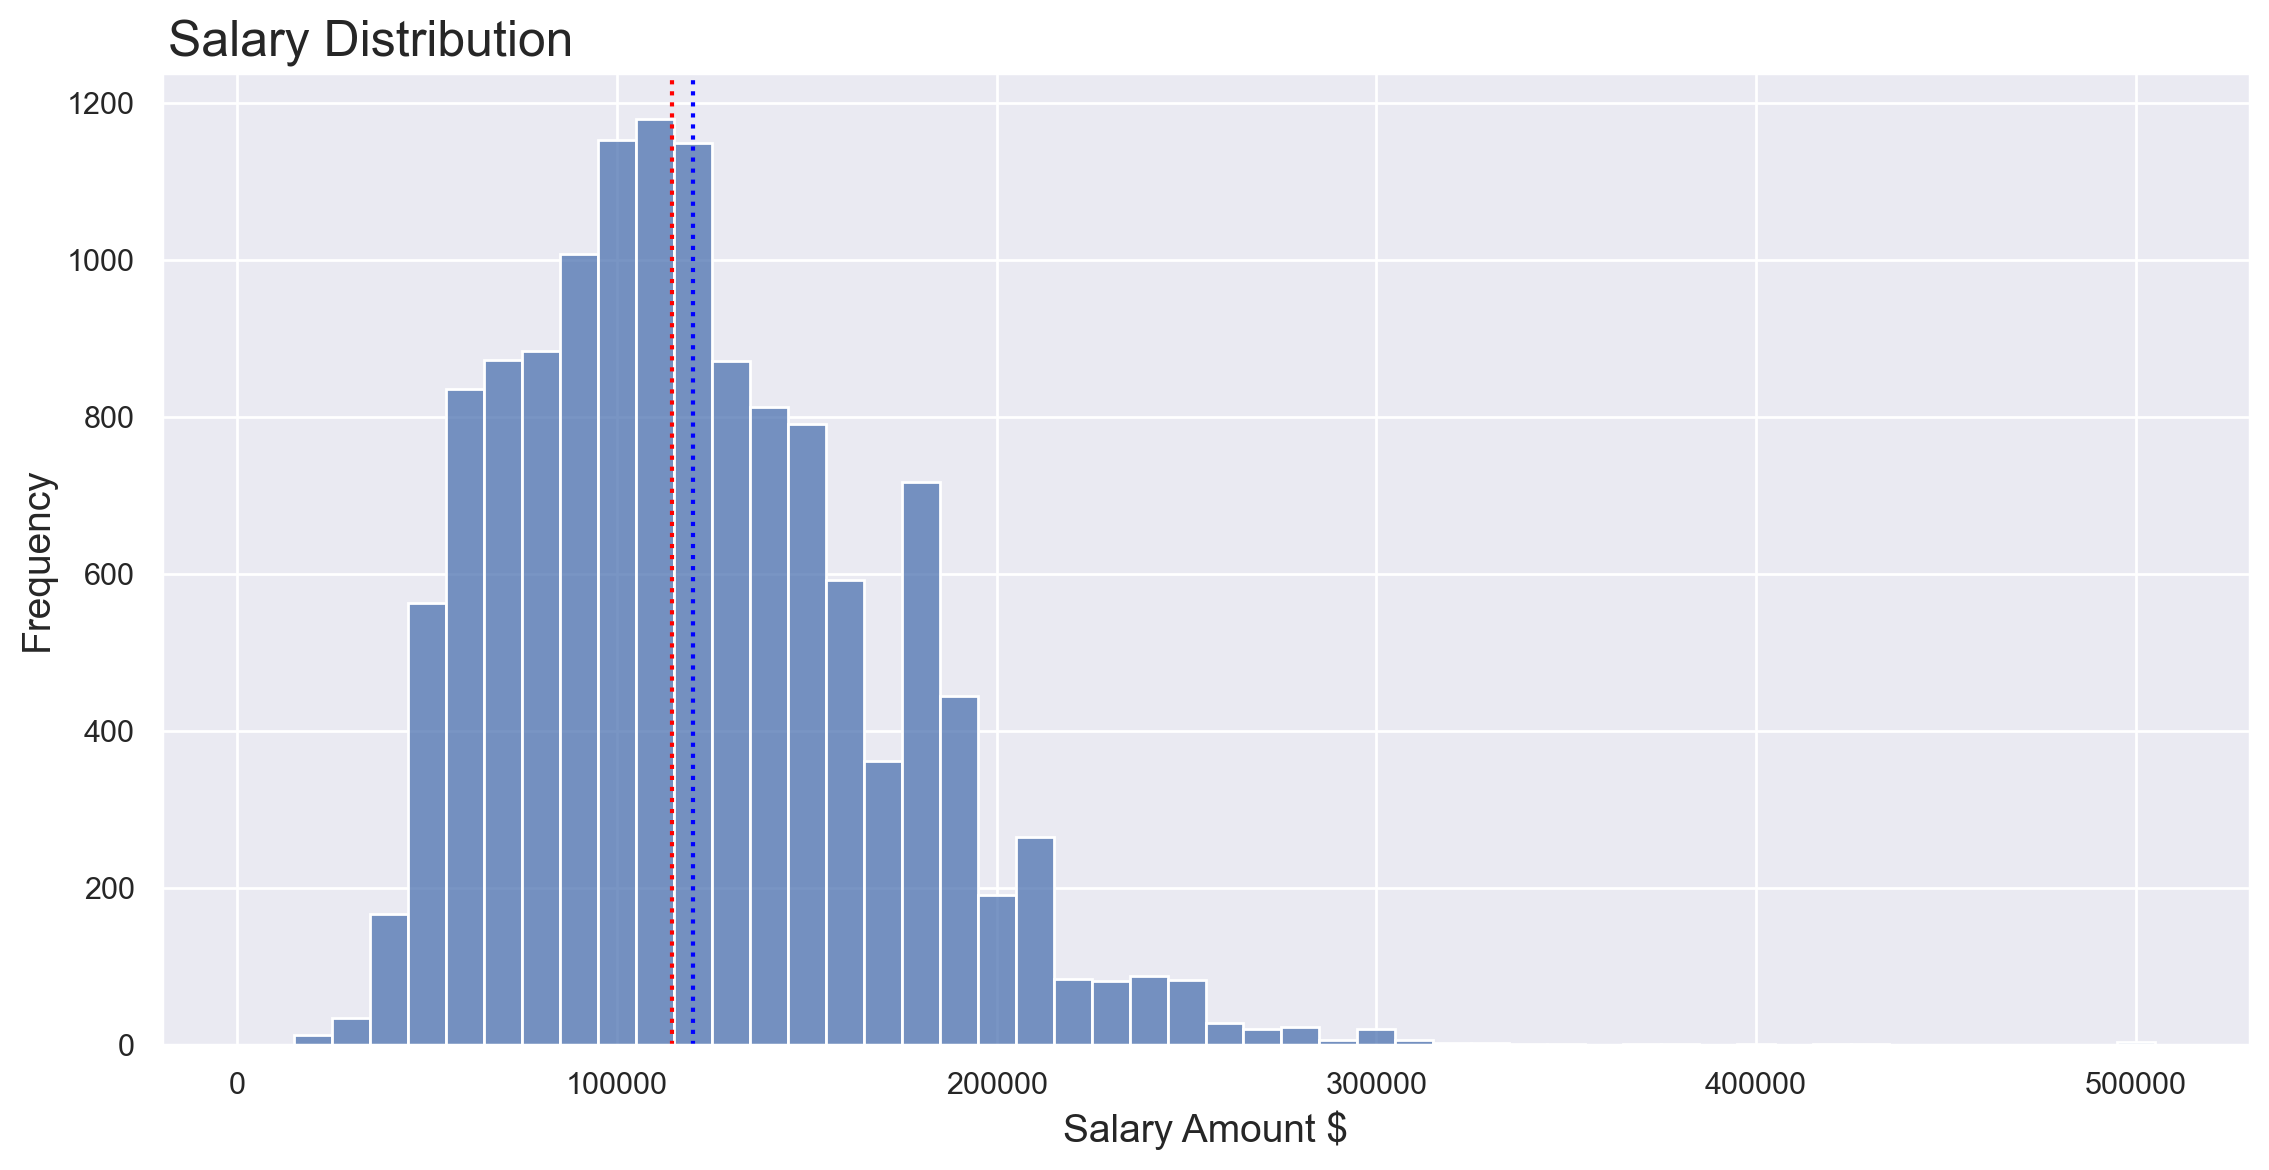

In [64]:
# Plotting the salary distribution
fig, ax = plt.subplots(figsize=(12, 6))

sns.histplot(df['salary_amount'], bins=50, binrange=(5000, 505000), ax=ax)
ax.set_xlabel('Salary Amount $', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_title('Salary Distribution', x = 0.1, fontsize=18)
ax.axvline(x= df['salary_amount'].mean(), color='blue', linestyle='dotted')
ax.axvline(x= df['salary_amount'].median(), color='red', linestyle='dotted')

plt.show()

The histogram above shows a typical right skewed distribution, with a pretty long tail towards the largest salary amounts.  
The red line describes the median salary which is equal to \\$114,500, while the blue line is the mean salary which is equal to \\$120,064.  


<br/><br/>

In [69]:
# Calculating the ratio of unique job titles
len(df['job_title'].unique())/len(df)

0.6142215568862276

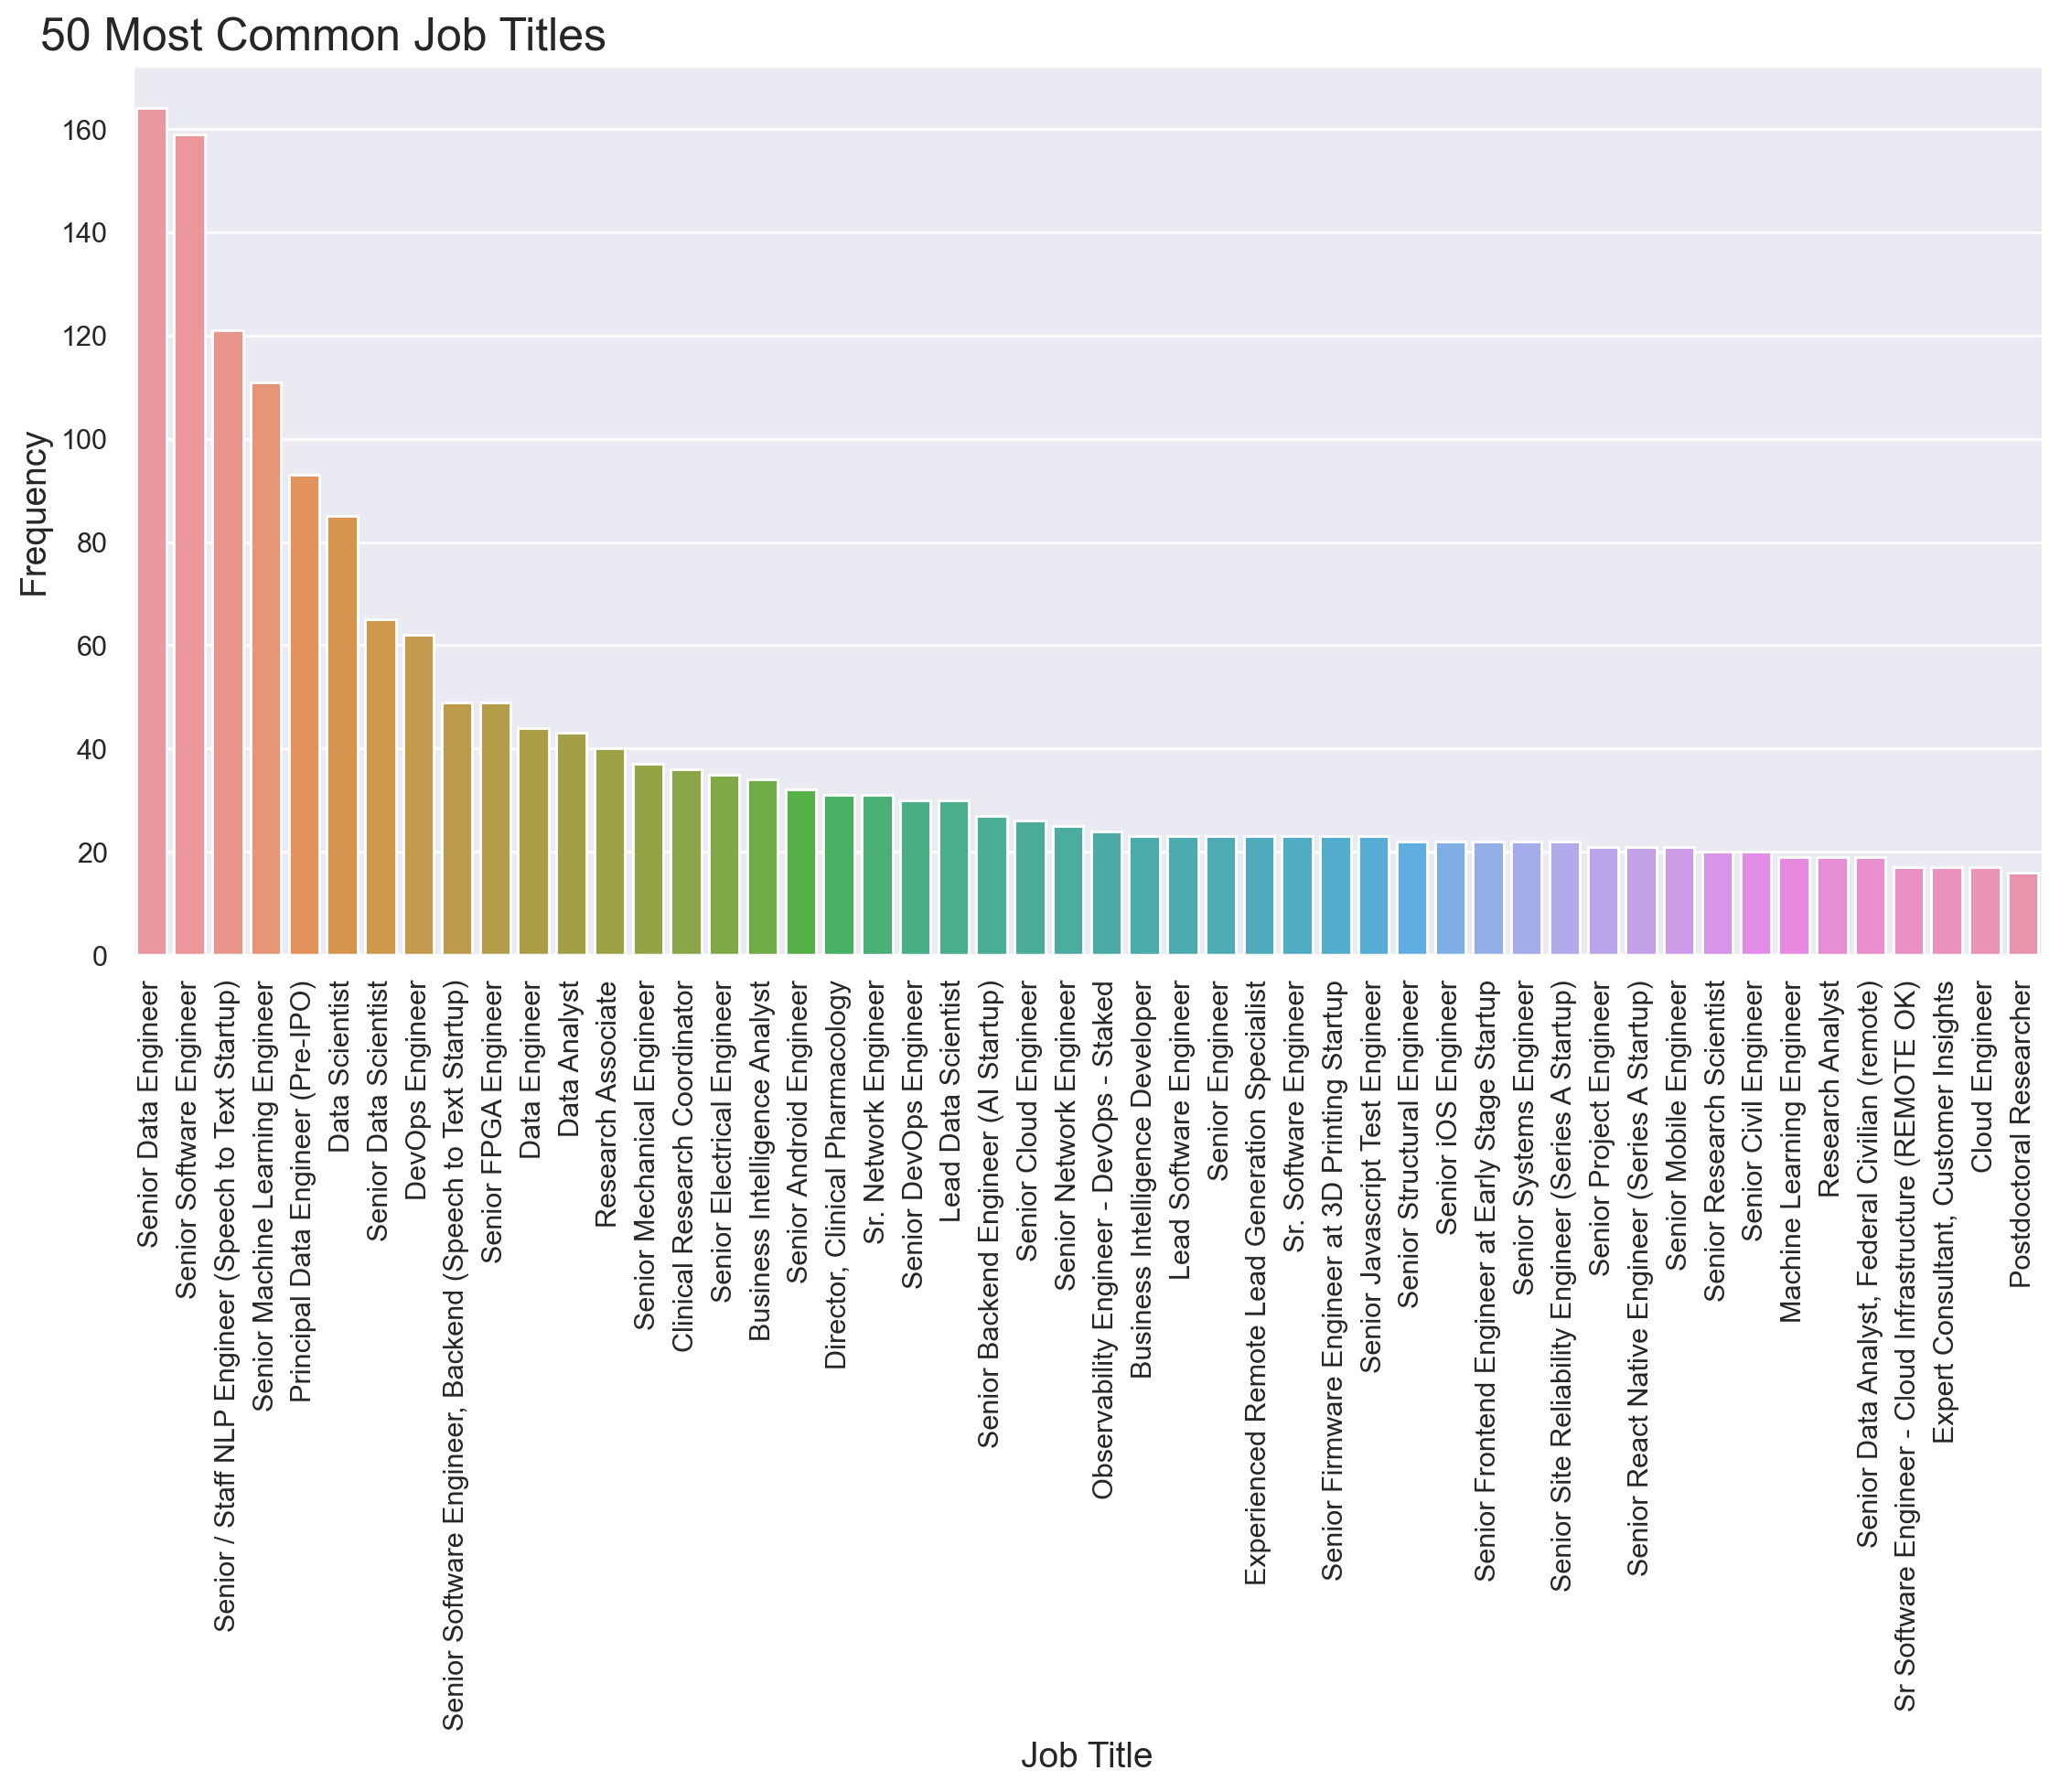

In [70]:
# Calculating the 50 most common job titles
most_common_jt = df['job_title'].value_counts().sort_values(ascending = False).head(50)

# Plotting the distribution
fig, ax = plt.subplots(figsize = (12,6))

plt.xticks(rotation = 90)
sns.barplot(x = most_common_jt.index, y = most_common_jt.values, ax=ax)
ax.set_xlabel('Job Title', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_title('50 Most Common Job Titles', x = 0.1, fontsize=18)

plt.show()

The most common job titles are **Senior Data Engineer** and **Senior Software Engineer**, however the majority (~61%) of the job titles are unique.  

<br/><br/>

In [74]:
# Calculating the ratio of unique company names
len(df['company_name'].value_counts())/len(df)

0.305688622754491

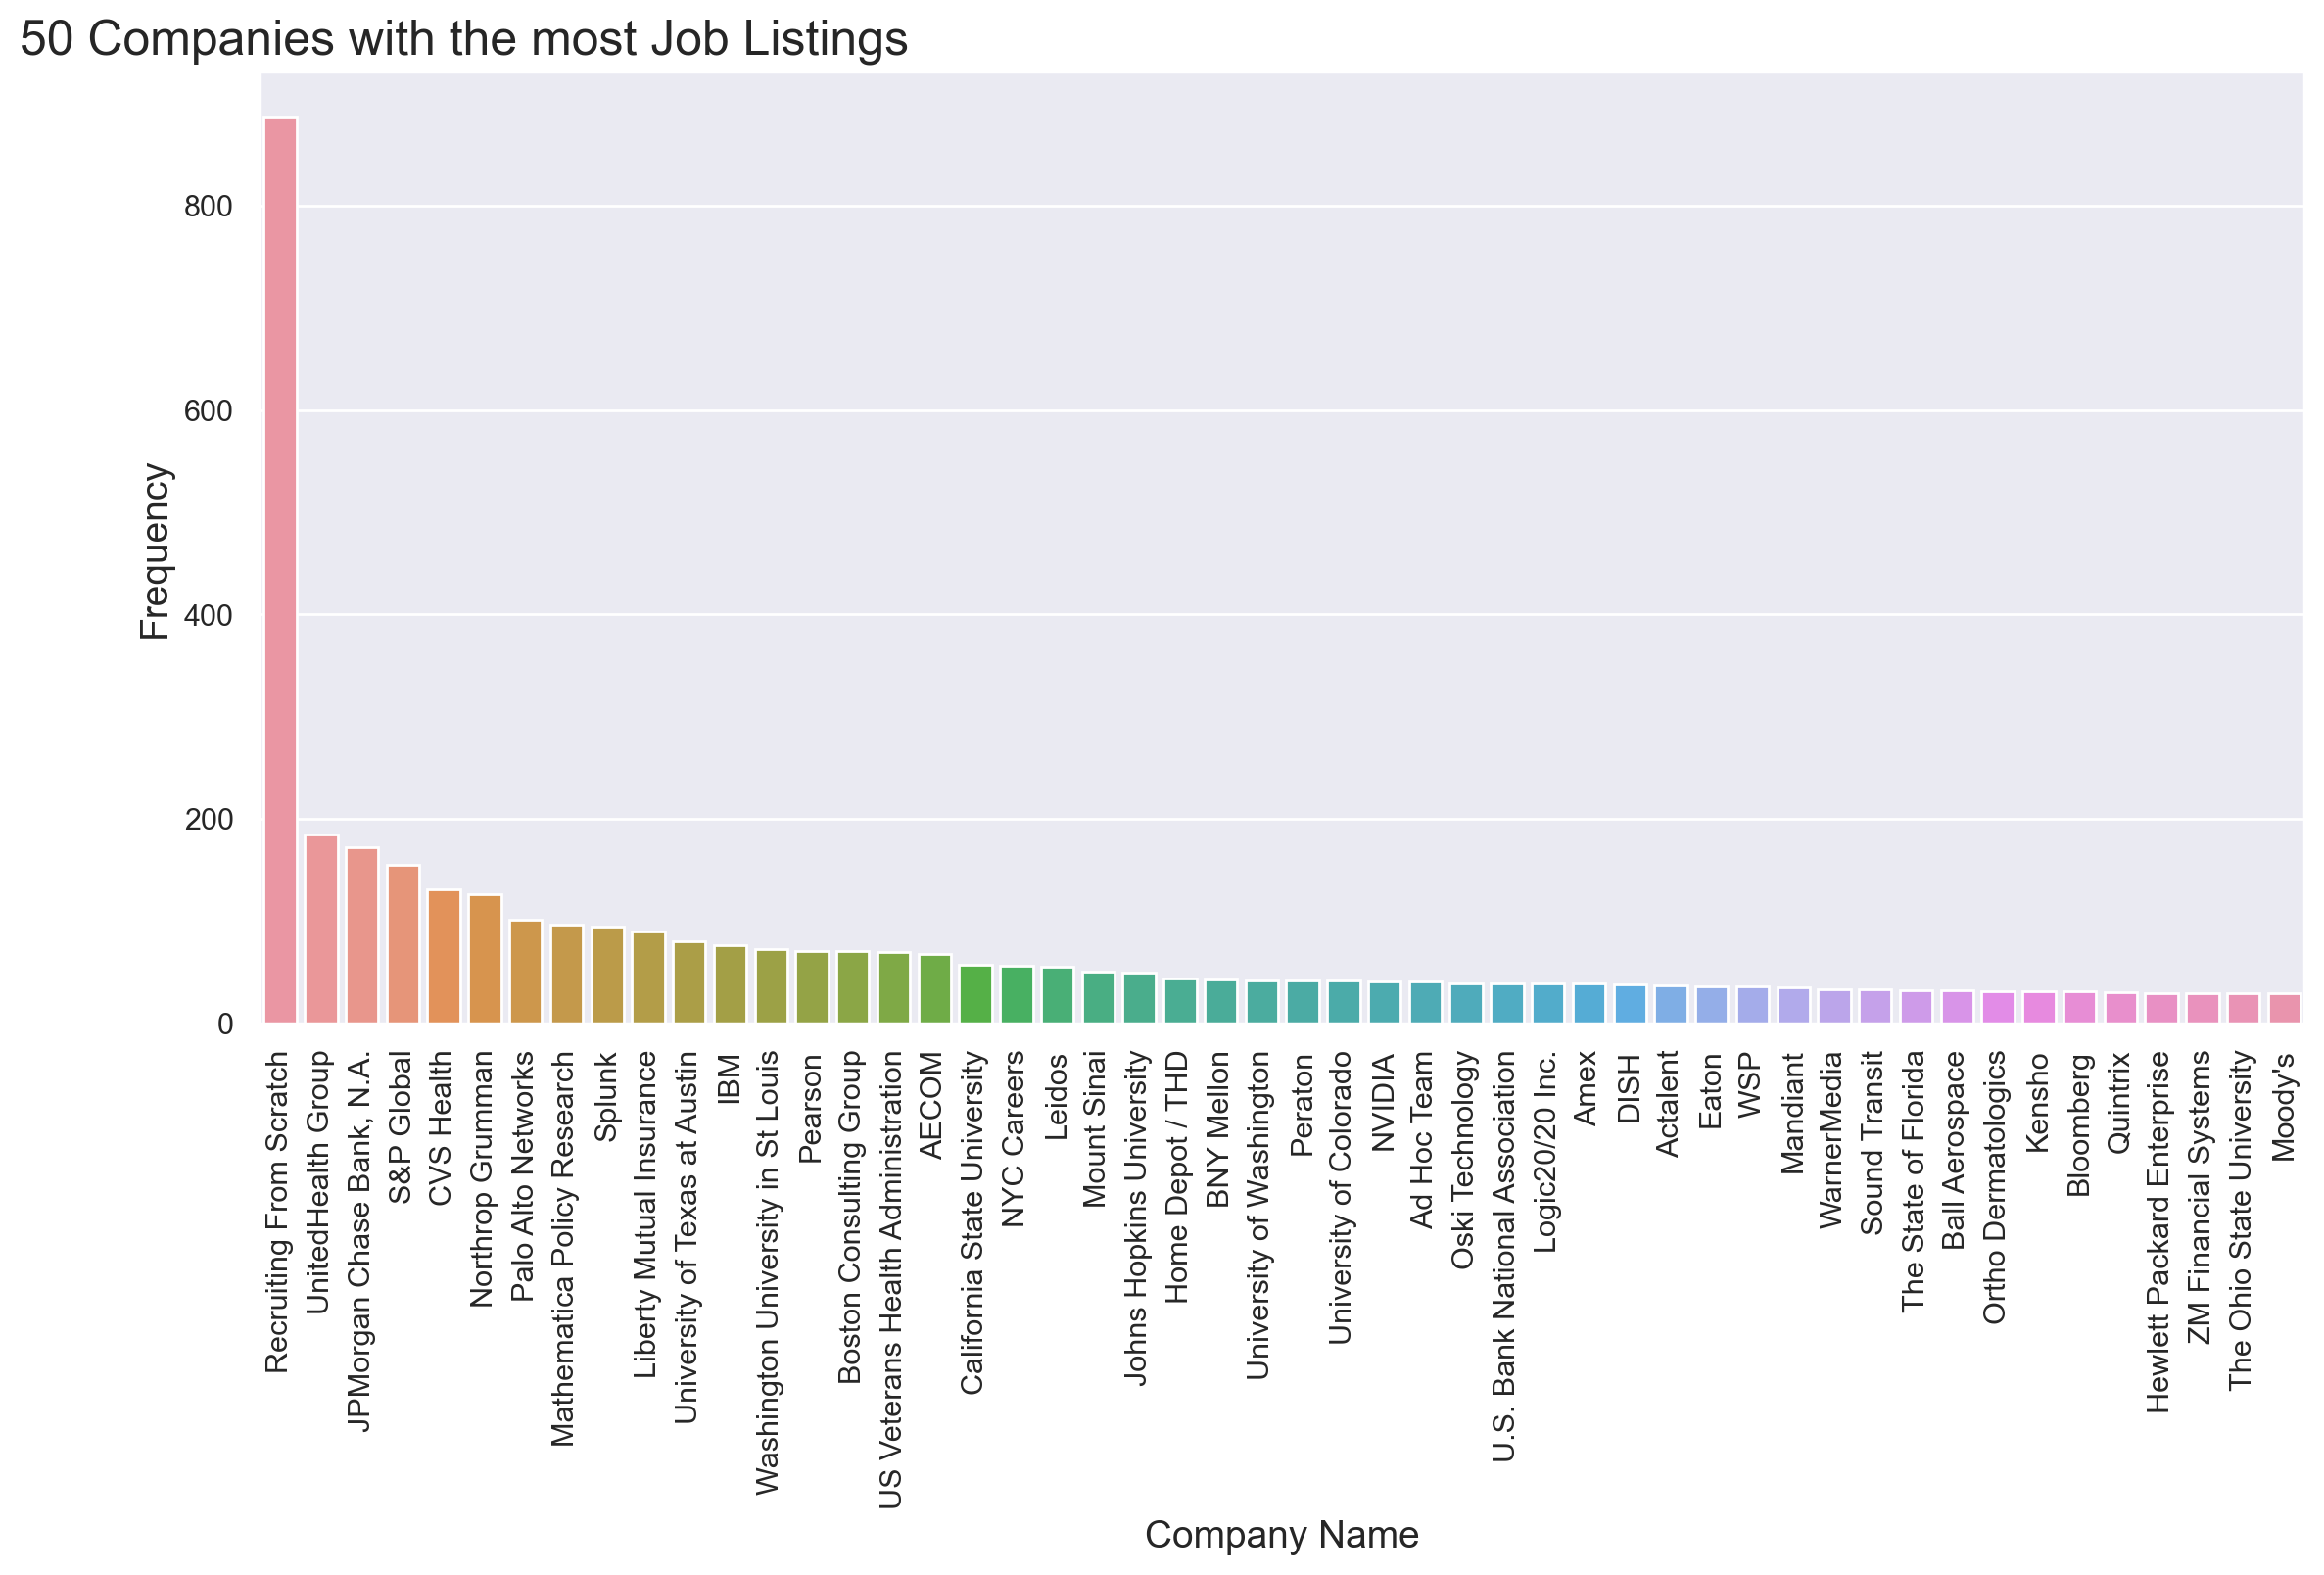

In [75]:
# Calculating the 50 companies with the most job listings
most_common_cn = df['company_name'].value_counts().sort_values(ascending = False).head(50)

# Plotting the distribution
fig, ax = plt.subplots(figsize = (12,6))

plt.xticks(rotation = 90)
sns.barplot(x = most_common_cn.index, y = most_common_cn.values, ax=ax)
ax.set_xlabel('Company Name', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_title('50 Companies with the most Job Listings', x = 0.1, fontsize=18)

plt.show()

In [ ]:
## TO ADD

# 50 companies with the most job listing (LOS)
# company rating histogram (LOS)
# listings per searched location (LOS)
# 50 most frequently scraped locations (LOS)
#
#
#


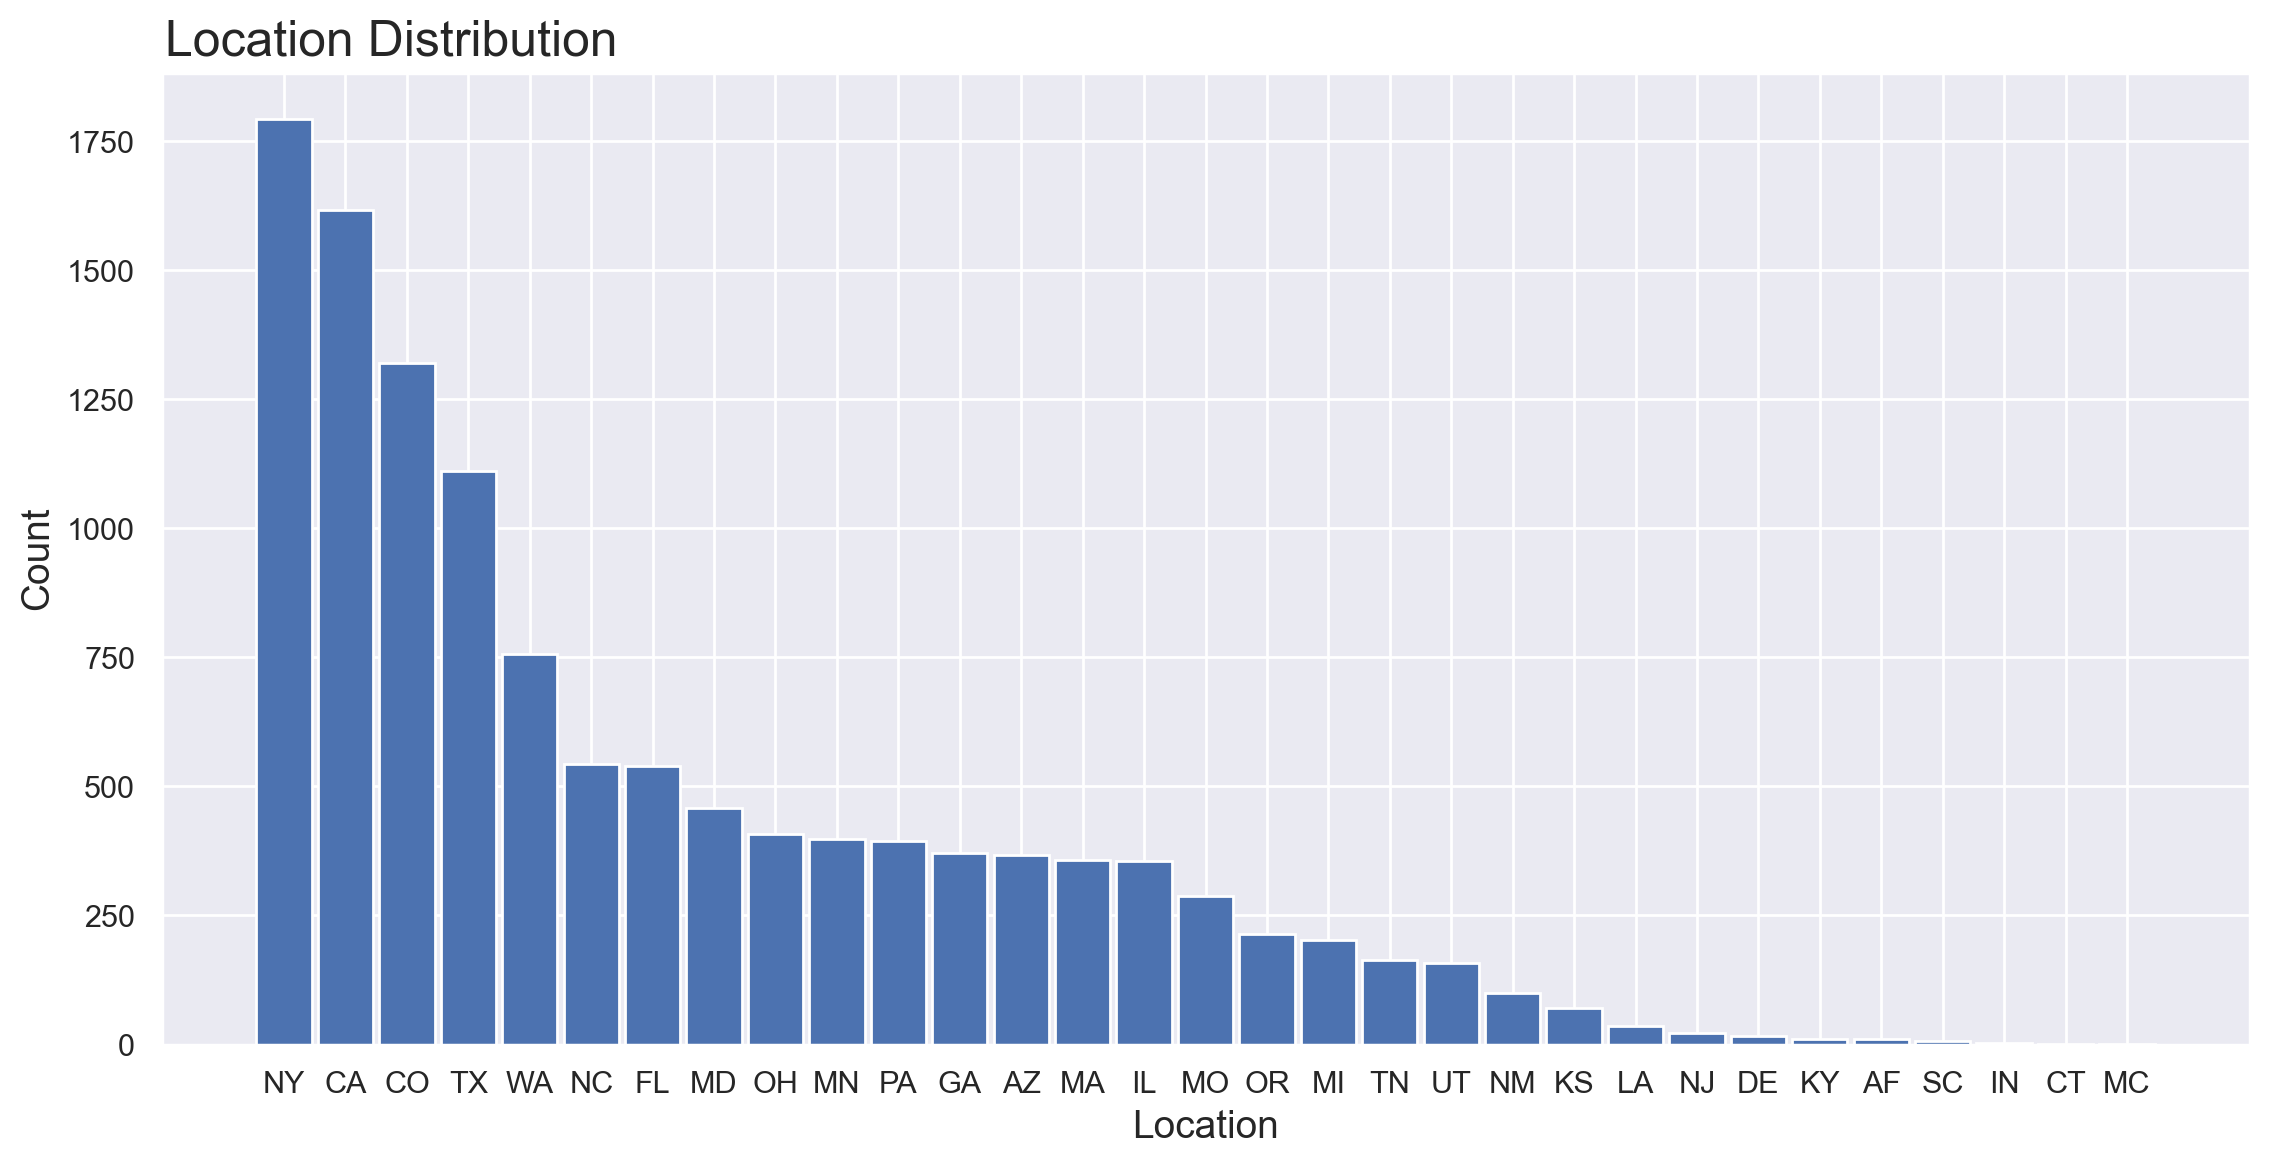

In [137]:
locs = df.company_location.value_counts().index
locs_counts = df.company_location.value_counts().values

plt.figure(figsize=(12,6))
plt.bar(locs, locs_counts, width=0.9)
plt.title('Location Distribution', x = 0.11, fontsize = 18)
plt.xlabel('Location', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.show()

### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median).

We could also perform Linear Regression (or any regression) to predict the salary value here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW salary.

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. We don't have to choose the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of salaries.

In [74]:
median = df.salary_amount.median()
print(median)

114252.25


In [75]:
def high_salary(row):
    median = df.salary_amount.median()
    if row['salary_amount'] >= median:
        return 1
    else:
        return 0

In [76]:
# Creating the new column and applying the function
df['high_salary'] = df.apply(lambda row: high_salary(row), axis=1)

In [77]:
df

job_title company_location  \
0      Senior Software Engineer, Backend (Speech to T...               NM   
1      Senior / Staff NLP Engineer (Speech to Text St...               NM   
2                                   Senior Data Engineer               NM   
3                      Principal Data Engineer (Pre-IPO)               NM   
4                       Senior Machine Learning Engineer               NM   
...                                                  ...              ...   
12153    Sr. Product Manager, Talent & Culture Portfolio               PA   
12154         Distinguished Solution Train Engineer (US)               NJ   
12155                    Construction Projects Manager I               PA   
12156                              School Nurse - Camden               NJ   
12157                   Platinion Principal IT Architect               PA   

       salary_amount  high_salary  
0           190000.0            1  
1           210000.0            1  
2           175000.0            1  
3           175000.0            1  
4           175000.0            1  
...              ...          ...  
12153       118680.0            1  
12154       172380.0            1  
12155        55739.0            0  
12156        71500.0            0  
12157       200000.0            1  

[12158 rows x 4 columns]

#### Thought experiment: What is the baseline accuracy for this model?

Using the median as the splitting point means that the accuracy should be perfectly 0.5

In [78]:
df.high_salary.value_counts(normalize=True).max()

0.5

### Create a classification model to predict High/Low salary. 


- Start by ONLY using the location as a feature.
- Use at least two different classifiers you find suitable.
- Remember that scaling your features might be necessary.
- Display the coefficients/feature importances and write a short summary of what they mean.
- Create a few new variables in your dataframe to represent interesting features of a job title (e.g. whether 'Senior' or 'Manager' is in the title).
- Incorporate other text features from the title or summary that you believe will predict the salary.
- Then build new classification models including also those features. Do they add any value?
- Tune your models by testing parameter ranges, regularization strengths, etc. Discuss how that affects your models.
- Discuss model coefficients or feature importances as applicable.

In [524]:
# Saving the modified dataframe as CSV
df.to_csv('datasets/df.csv', encoding='utf-8', index=False)

In [142]:
# Loading the data from CSV for consistency reasons
df = pd.read_csv('datasets/df.csv')

In [147]:
# Using only location as feature
df_dum = pd.get_dummies(df, columns=['company_location'], drop_first=True)
df_dum.drop(columns=['job_title', 'salary_amount'], inplace=True)
df_dum.head()

high_salary  company_location_AZ  company_location_CA  company_location_CO  \
0            1                    0                    0                    0   
1            1                    0                    0                    0   
2            1                    0                    0                    0   
3            1                    0                    0                    0   
4            1                    0                    0                    0   

   company_location_CT  company_location_DE  company_location_FL  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    0                    0   

   company_location_GA  company_location_IL  company_location_IN  ...  \
0                    0                    0                    0  ...   
1                    0                    0                    0  ...   
2                    0                    0                    0  ...   
3                    0                    0                    0  ...   
4                    0                    0                    0  ...   

   company_location_NM  company_location_NY  company_location_OH  \
0                    1                    0                    0   
1                    1                    0                    0   
2                    1                    0                    0   
3                    1                    0                    0   
4                    1                    0                    0   

   company_location_OR  company_location_PA  company_location_SC  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    0                    0   

   company_location_TN  company_location_TX  company_location_UT  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    0                    0   

   company_location_WA  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  

[5 rows x 31 columns]

In [209]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import plot_confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, average_precision_score, plot_roc_curve, plot_precision_recall_curve
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier


In [149]:
# Choosing target and predictor variables
y = df_dum.pop('high_salary')
X = df_dum

In [150]:
# Creating train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

In [151]:
scaler = StandardScaler()

# Rescaling variables
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

#### Logistic Regression

In [219]:
# Instantiating the model 
logreg = LogisticRegression(solver='saga', multi_class='auto', max_iter=1000)

# Fitting the model
logreg.fit(X_train, y_train)

# Calculating scores
logreg_train = logreg.score(X_train, y_train)
logreg_test = logreg.score(X_test, y_test)
logreg_cv = (cross_val_score(logreg, X_train, y_train, cv = 10)).mean()

# Collecting the scores in a dataframe to compare different models later
logreg_df = pd.DataFrame([logreg_train, logreg_test, logreg_cv], index = ['train', 'test', 'cv'], columns=['Logistic Reg'])

print('Logistic Regression Scores: \n')
print('train score: ', logreg_train)
print('test score: ', logreg_test)
print('CV score: ', logreg_cv)

Logistic Regression Scores: 

train score:  0.5728973884433477
test score:  0.5641447368421053
CV score:  0.5685822770355144


Feature Importance & Model Coefficients

In [220]:
# Collecting the model coefficients in a dataframe
lr_coef = pd.DataFrame(logreg.coef_[0], index=X_train.columns, columns=['coefficients'])
lr_coef.sort_values(by = 'coefficients', ascending = False)[:10]

coefficients
company_location_CA      0.115076
company_location_NY      0.106904
company_location_DE      0.019520
company_location_GA     -0.000570
company_location_MA     -0.004725
company_location_IL     -0.004872
company_location_MD     -0.010070
company_location_KS     -0.010530
company_location_NM     -0.014796
company_location_TN     -0.022901

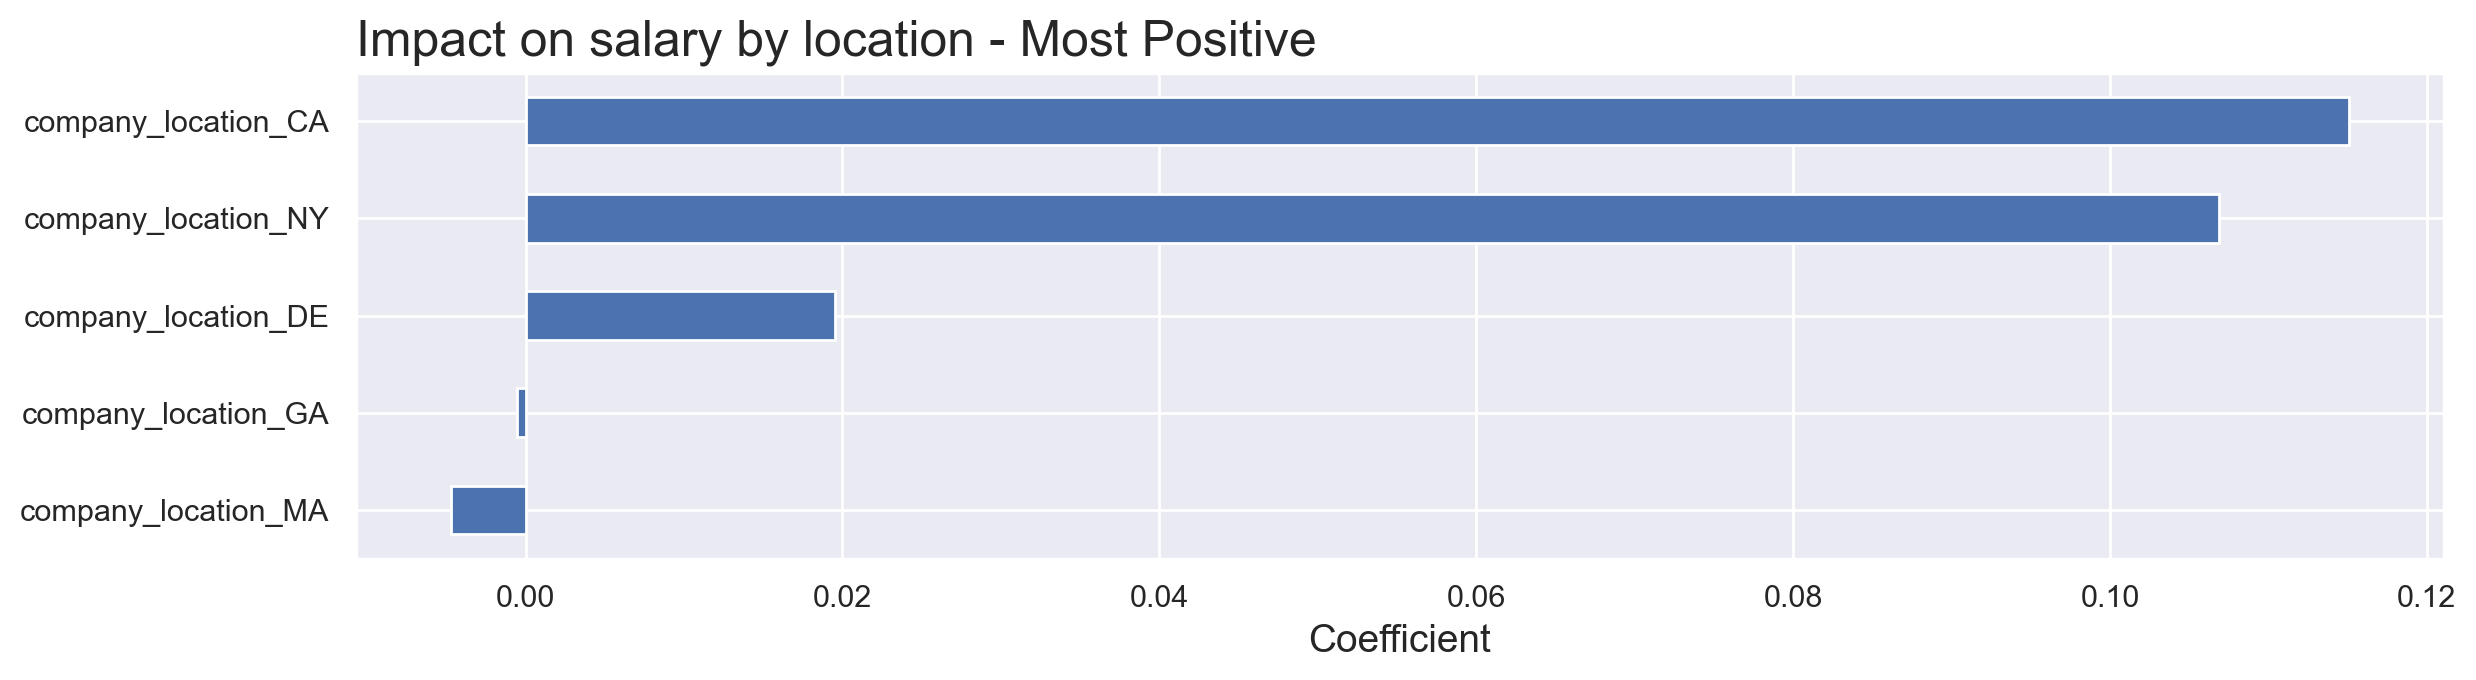

In [221]:
# Plotting the coefficients
plt.figure(figsize=(12,3))
plt.title('Impact on salary by location - Most Positive', loc='left', fontsize = 18)
plt.xlabel('Coefficient', fontsize = 14)

lr_coef['coefficients'].sort_values(ascending = True).tail(5).plot(kind='barh');

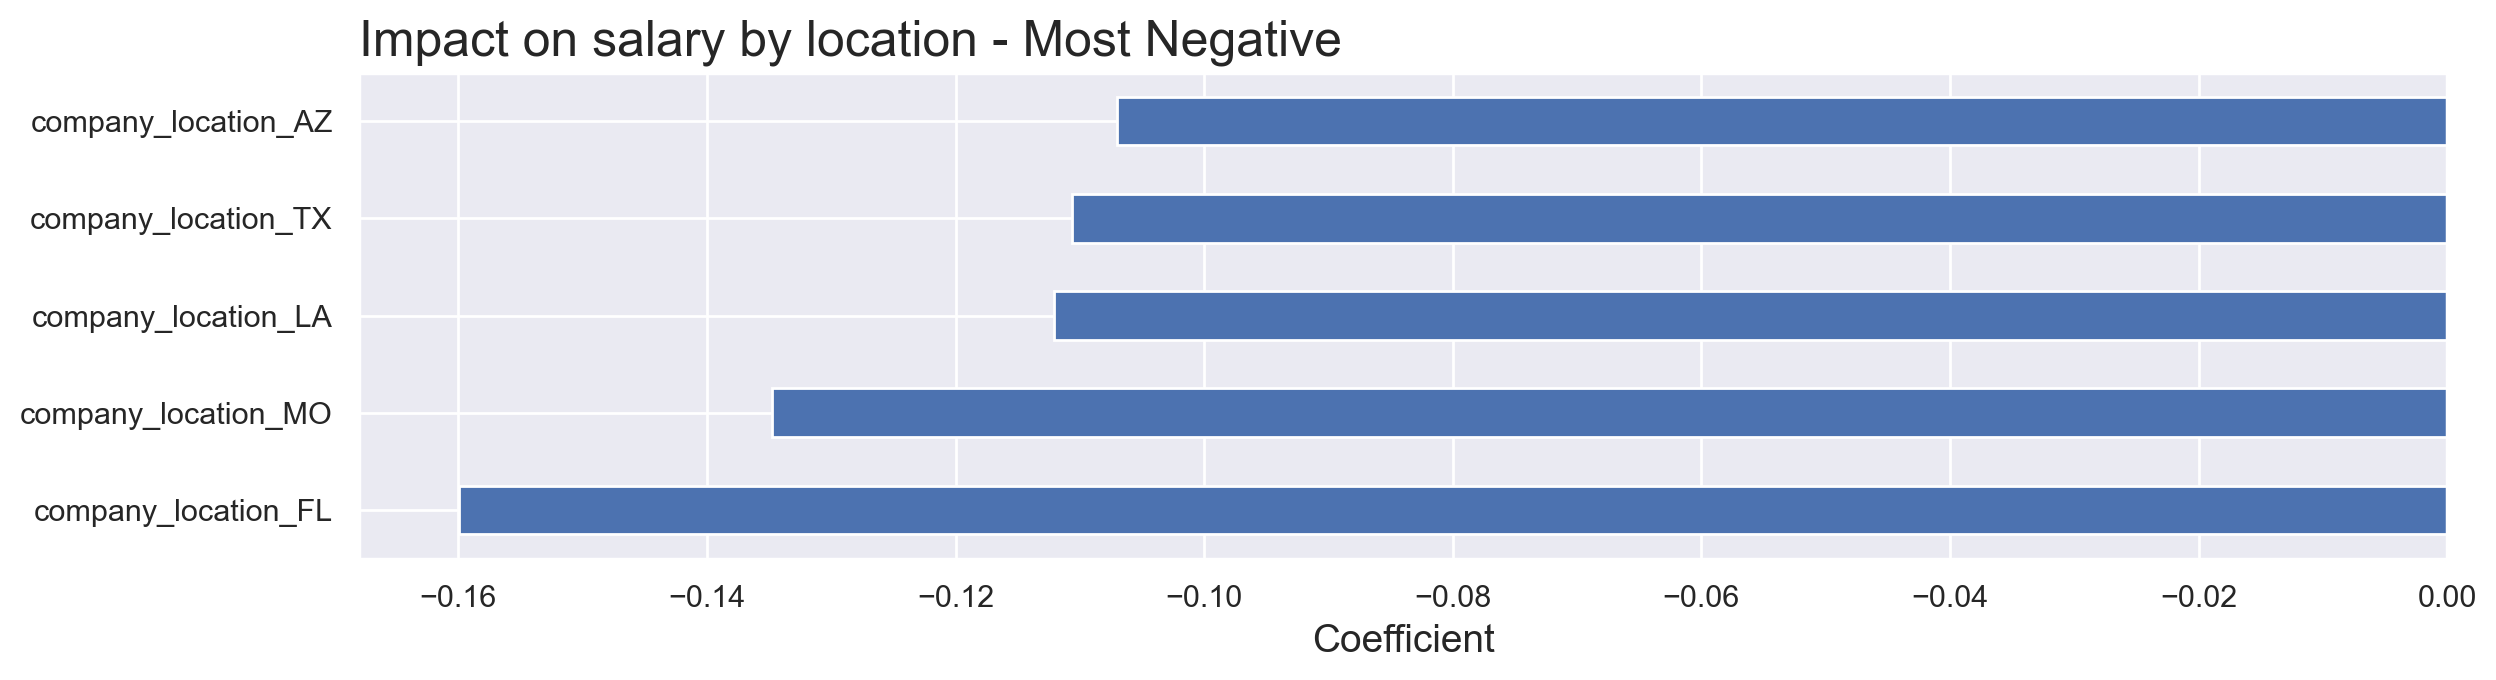

In [222]:
# Plotting the coefficients
plt.figure(figsize=(12,3))
plt.title('Impact on salary by location - Most Negative', loc='left', fontsize = 18)
plt.xlabel('Coefficient', fontsize = 14)

lr_coef['coefficients'].sort_values(ascending = True).head(5).plot(kind='barh');

Logistic Regression coeffients describe the size and the direction of the relationship between a predictor and the target variable.  
In this model, a job located in the states of **California**, **New York** and **Delaware** has a large influence on having a high paying salary since their coefficients are positive and relatively large.  
On the other side, job openings located in **Florida**, **Missouri** and **Louisiana** have negative and relatively large coefficients, so in those locations the salary would likely be well below median.
<br/><br/>

Classification Report

In [223]:
predictions = logreg.predict(X_test)

print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.57      0.53      0.55      1216
           1       0.56      0.60      0.58      1216

    accuracy                           0.56      2432
   macro avg       0.56      0.56      0.56      2432
weighted avg       0.56      0.56      0.56      2432



Confusion Matrix

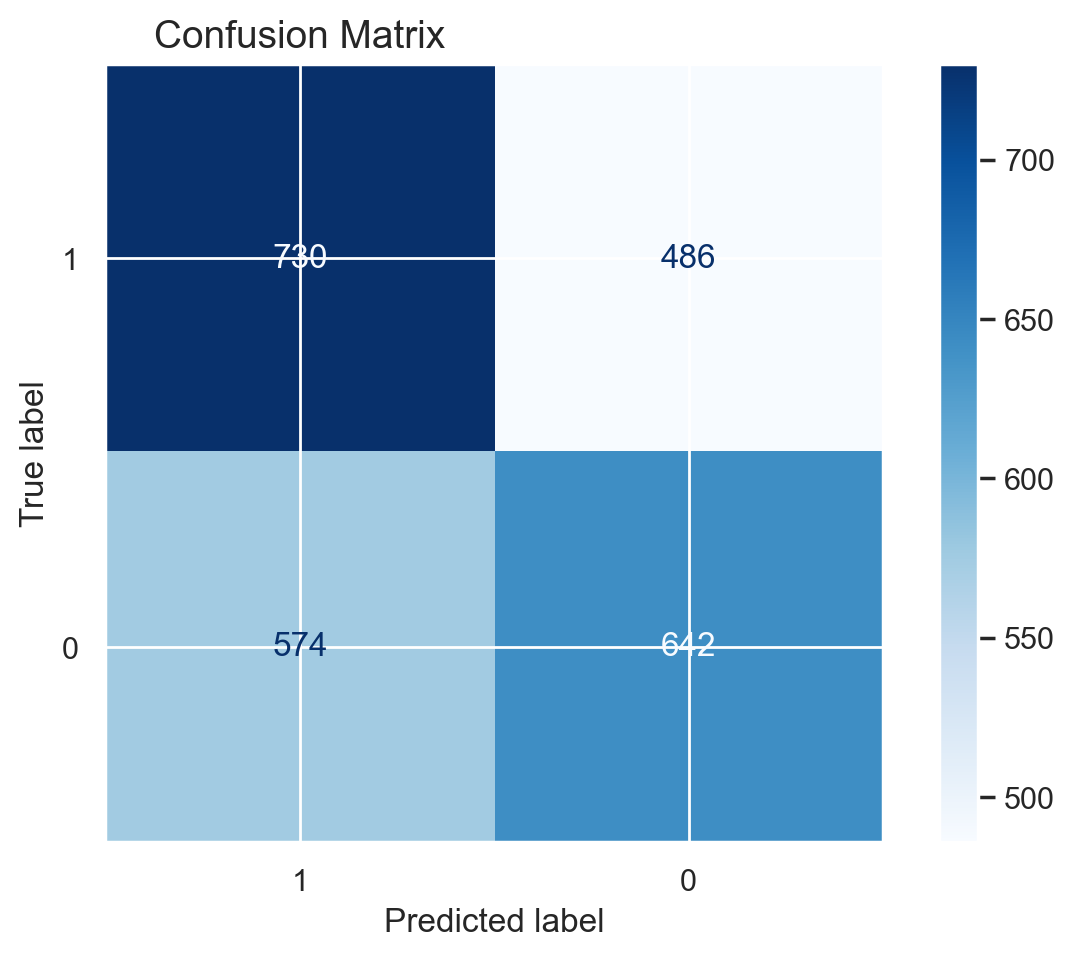

In [224]:
plot_confusion_matrix(logreg, X_test, y_test, cmap='Blues', labels=[1, 0])
plt.title('Confusion Matrix', x = 0.25, fontsize = 14)
plt.show()

ROC-AUC Curve

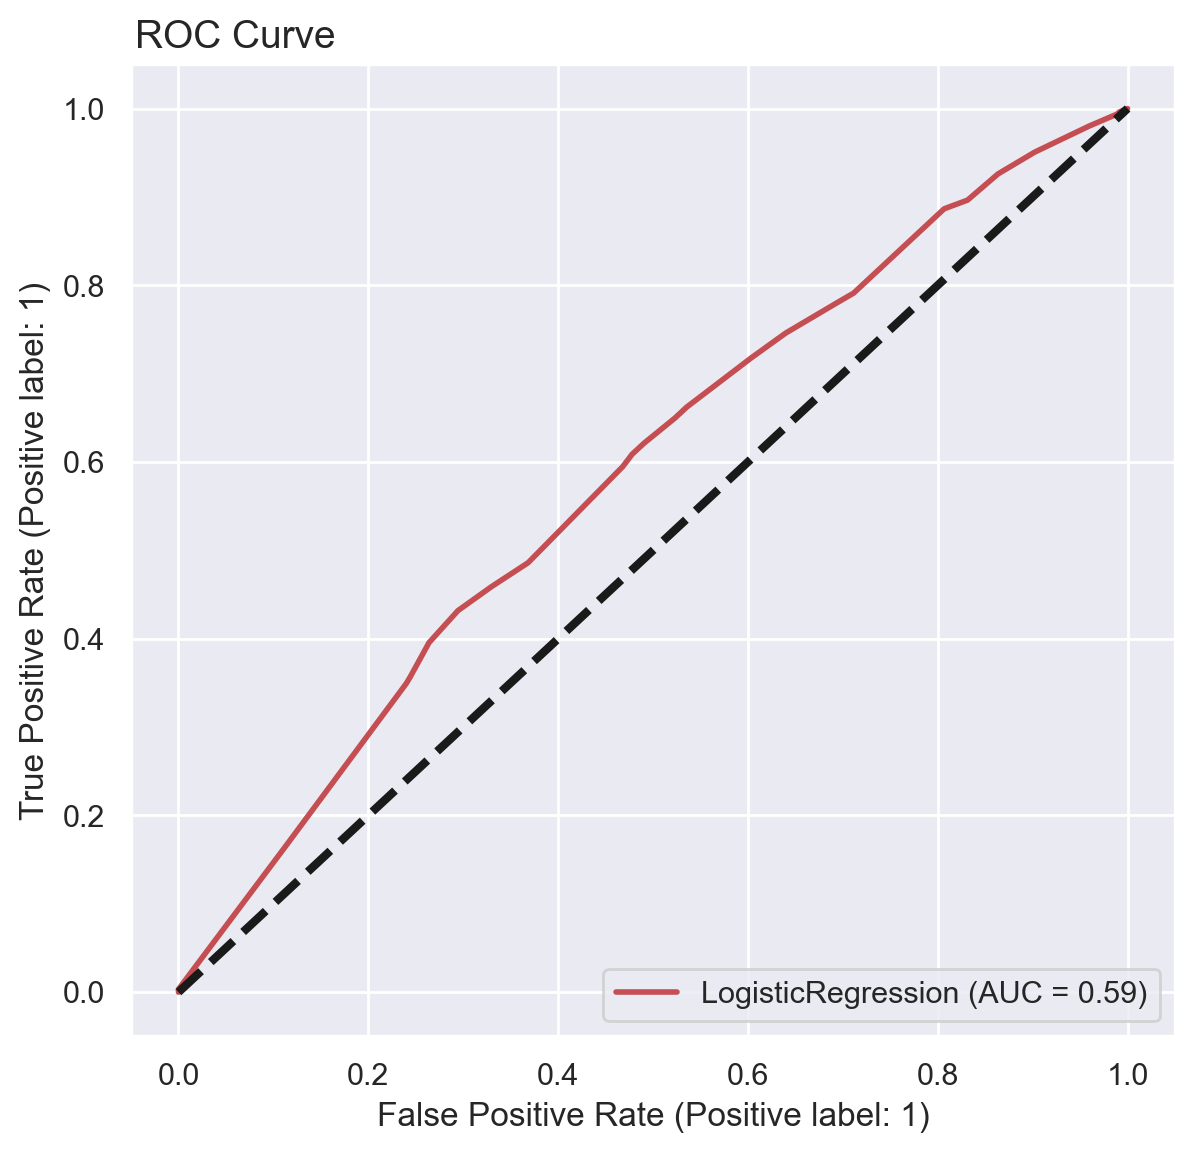

In [225]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_roc_curve(logreg, X_test, y_test, c='r', lw=2, ax=ax)
plt.title('ROC Curve', x = 0.1, fontsize = 14)
ax.plot([0, 1], [0, 1], 'k--', lw=3)
plt.show()

In [226]:
print('ROC-AUC Score:', roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1]))

ROC-AUC Score: 0.5855269920792936


The f1-score is balanced between the two classes, however the accuracy of the model is pretty low.  
The area under the curve is **0.59**, which tells us that this model has a bad class separation capacity.  
<br/><br/>

#### Decision Tree with Grid Search CV

In [246]:
# define gridsearch parameters
dtree_params = {
    'max_depth': list(range(1, 11))+[None],
    'max_features': [None, 1, 2, 3],
    'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50],
    'ccp_alpha': [0, 0.001, 0.005, 0.01]}


# define the model
dtree = DecisionTreeClassifier(random_state = 1)

# instantiate the gridsearch
dtc_gs = GridSearchCV(dtree, dtree_params, cv=5, n_jobs=10, verbose=1)

# find the fit in the gridsearch
dtc_gs.fit(X_train, y_train)

# pull out the model with the best parameters found in the gridsearch
dt_best = dtc_gs.best_estimator_

# calculate scores
dt_train = dt_best.score(X_train, y_train)
dt_test = dt_best.score(X_test, y_test)
dt_cv = (cross_val_score(dt_best, X_train, y_train, cv = 10)).mean()

# collect the scores in a dataframe to compare different models later
dt_df = pd.DataFrame([dt_train, dt_test, dt_cv], index = ['train', 'test', 'cv'], columns = ['Decision Tree'])

print('Decision Tree Classifier Scores: \n')
print('train score: ', dt_train)
print('test score: ', dt_test)
print('CV score: ', dt_cv)

Fitting 5 folds for each of 1936 candidates, totalling 9680 fits
Decision Tree Classifier Scores: 

train score:  0.5728973884433477
test score:  0.5633223684210527
CV score:  0.5691990323085447


Feature Importance & Model Coefficients

In [247]:
# Collecting the model coefficients in a dataframe
dt_coef = pd.DataFrame(dt_best.feature_importances_, columns=['importance'], index=X.columns)
dt_coef.sort_values(by = 'importance', ascending = False)[:10]

importance
company_location_NY    0.351696
company_location_CA    0.264177
company_location_FL    0.074481
company_location_MO    0.063648
company_location_LA    0.042600
company_location_AZ    0.033127
company_location_CO    0.023695
company_location_MA    0.021270
company_location_IL    0.018555
company_location_GA    0.018213

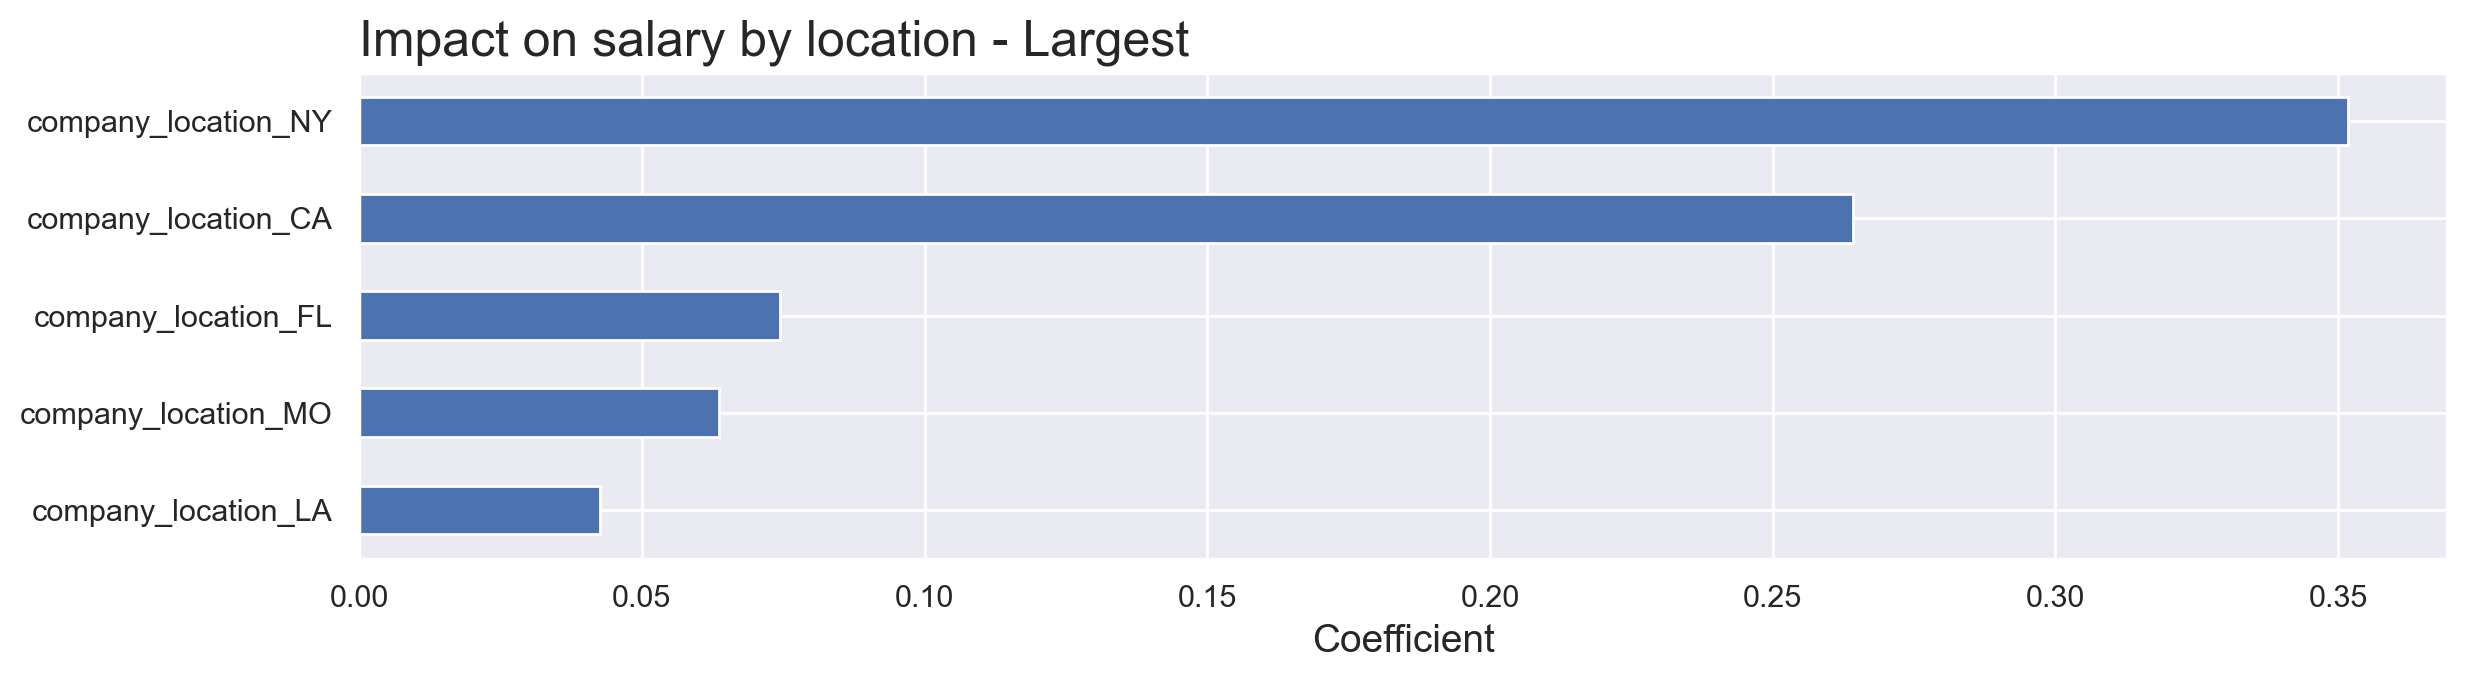

In [248]:
# Plotting the coefficients
plt.figure(figsize=(12,3))
plt.title('Impact on salary by location - Largest', loc='left', fontsize = 18)
plt.xlabel('Coefficient', fontsize = 14)

dt_coef['importance'].sort_values(ascending = True).tail(5).plot(kind='barh');

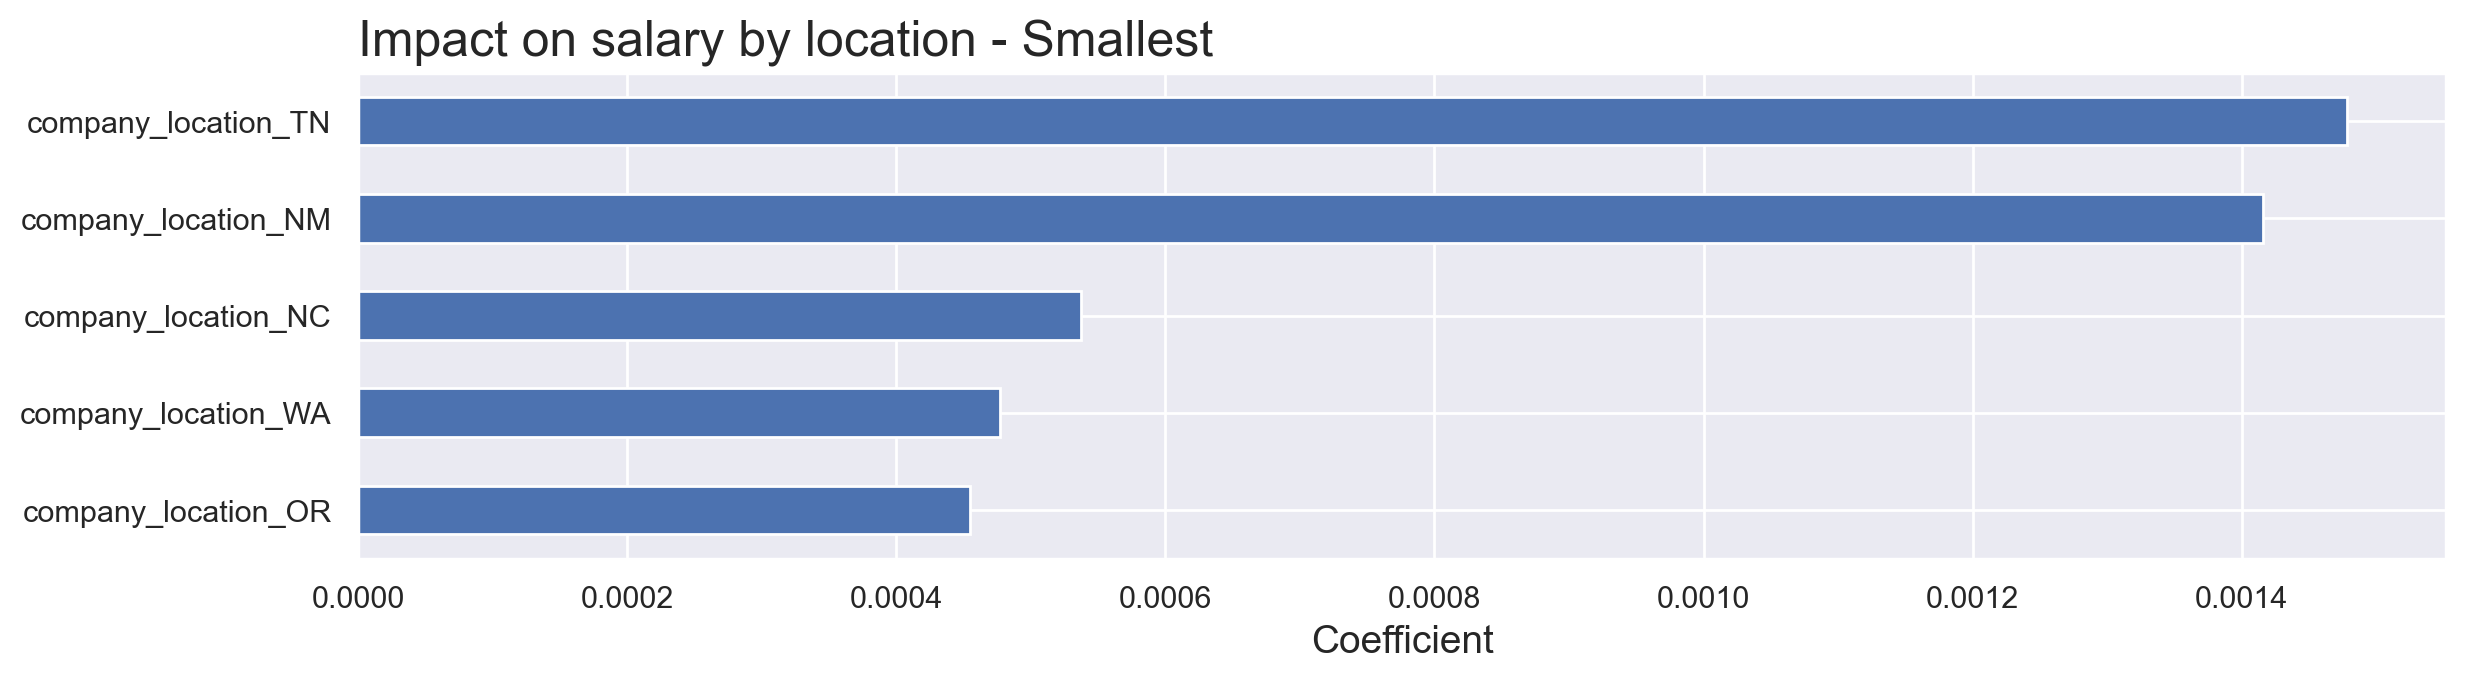

In [249]:
# Plotting the coefficients
plt.figure(figsize=(12,3))
plt.title('Impact on salary by location - Smallest', loc='left', fontsize = 18)
plt.xlabel('Coefficient', fontsize = 14)

dt_coef['importance'].sort_values(ascending = True).head(5).plot(kind='barh');

Feature importance in Decision Tree is based on node impurity and describes the size of the relationship between a predictor and the target variable.  
In this model, the states of **New York**, **California** and **Florida** have the highest values, indicating that these locations have the largest impact on salaries.  
On the other side, **Oregon**, **Washington** and **North Carolina** have the smallest impact on salaries.
<br/><br/>

Classification Report

In [250]:
predictions = dt_best.predict(X_test)

print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.57      0.53      0.55      1216
           1       0.56      0.59      0.58      1216

    accuracy                           0.56      2432
   macro avg       0.56      0.56      0.56      2432
weighted avg       0.56      0.56      0.56      2432



Confusion Matrix

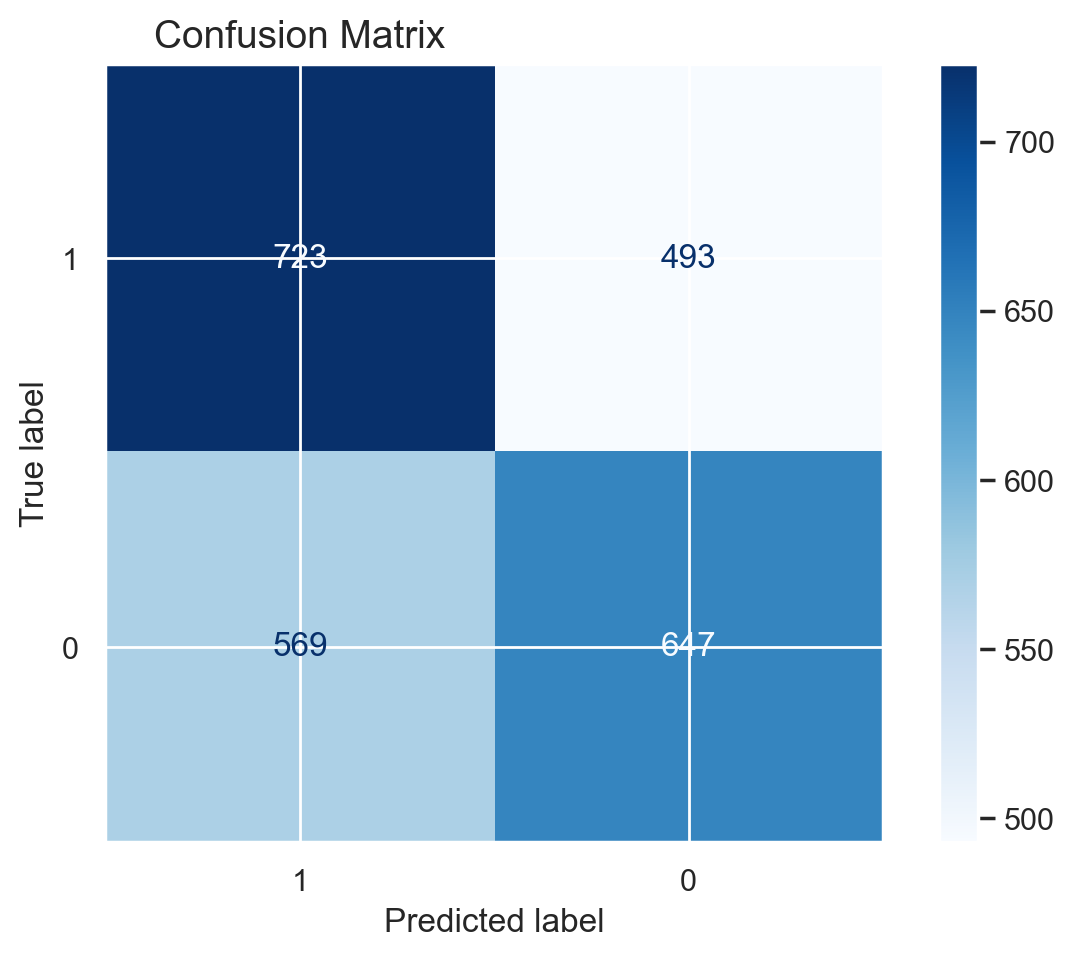

In [251]:
plot_confusion_matrix(dt_best, X_test, y_test, cmap='Blues', labels=[1, 0])
plt.title('Confusion Matrix', x = 0.25, fontsize = 14)
plt.show()

ROC-AUC Curve

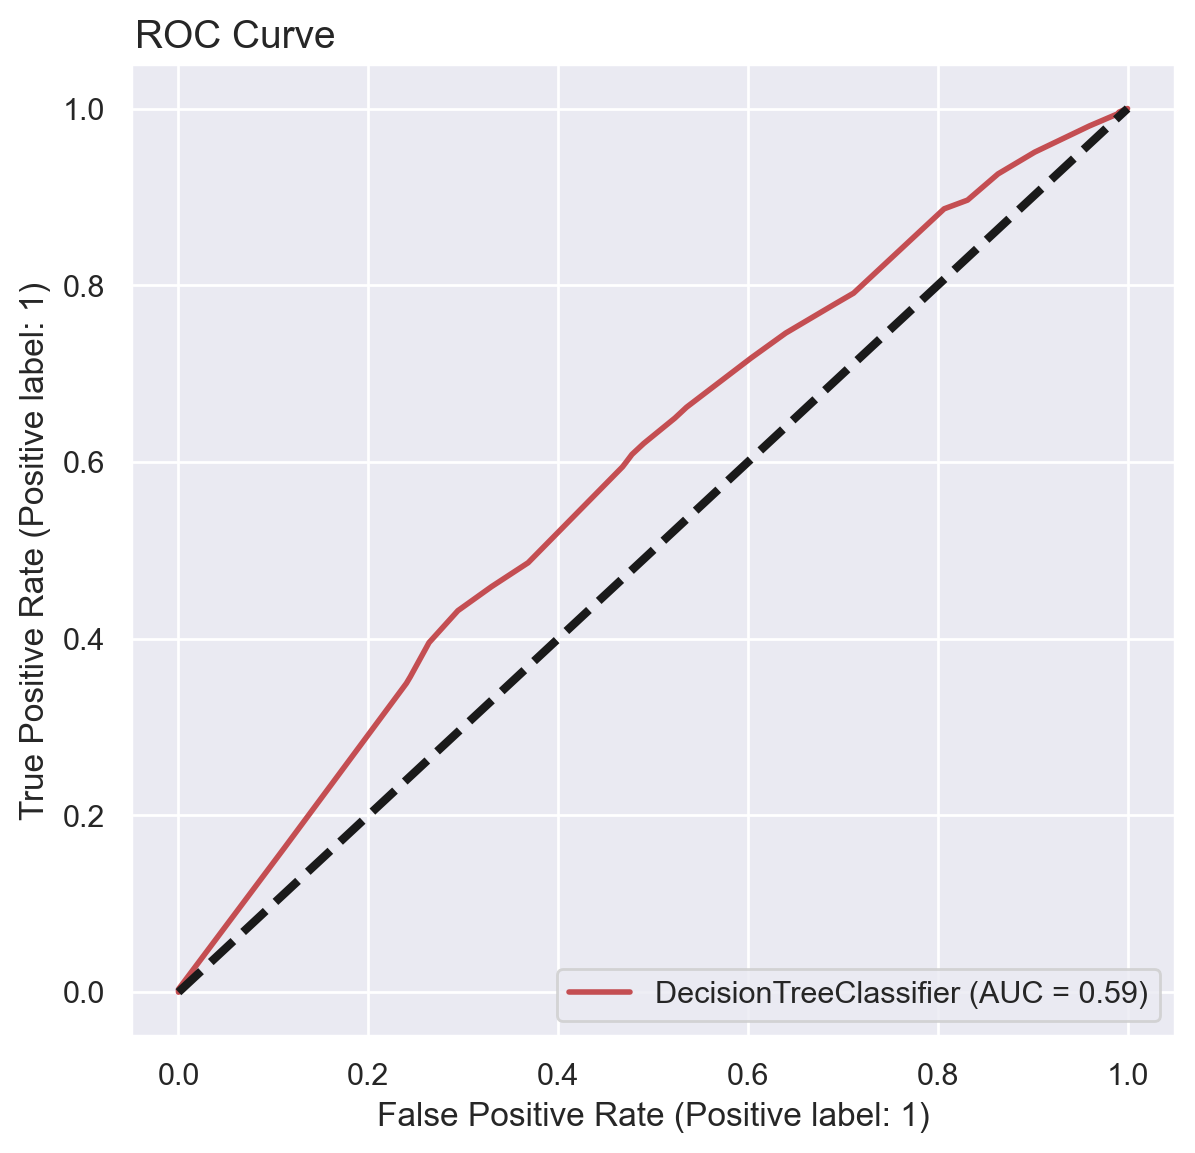

In [252]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_roc_curve(dt_best, X_test, y_test, c='r', lw=2, ax=ax)
plt.title('ROC Curve', x = 0.1, fontsize = 14)
ax.plot([0, 1], [0, 1], 'k--', lw=3)
plt.show()

In [253]:
print('ROC-AUC Score:', roc_auc_score(y_test, dt_best.predict_proba(X_test)[:, 1]))

ROC-AUC Score: 0.5855269920792936


The f1-score is balanced between the two classes, however the accuracy of the model is pretty low.  
The area under the curve is **0.59**, which tells us that this model has a bad class separation capacity.  
<br/><br/>

#### Random Forest with Grid Search CV

In [255]:
# define gridsearch parameters
randf_params = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': list(range(1, 11))+[None],
    'max_features': [None, 1, 2, 3, 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 3, 5, 7]}

# define the model
randf = RandomForestClassifier(random_state = 1)

# instantiate the gridsearch
rfc_gs = GridSearchCV(randf, randf_params, cv=5, n_jobs=10, verbose=1)

# find the fit in the gridsearch
rfc_gs.fit(X_train, y_train)

# pull out the model with the best parameters found in the gridsearch
rf_best = rfc_gs.best_estimator_

# calculate scores
rf_train = rf_best.score(X_train, y_train)
rf_test = rf_best.score(X_test, y_test)
rf_cv = (cross_val_score(rf_best, X_train, y_train, cv = 10)).mean()

# collect the scores in a dataframe to compare different models later
rf_df = pd.DataFrame([rf_train, rf_test, rf_cv], index = ['train', 'test', 'cv'], columns = ['Random Forest'])

print('Random Forest Classifier Scores: \n')
print('train score: ', rf_train)
print('test score: ', rf_test)
print('CV score: ', rf_cv)

Fitting 5 folds for each of 1650 candidates, totalling 8250 fits
Random Forest Classifier Scores: 

train score:  0.5728973884433477
test score:  0.5633223684210527
CV score:  0.5689933767271897


Feature Importance & Model Coefficients 

In [261]:
# Collecting the model coefficients in a dataframe
rf_coef = pd.DataFrame(rf_best.feature_importances_, columns=['importance'], index=X.columns)
rf_coef.sort_values(by = 'importance', ascending = False)[:10]

importance
company_location_CA    0.289069
company_location_NY    0.285580
company_location_FL    0.068224
company_location_MO    0.055472
company_location_LA    0.037886
company_location_CO    0.033384
company_location_AZ    0.027120
company_location_GA    0.021127
company_location_MD    0.019171
company_location_IL    0.017197

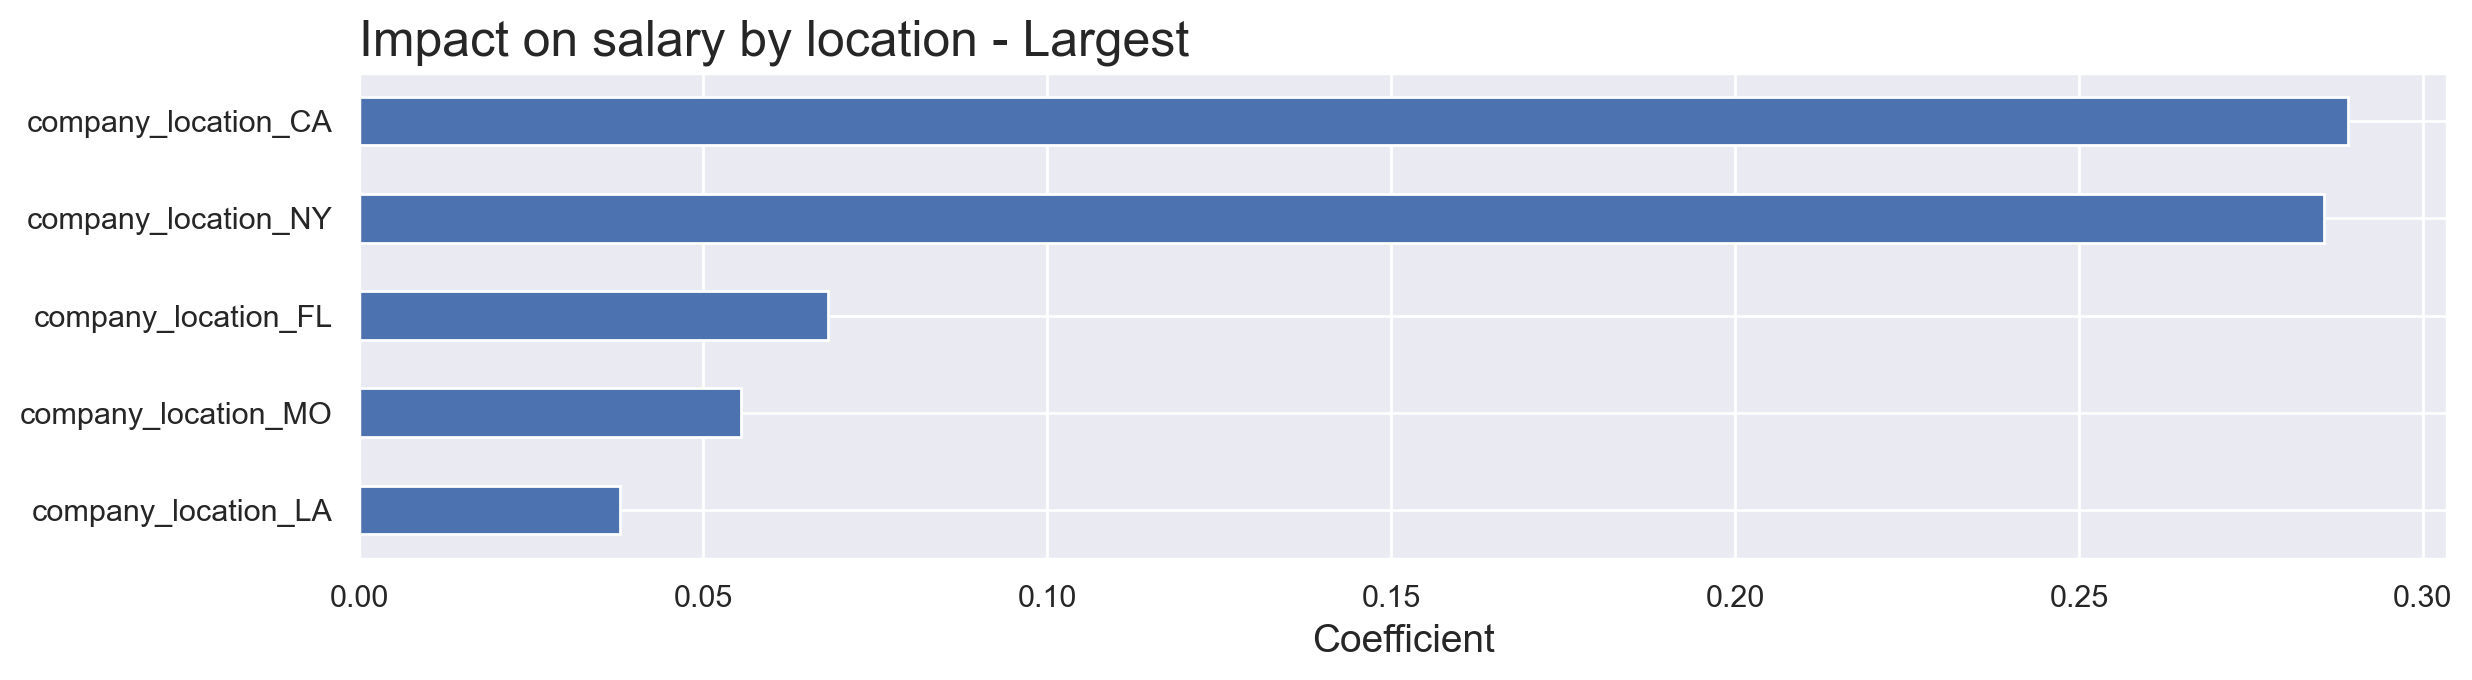

In [262]:
# Plotting the coefficients
plt.figure(figsize=(12,3))
plt.title('Impact on salary by location - Largest', loc='left', fontsize = 18)
plt.xlabel('Coefficient', fontsize = 14)

rf_coef['importance'].sort_values(ascending = True).tail(5).plot(kind='barh');

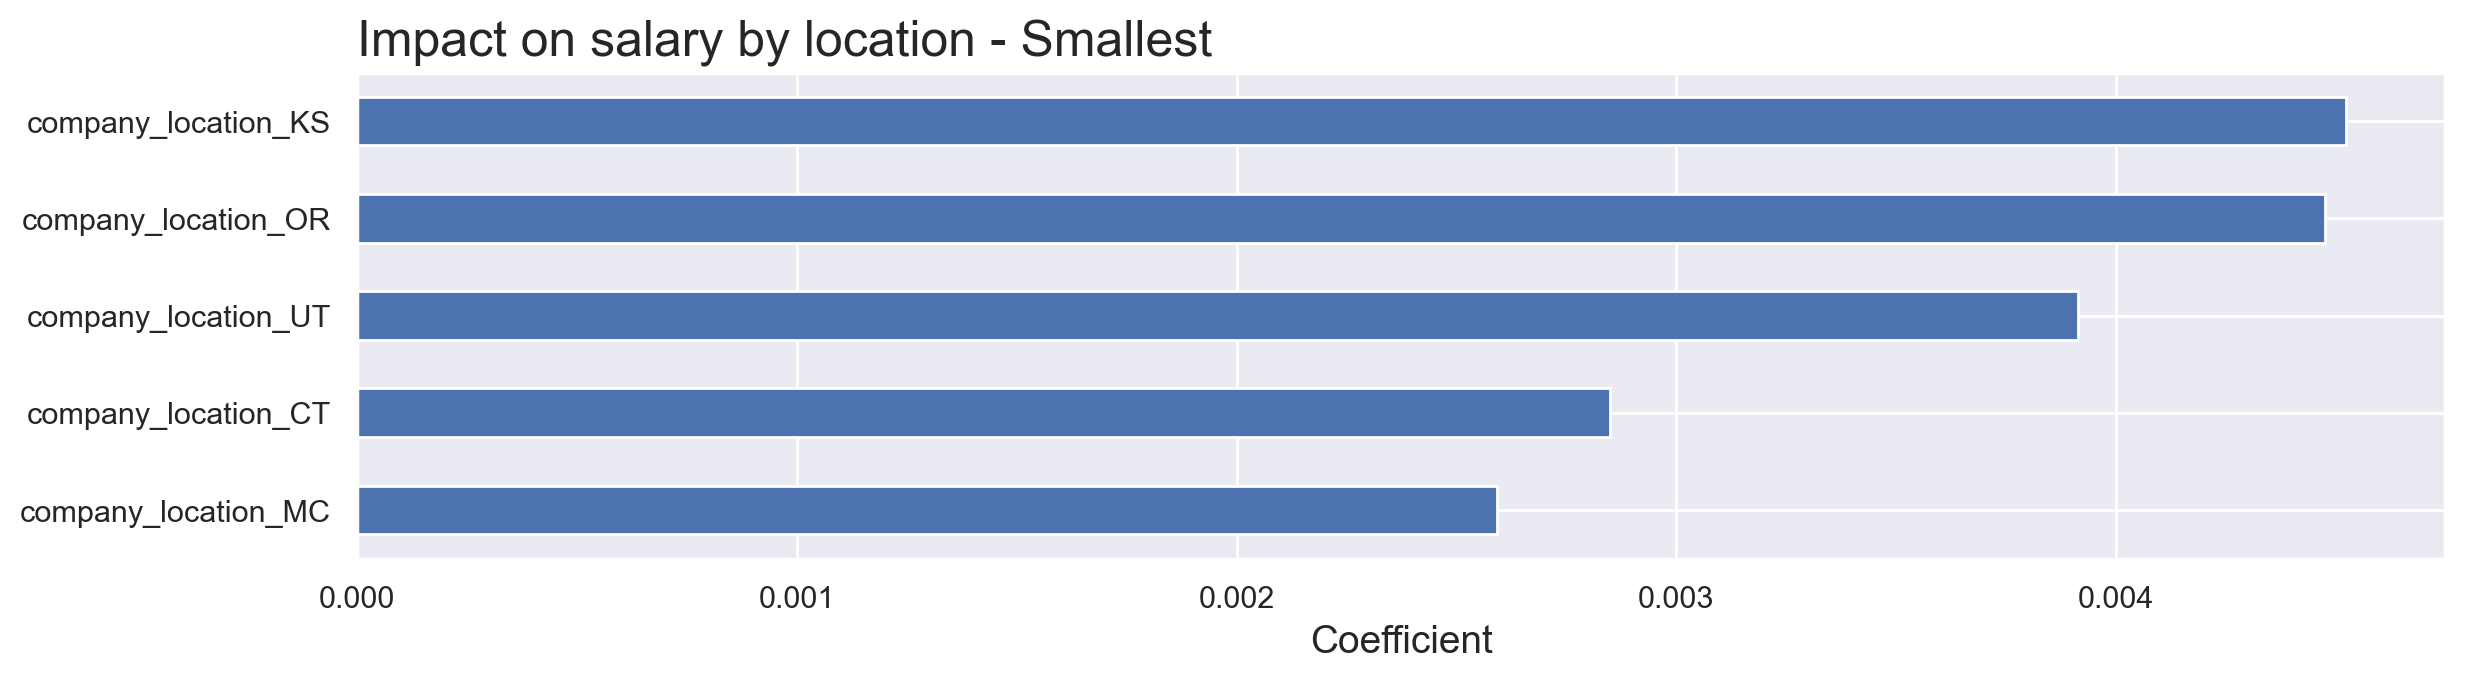

In [263]:
# Plotting the coefficients
plt.figure(figsize=(12,3))
plt.title('Impact on salary by location - Smallest', loc='left', fontsize = 18)
plt.xlabel('Coefficient', fontsize = 14)

rf_coef['importance'].sort_values(ascending = True).head(5).plot(kind='barh');

Feature importance in Random Forest is based on node impurity and describes the size of the relationship between a predictor and the target variable.  
In this model, the states of **California**, **New York** and **Florida** have the highest values, indicating that these locations have the largest impact on salaries.  
On the other side, **Massachusetts**, **Connecticut** and **Utah** have the smallest impact on salaries.
<br/><br/>

Classification Report

In [264]:
predictions = rf_best.predict(X_test)

print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.57      0.53      0.55      1216
           1       0.56      0.59      0.58      1216

    accuracy                           0.56      2432
   macro avg       0.56      0.56      0.56      2432
weighted avg       0.56      0.56      0.56      2432



Confusion Matrix

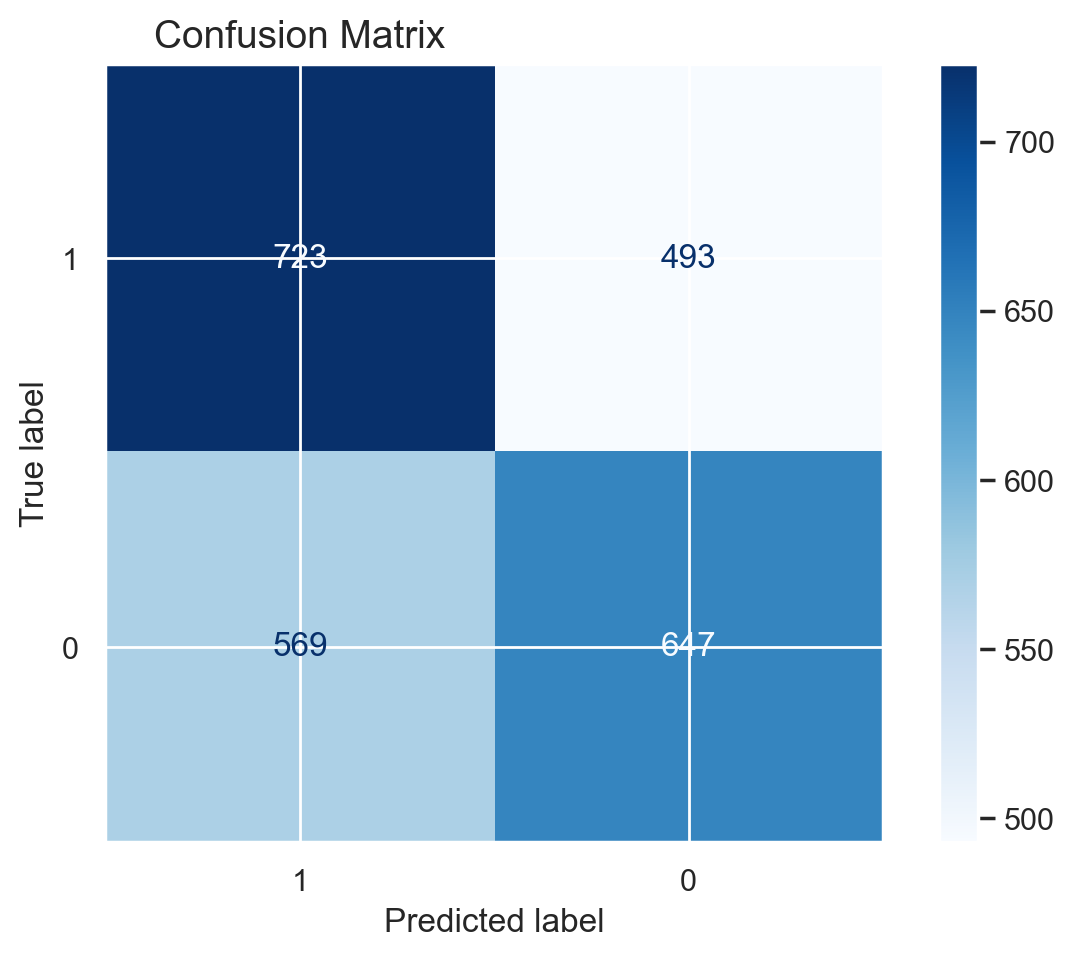

In [265]:
plot_confusion_matrix(rf_best, X_test, y_test, cmap='Blues', labels=[1, 0])
plt.title('Confusion Matrix', x = 0.25, fontsize = 14)
plt.show()

ROC-AUC Curve

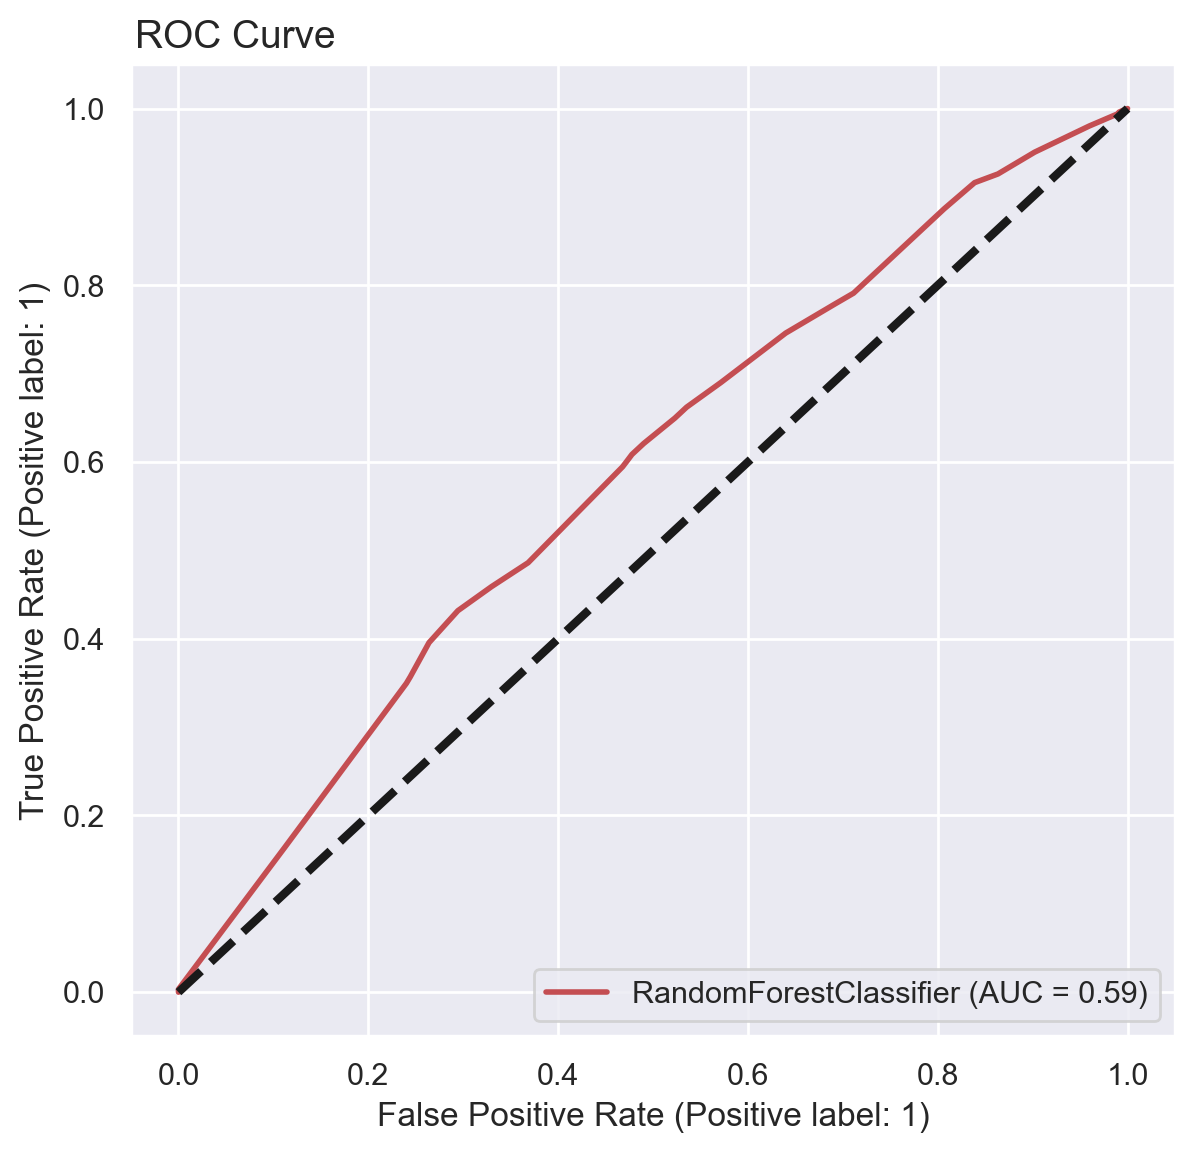

In [266]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_roc_curve(rf_best, X_test, y_test, c='r', lw=2, ax=ax)
plt.title('ROC Curve', x = 0.1, fontsize = 14)
ax.plot([0, 1], [0, 1], 'k--', lw=3)
plt.show()

In [267]:
print('ROC-AUC Score:', roc_auc_score(y_test, dt_best.predict_proba(X_test)[:, 1]))

ROC-AUC Score: 0.5855269920792936


The f1-score is balanced between the two classes, however the accuracy of the model is pretty low.  
The area under the curve is **0.59**, which tells us that this model has a bad class separation capacity.  
<br/><br/>

#### Model Scores Evaluation

In [269]:
models_1 = pd.concat([logreg_df, dt_df, rf_df], axis = 1)
models_1

Logistic Reg  Decision Tree  Random Forest
train      0.572897       0.572897       0.572897
test       0.564145       0.563322       0.563322
cv         0.568582       0.569199       0.568993

In the three models implemented above, **Decision Tree** achieved the highest CV score of **0.5691**  

The most important features for this model were **New York**, **California** and **Florida**. According to the Decision Tree Classifier, these locations have the biggest impact in predicting job salaries.

Although the Decison Tree Classifer performed the best, all the three model scores were quite close to one another, and were about 0.06 higher than the baseline of 0.5 indicating that the models made better predictions. However, it is likely that by adding other features these scores can improve.  
<br/><br/>

#### Adding additional features based on job title

In [270]:
def title_senior(row):
    if 'Senior' in row['job_title']:
        return 1
    elif 'senior' in row['job_title']:
        return 1
    elif 'Sr.' in row['job_title']:
        return 1
    elif 'sr.' in row['job_title']:
        return 1
    else:
        return 0

In [271]:
def title_junior(row):
    if 'Junior' in row['job_title']:
        return 1
    elif 'junior' in row['job_title']:
        return 1
    elif 'Jr.' in row['job_title']:
        return 1
    elif 'jr.' in row['job_title']:
        return 1
    else:
        return 0

In [272]:
def title_manager(row):
    if 'Manager' in row['job_title']:
        return 1
    elif 'manager' in row['job_title']:
        return 1
    else:
        return 0

In [273]:
def title_principal(row):
    if 'Principal' in row['job_title']:
        return 1
    elif 'principal' in row['job_title']:
        return 1
    else:
        return 0

In [274]:
def title_director(row):
    if 'Director' in row['job_title']:
        return 1
    elif 'director' in row['job_title']:
        return 1
    else:
        return 0

In [275]:
def title_lead(row):
    if 'Lead' in row['job_title']:
        return 1
    elif 'lead' in row['job_title']:
        return 1
    elif 'Leader' in row['job_title']:
        return 1
    elif 'leader' in row['job_title']:
        return 1
    else:
        return 0

In [276]:
def title_associate(row):
    if 'Associate' in row['job_title']:
        return 1
    elif 'associate' in row['job_title']:
        return 1
    else:
        return 0

In [277]:
def title_engineer(row):
    if 'Engineer' in row['job_title']:
        return 1
    elif 'engineer' in row['job_title']:
        return 1
    else:
        return 0

In [278]:
def title_scientist(row):
    if 'Scientist' in row['job_title']:
        return 1
    elif 'scientist' in row['job_title']:
        return 1
    else:
        return 0

In [279]:
def title_specialist(row):
    if 'Specialist' in row['job_title']:
        return 1
    elif 'specialist' in row['job_title']:
        return 1
    else:
        return 0

In [280]:
def title_researcher(row):
    if 'Researcher' in row['job_title']:
        return 1
    elif 'researcher' in row['job_title']:
        return 1
    else:
        return 0

In [281]:
def title_consultant(row):
    if 'Consultant' in row['job_title']:
        return 1
    elif 'consultant' in row['job_title']:
        return 1
    else:
        return 0

In [282]:
def title_analyst(row):
    if 'Analyst' in row['job_title']:
        return 1
    elif 'analyst' in row['job_title']:
        return 1
    else:
        return 0

In [283]:
def title_architect(row):
    if 'Architect' in row['job_title']:
        return 1
    elif 'architect' in row['job_title']:
        return 1
    else:
        return 0

In [284]:
def title_postdoc(row):
    if 'Postdoc' in row['job_title']:
        return 1
    elif 'postdoc' in row['job_title']:
        return 1
    elif 'Post-doc' in row['job_title']:
        return 1
    elif 'post-doc' in row['job_title']:
        return 1
    elif 'Postdoctoral' in row['job_title']:
        return 1
    elif 'Post Doctoral' in row['job_title']:
        return 1
    else:
        return 0

In [285]:
def title_coordinator(row):
    if 'Coordinator' in row['job_title']:
        return 1
    elif 'coordinator' in row['job_title']:
        return 1
    elif 'Co-ordinator' in row['job_title']:
        return 1
    elif 'co-ordinator' in row['job_title']:
        return 1
    else:
        return 0

In [286]:
def title_supervisor(row):
    if 'Supervisor' in row['job_title']:
        return 1
    elif 'supervisor' in row['job_title']:
        return 1
    else:
        return 0

In [287]:
def title_president(row):
    if 'President' in row['job_title']:
        return 1
    elif 'president' in row['job_title']:
        return 1
    else:
        return 0

In [288]:
def title_developer(row):
    if 'Developer' in row['job_title']:
        return 1
    elif 'developer' in row['job_title']:
        return 1
    else:
        return 0

In [289]:
def title_designer(row):
    if 'Designer' in row['job_title']:
        return 1
    elif 'designer' in row['job_title']:
        return 1
    else:
        return 0

In [290]:
def title_assistant(row):
    if 'Assistant' in row['job_title']:
        return 1
    elif 'assistant' in row['job_title']:
        return 1
    else:
        return 0

In [291]:
# Creating the new columns and applying the functions
df['title_senior'] = df.apply(lambda row: title_senior(row), axis=1)
df['title_junior'] = df.apply(lambda row: title_junior(row), axis=1)
df['title_manager'] = df.apply(lambda row: title_manager(row), axis=1)
df['title_principal'] = df.apply(lambda row: title_principal(row), axis=1)
df['title_director'] = df.apply(lambda row: title_director(row), axis=1)
df['title_lead'] = df.apply(lambda row: title_lead(row), axis=1)
df['title_associate'] = df.apply(lambda row: title_associate(row), axis=1)
df['title_engineer'] = df.apply(lambda row: title_engineer(row), axis=1)
df['title_scientist'] = df.apply(lambda row: title_scientist(row), axis=1)
df['title_specialist'] = df.apply(lambda row: title_specialist(row), axis=1)
df['title_researcher'] = df.apply(lambda row: title_researcher(row), axis=1)
df['title_consultant'] = df.apply(lambda row: title_consultant(row), axis=1)
df['title_analyst'] = df.apply(lambda row: title_analyst(row), axis=1)
df['title_architect'] = df.apply(lambda row: title_architect(row), axis=1)
df['title_postdoc'] = df.apply(lambda row: title_postdoc(row), axis=1)
df['title_coordinator'] = df.apply(lambda row: title_coordinator(row), axis=1)
df['title_supervisor'] = df.apply(lambda row: title_supervisor(row), axis=1)
df['title_president'] = df.apply(lambda row: title_president(row), axis=1)
df['title_developer'] = df.apply(lambda row: title_developer(row), axis=1)
df['title_designer'] = df.apply(lambda row: title_designer(row), axis=1)
df['title_assistant'] = df.apply(lambda row: title_assistant(row), axis=1)


In [292]:
df_dum = pd.get_dummies(df, columns=['company_location'])
df_dum.drop(columns=['job_title', 'salary_amount'], inplace=True)
df_dum.head()

high_salary  title_senior  title_junior  title_manager  title_principal  \
0            1             1             0              0                0   
1            1             1             0              0                0   
2            1             1             0              0                0   
3            1             0             0              0                1   
4            1             1             0              0                0   

   title_director  title_lead  title_associate  title_engineer  \
0               0           0                0               1   
1               0           0                0               1   
2               0           0                0               1   
3               0           0                0               1   
4               0           0                0               1   

   title_scientist  ...  company_location_NM  company_location_NY  \
0                0  ...                    1                    0   
1                0  ...                    1                    0   
2                0  ...                    1                    0   
3                0  ...                    1                    0   
4                0  ...                    1                    0   

   company_location_OH  company_location_OR  company_location_PA  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    0                    0   

   company_location_SC  company_location_TN  company_location_TX  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    0                    0   

   company_location_UT  company_location_WA  
0                    0                    0  
1                    0                    0  
2                    0                    0  
3                    0                    0  
4                    0                    0  

[5 rows x 53 columns]

In [293]:
# Choosing target and predictor variables
y = df_dum.pop('high_salary')
X = df_dum

In [294]:
# Creating train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [295]:
scaler = StandardScaler()

# Rescaling variables
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

#### Logistic Regression

In [297]:
# Instantiating the model 
logreg = LogisticRegression(solver='saga', multi_class='auto', max_iter=1000)

# Fitting the model
logreg.fit(X_train, y_train)

# Calculating scores
new_logreg_train = logreg.score(X_train, y_train)
new_logreg_test = logreg.score(X_test, y_test)
new_logreg_cv = (cross_val_score(logreg, X_train, y_train, cv = 10)).mean()

# Collecting the scores in a dataframe to compare different models later
new_logreg_df = pd.DataFrame([new_logreg_train, new_logreg_test, new_logreg_cv], index = ['train', 'test', 'cv'], columns=['Logistic Reg'])

print('Logistic Regression Scores: \n')
print('train score: ', new_logreg_train)
print('test score: ', new_logreg_test)
print('CV score: ', new_logreg_cv)

Logistic Regression Scores: 

train score:  0.7398725066831174
test score:  0.7425986842105263
CV score:  0.7342123126895308


Feature Importance & Model Coefficients

In [298]:
# Collecting the model coefficients in a dataframe
lr_coef = pd.DataFrame(logreg.coef_[0], index=X_train.columns, columns=['coefficients'])
lr_coef.sort_values(by = 'coefficients', ascending = False)[:10]

coefficients
title_engineer           0.619047
title_director           0.499633
title_senior             0.435307
title_architect          0.401082
title_president          0.315671
title_lead               0.305980
company_location_NY      0.304121
title_principal          0.279661
company_location_CA      0.224028
title_scientist          0.207105

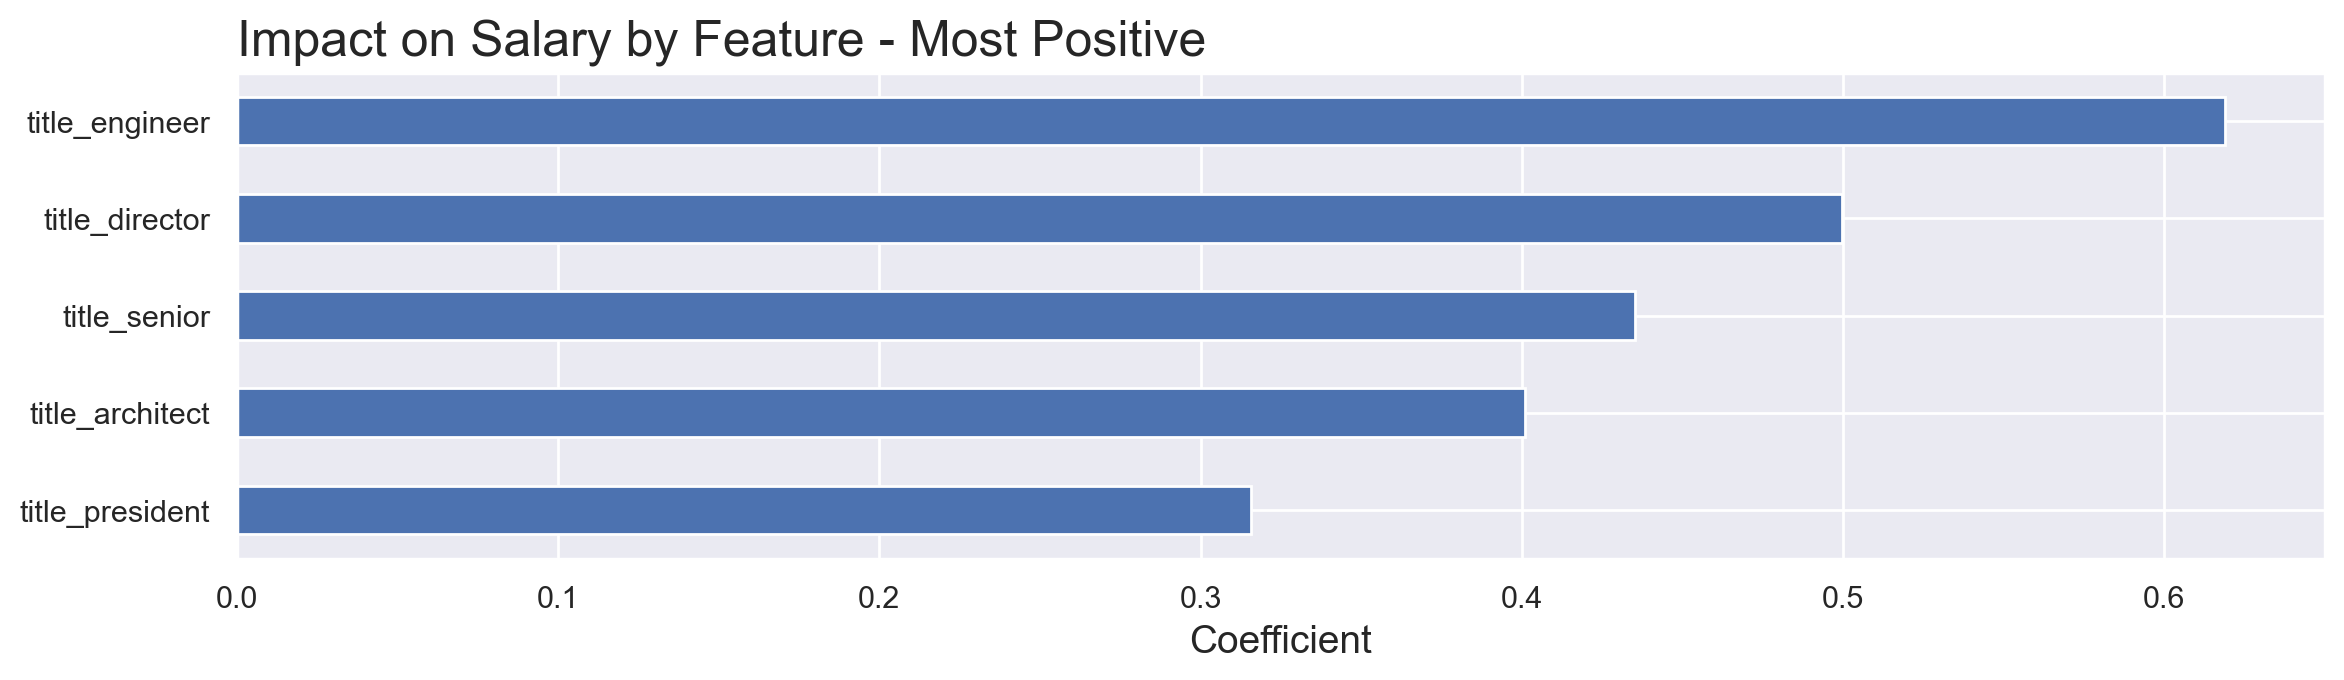

In [301]:
# Plotting the coefficients
plt.figure(figsize=(12,3))
plt.title('Impact on Salary by Feature - Most Positive', loc='left', fontsize = 18)
plt.xlabel('Coefficient', fontsize = 14)

lr_coef['coefficients'].sort_values(ascending = True).tail(5).plot(kind='barh');

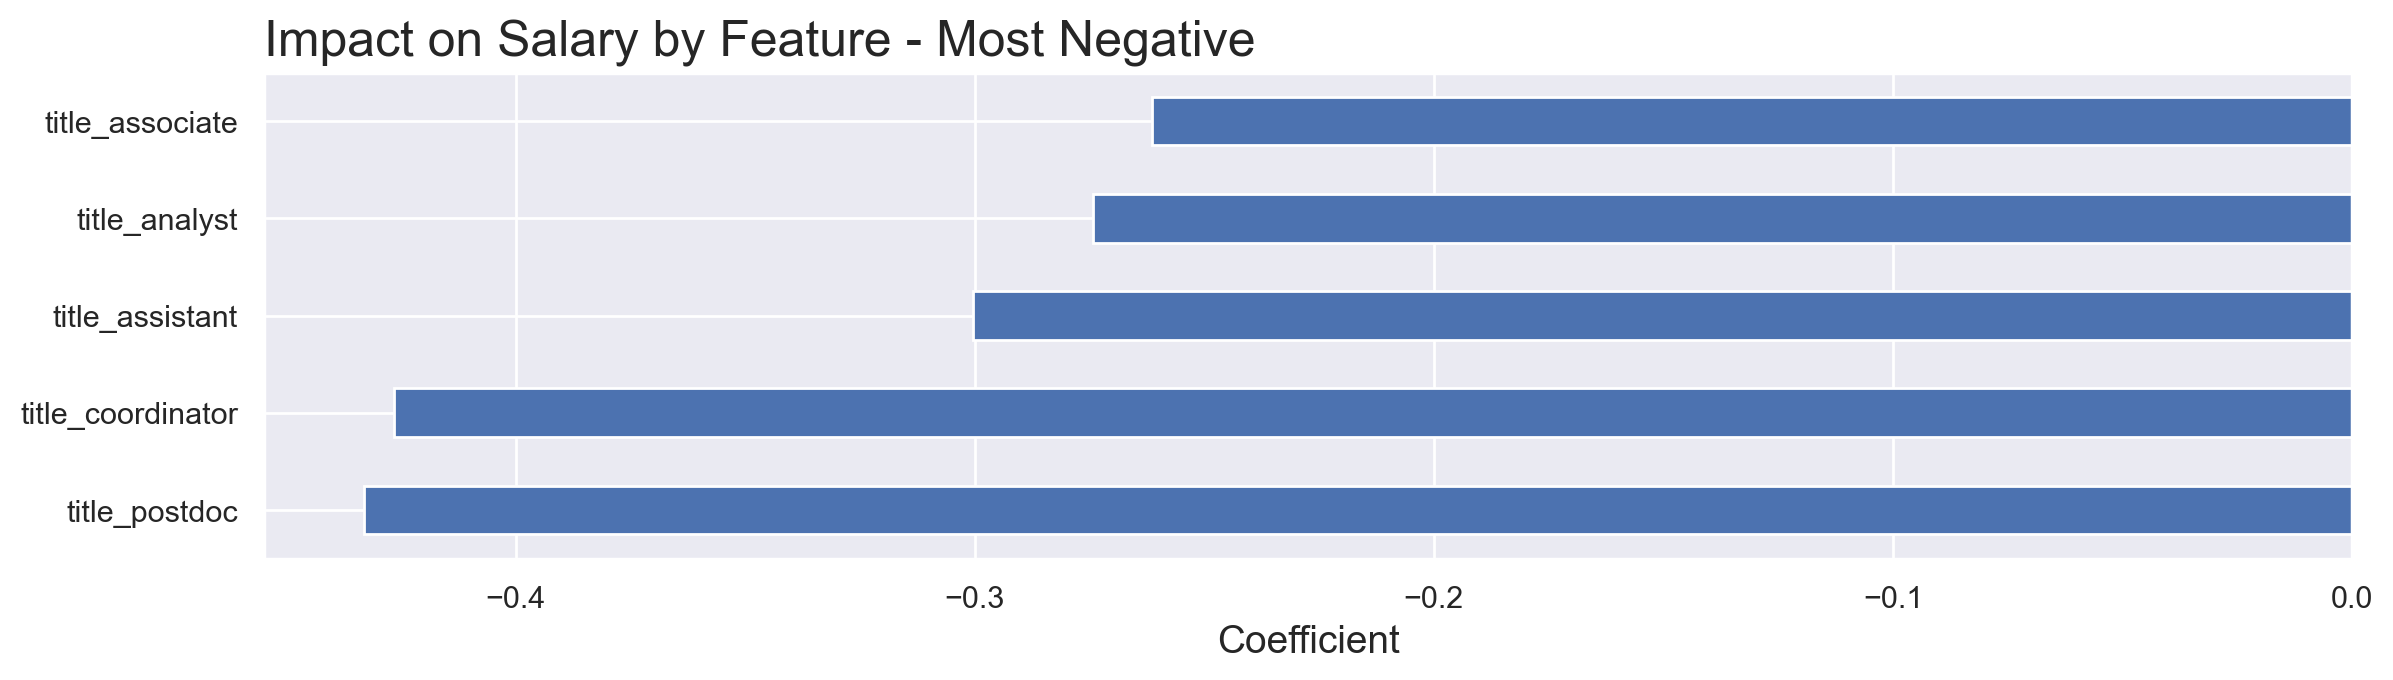

In [302]:
# Plotting the coefficients
plt.figure(figsize=(12,3))
plt.title('Impact on Salary by Feature - Most Negative', loc='left', fontsize = 18)
plt.xlabel('Coefficient', fontsize = 14)

lr_coef['coefficients'].sort_values(ascending = True).head(5).plot(kind='barh');

Logistic Regression coeffients describe the size and the direction of the relationship between a predictor and the target variable.  
In this model, the features **title_engineer**, **title_director** and **title_senior** has a large influence on having a high paying salary since their coefficients are positive and relatively large.  
On the other side, **title_postdoc**, **title_coordinator** and **title_assistant** have negative and relatively large coefficients, so these features would likely predict a salary well below median.
<br/><br/>

Classification Report

In [303]:
predictions = logreg.predict(X_test)

print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.78      0.69      0.73      1232
           1       0.71      0.80      0.75      1200

    accuracy                           0.74      2432
   macro avg       0.75      0.74      0.74      2432
weighted avg       0.75      0.74      0.74      2432



Confusion Matrix

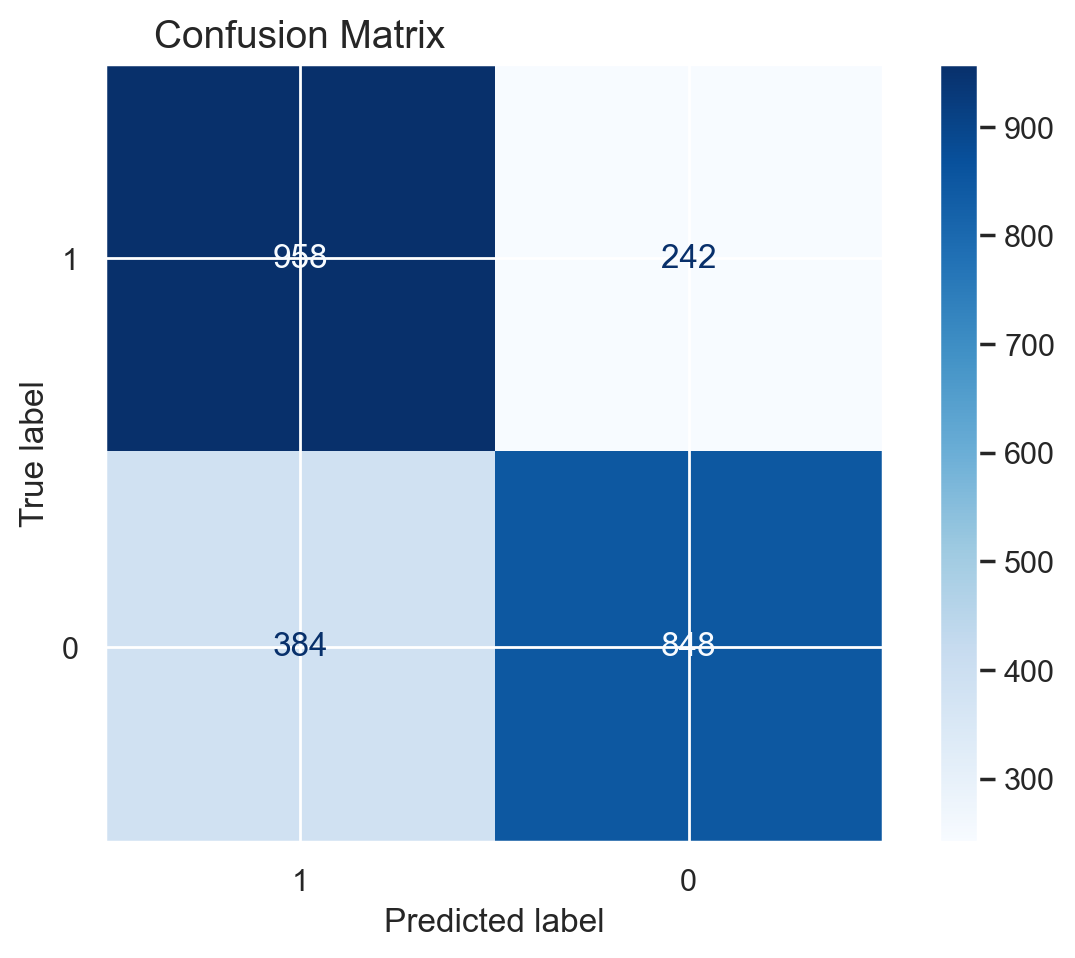

In [304]:
plot_confusion_matrix(logreg, X_test, y_test, cmap='Blues', labels=[1, 0])
plt.title('Confusion Matrix', x = 0.25, fontsize = 14)
plt.show()

ROC-AUC Curve

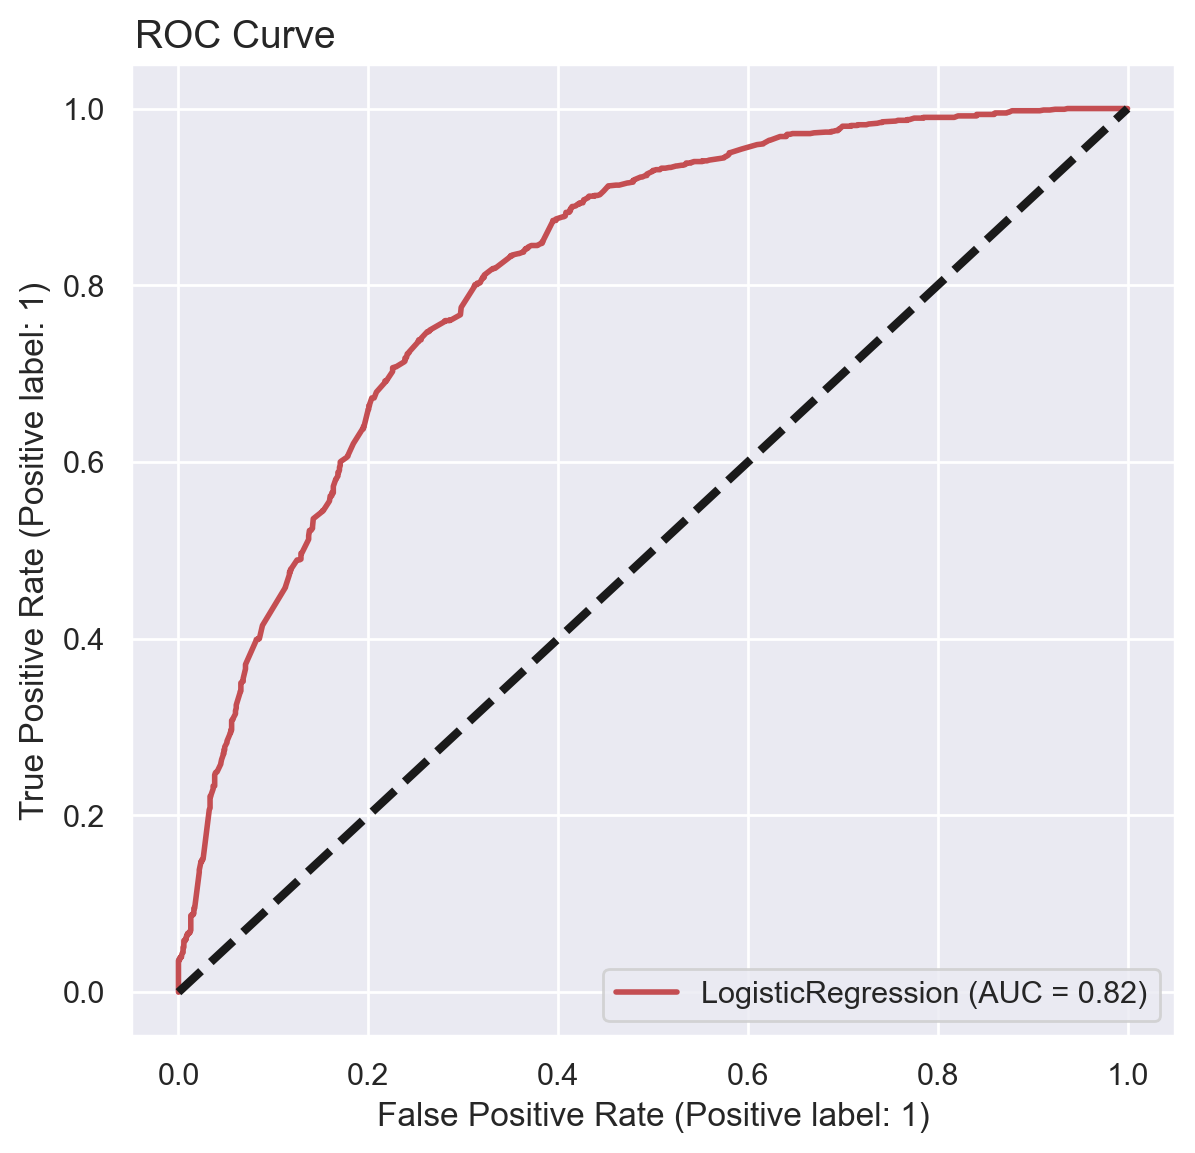

In [305]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_roc_curve(logreg, X_test, y_test, c='r', lw=2, ax=ax)
plt.title('ROC Curve', x = 0.1, fontsize = 14)
ax.plot([0, 1], [0, 1], 'k--', lw=3)
plt.show()

In [306]:
print('ROC-AUC Score:', roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1]))

ROC-AUC Score: 0.8156703192640692


Precision-Recall Curve

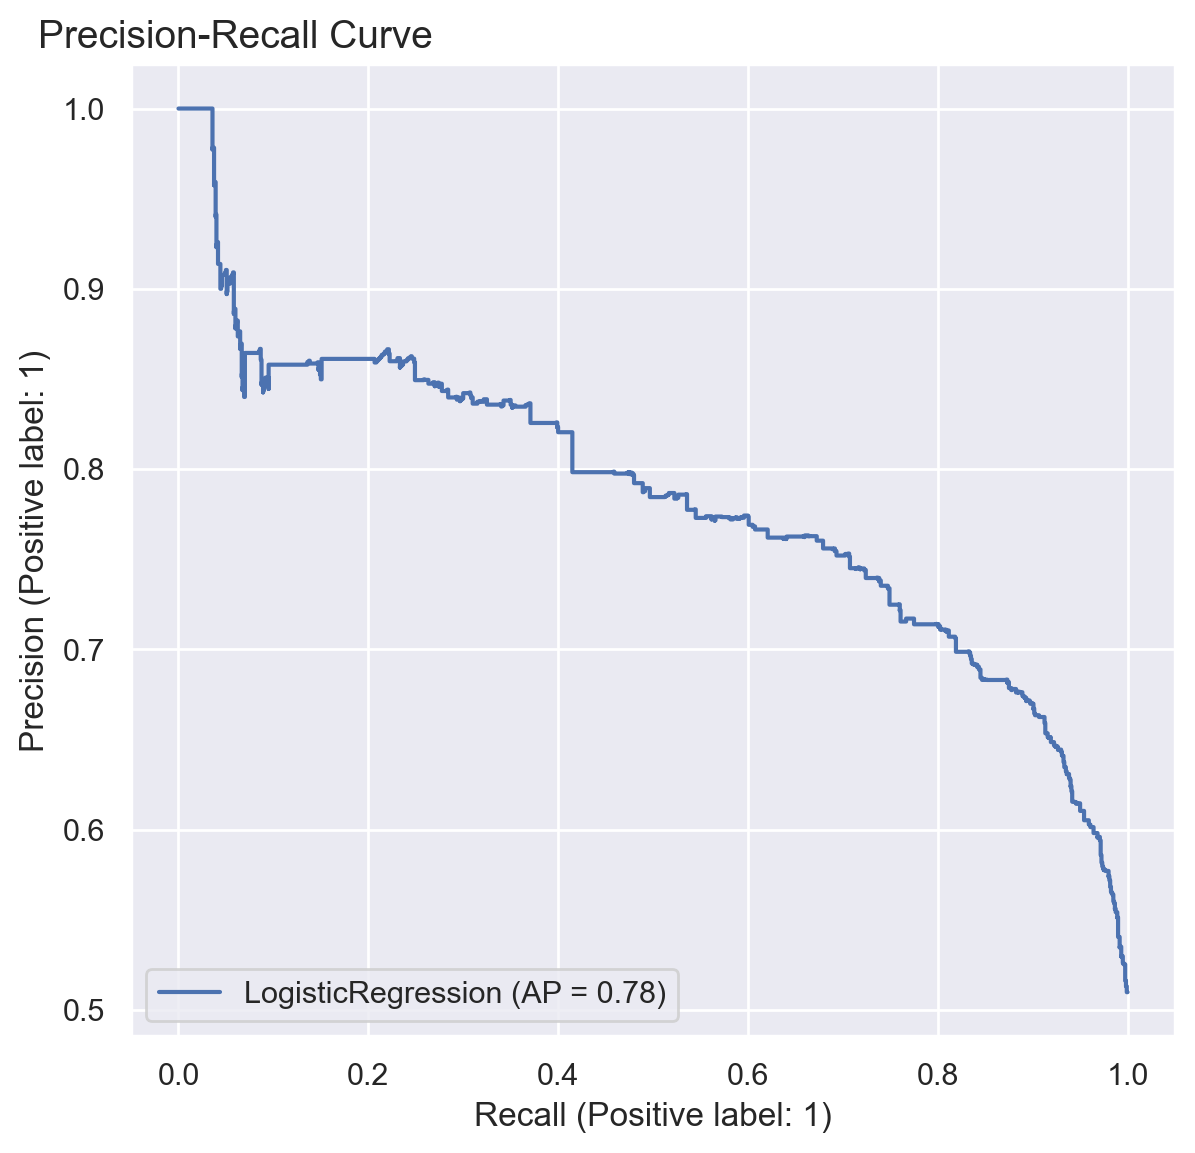

In [331]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_precision_recall_curve(logreg, X_test, y_test, ax=ax)
plt.title('Precision-Recall Curve', x = 0.1, fontsize = 14)
plt.show()

The f1-score is balanced between the two classes, and the accuracy of the model is fairly good.  
The ROC area under the curve is **0.82**, which tells us that this model has a good class separation capacity.  
The precision-recall curve shows the tradeoff between precision and recall for different threshold; here the PR-AUC is **0.78**, the curve descends in a typical non-monotonic fashion, and the precision decreases significantly at **0.75** when recall is around **0.7**.  
<br/><br/>

#### Decision Tree with Grid Search CV

In [307]:
# define gridsearch parameters
dtree_params = {
    'max_depth': list(range(1, 11))+[None],
    'max_features': [None, 1, 2, 3],
    'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50],
    'ccp_alpha': [0, 0.001, 0.005, 0.01]}


# define the model
dtree = DecisionTreeClassifier(random_state = 1)

# instantiate the gridsearch
dtc_gs = GridSearchCV(dtree, dtree_params, cv=5, n_jobs=10, verbose=1)

# find the fit in the gridsearch
dtc_gs.fit(X_train, y_train)

# pull out the model with the best parameters found in the gridsearch
dt_best = dtc_gs.best_estimator_

# calculate scores
new_dt_train = dt_best.score(X_train, y_train)
new_dt_test = dt_best.score(X_test, y_test)
new_dt_cv = (cross_val_score(dt_best, X_train, y_train, cv = 10)).mean()

# collect the scores in a dataframe to compare different models later
new_dt_df = pd.DataFrame([new_dt_train, new_dt_test, new_dt_cv], index = ['train', 'test', 'cv'], columns = ['Decision Tree'])

print('Decision Tree Classifier Scores: \n')
print('train score: ', new_dt_train)
print('test score: ', new_dt_test)
print('CV score: ', new_dt_cv)

Fitting 5 folds for each of 1936 candidates, totalling 9680 fits
Decision Tree Classifier Scores: 

train score:  0.7598190417437796
test score:  0.7405427631578947
CV score:  0.733495954559104


Feature Importance & Model Coefficients

In [312]:
# Collecting the model coefficients in a dataframe
dt_coef = pd.DataFrame(dt_best.feature_importances_, columns=['importance'], index=X.columns)
dt_coef.sort_values(by = 'importance', ascending = False)[:10]

importance
title_engineer         0.247441
title_director         0.082206
title_architect        0.068876
title_senior           0.055401
title_scientist        0.054926
title_lead             0.049433
company_location_NY    0.046410
title_principal        0.041179
title_manager          0.036468
company_location_CA    0.033329

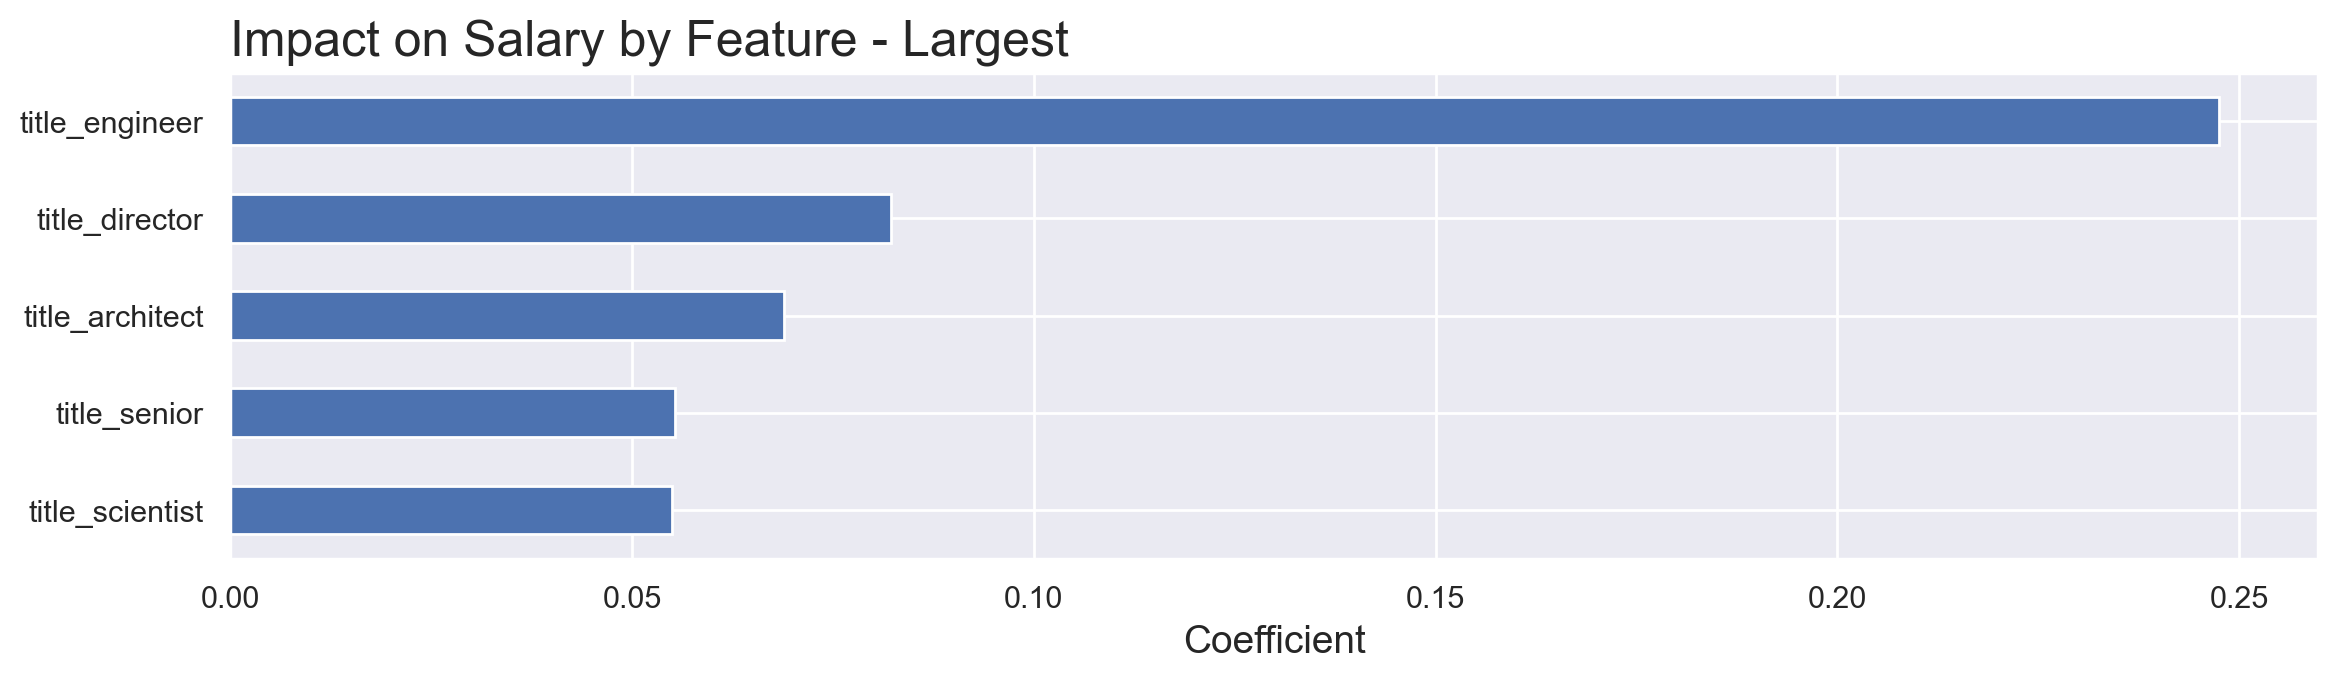

In [309]:
# Plotting the coefficients
plt.figure(figsize=(12,3))
plt.title('Impact on Salary by Feature - Largest', loc='left', fontsize = 18)
plt.xlabel('Coefficient', fontsize = 14)

dt_coef['importance'].sort_values(ascending = True).tail(5).plot(kind='barh');

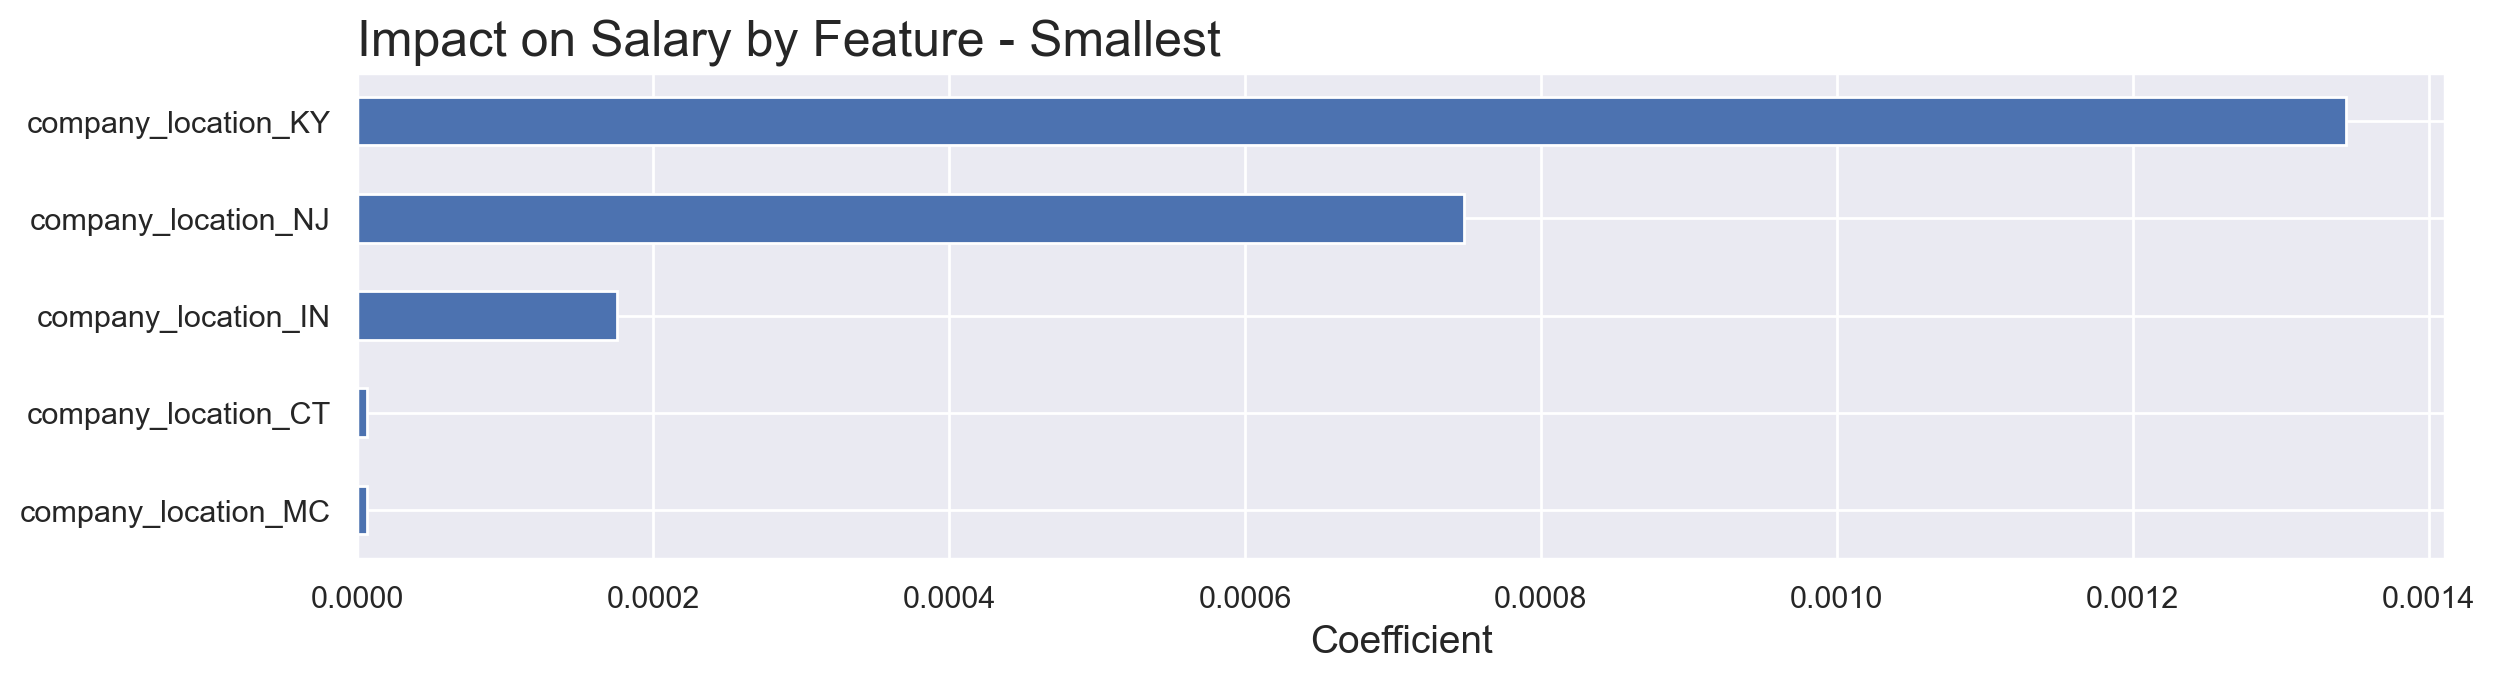

In [310]:
# Plotting the coefficients
plt.figure(figsize=(12,3))
plt.title('Impact on Salary by Feature - Smallest', loc='left', fontsize = 18)
plt.xlabel('Coefficient', fontsize = 14)

dt_coef['importance'].sort_values(ascending = True).head(5).plot(kind='barh');

Feature importance in Decision Tree is based on node impurity and describes the size of the relationship between a predictor and the target variable.  
In this model, **title_engineer**, **title_director** and **title_architect** have the highest values, indicating that these features have the largest impact on salaries.  
On the other side, **company_location_MC**, **company_location_CT** and **company_location_IN** have the smallest impact on salaries.
<br/><br/>

Classification Report

In [313]:
predictions = dt_best.predict(X_test)

print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.77      0.70      0.73      1232
           1       0.72      0.78      0.75      1200

    accuracy                           0.74      2432
   macro avg       0.74      0.74      0.74      2432
weighted avg       0.74      0.74      0.74      2432



Confusion Matrix

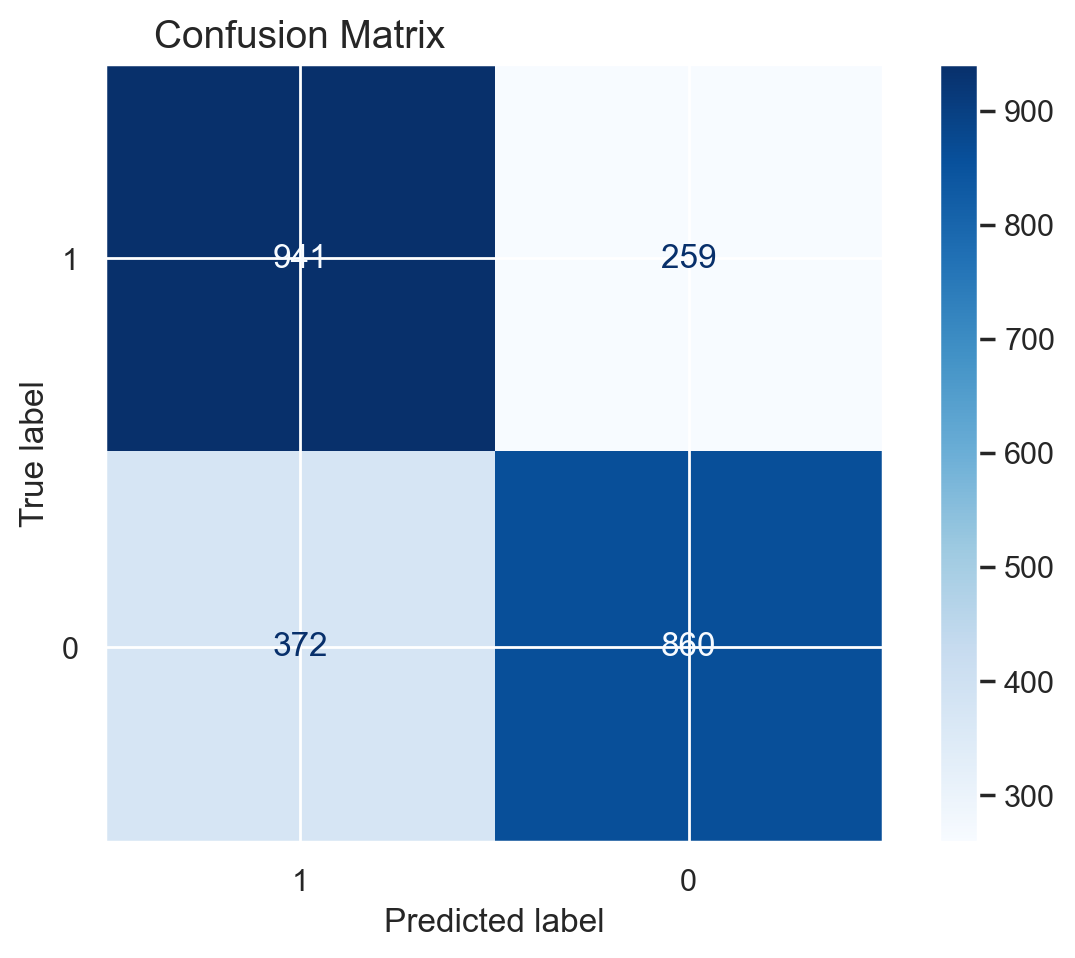

In [314]:
plot_confusion_matrix(dt_best, X_test, y_test, cmap='Blues', labels=[1, 0])
plt.title('Confusion Matrix', x = 0.25, fontsize = 14)
plt.show()

ROC-AUC Curve

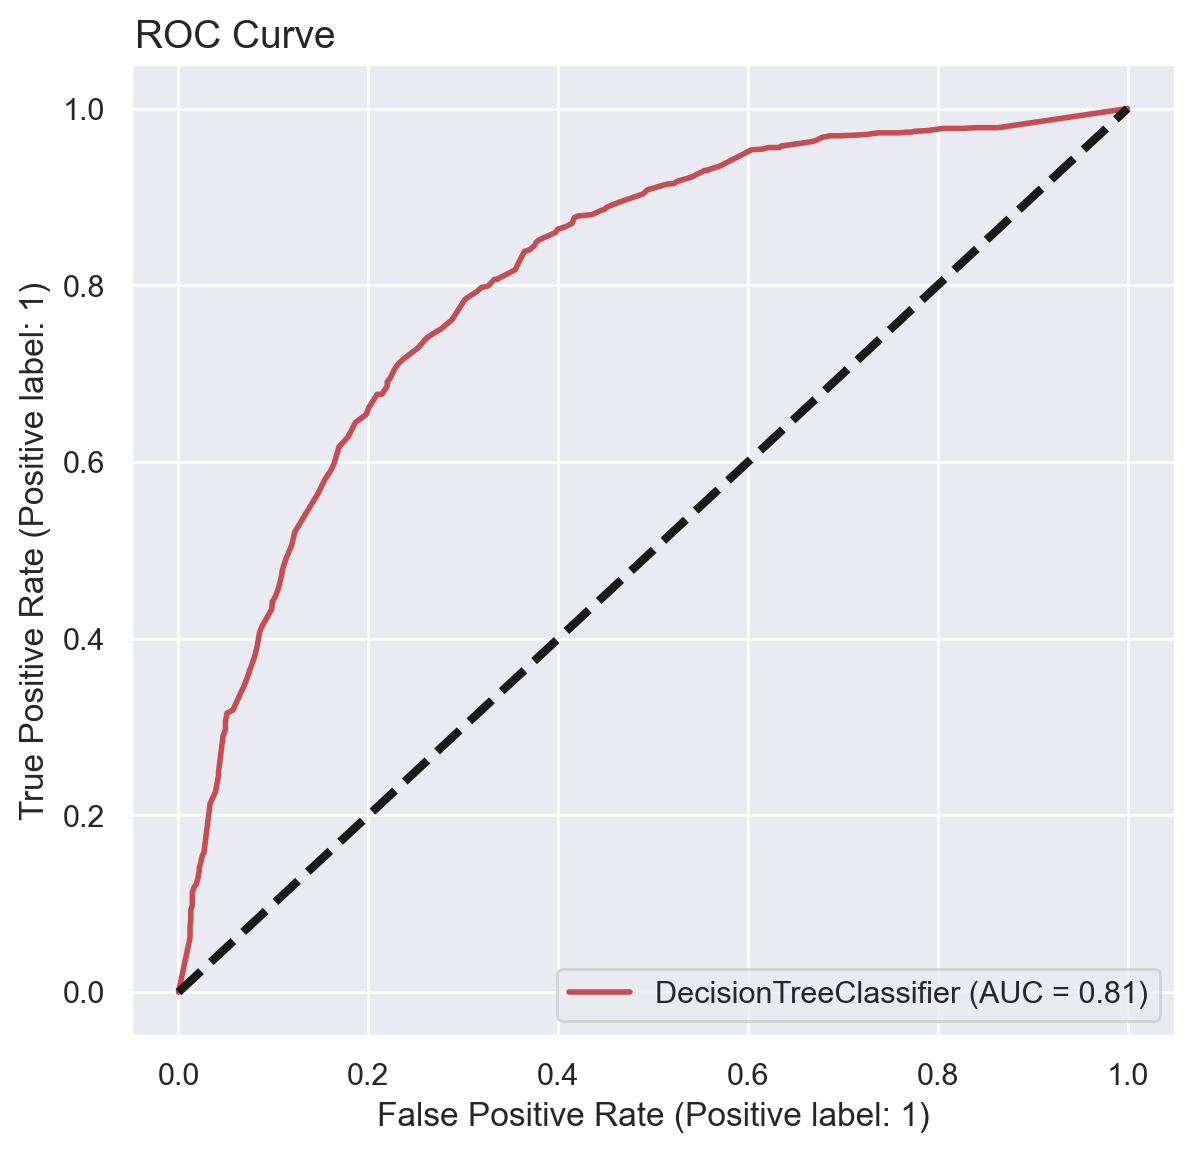

In [315]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_roc_curve(dt_best, X_test, y_test, c='r', lw=2, ax=ax)
plt.title('ROC Curve', x = 0.1, fontsize = 14)
ax.plot([0, 1], [0, 1], 'k--', lw=3)
plt.show()

In [316]:
print('ROC-AUC Score:', roc_auc_score(y_test, dt_best.predict_proba(X_test)[:, 1]))

ROC-AUC Score: 0.8094206574675327


Precision-Recall Curve

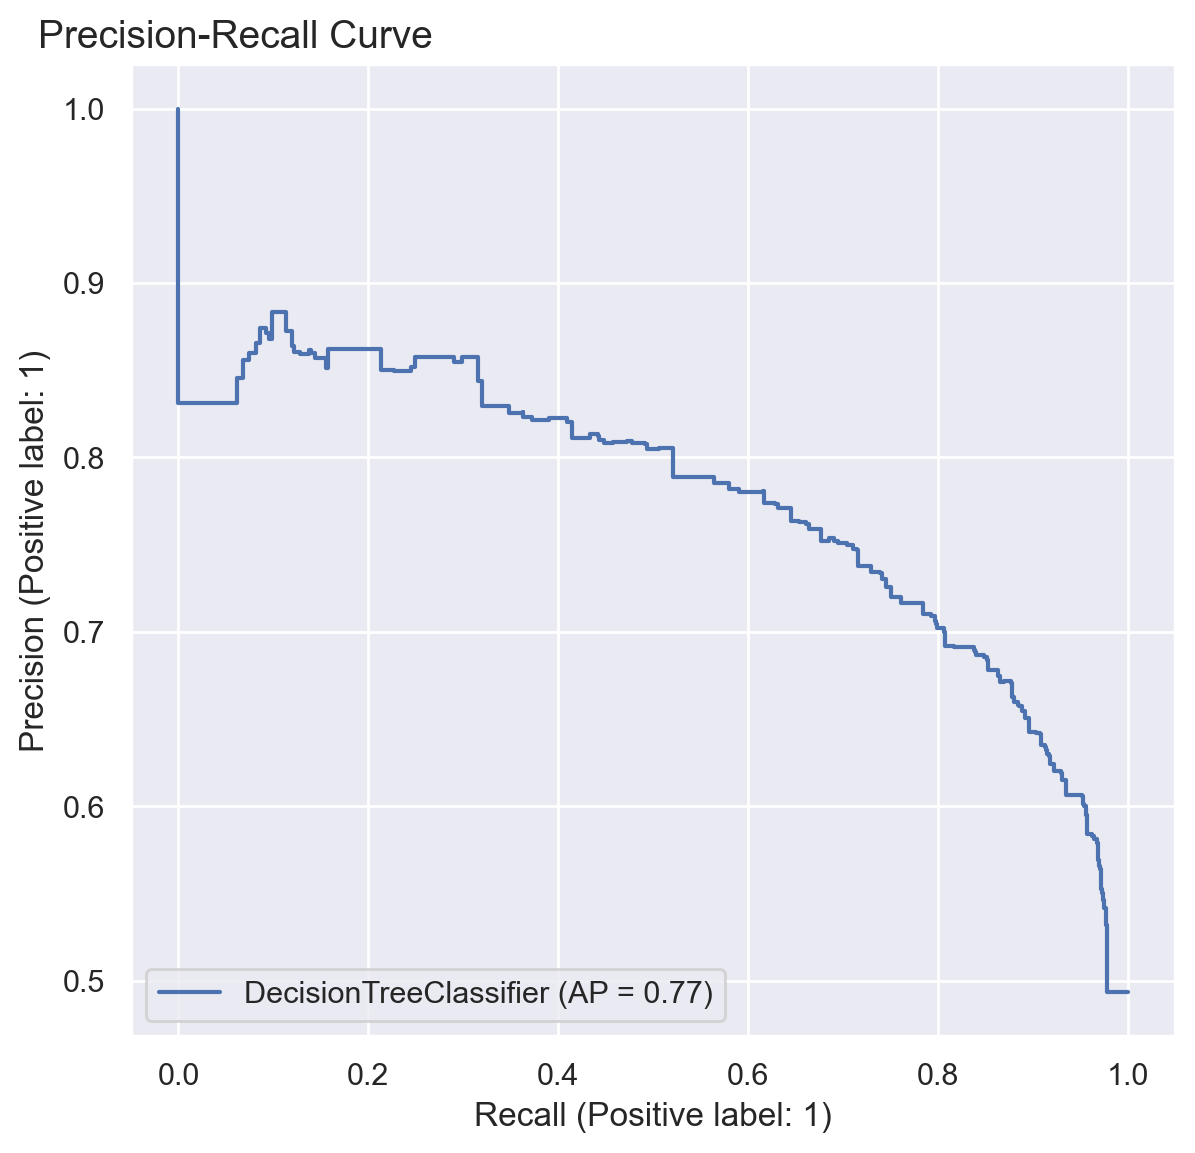

In [332]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_precision_recall_curve(dt_best, X_test, y_test, ax=ax)
plt.title('Precision-Recall Curve', x = 0.1, fontsize = 14)
plt.show()

The f1-score is balanced between the two classes, and the accuracy of the model is fairly good.  
The area under the curve is **0.81**, which tells us that this model has a good class separation capacity.  
The precision-recall curve shows the tradeoff between precision and recall for different threshold; here the PR-AUC is **0.77**, the curve descends in a typical non-monotonic fashion, and the precision decreases significantly at **0.75** when recall is around **0.7**.  
<br/><br/>

#### Random Forest with Grid Search CV

In [317]:
# define gridsearch parameters
randf_params = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': list(range(1, 11))+[None],
    'max_features': [None, 1, 2, 3, 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 3, 5, 7]}

# define the model
randf = RandomForestClassifier(random_state = 1)

# instantiate the gridsearch
rfc_gs = GridSearchCV(randf, randf_params, cv=5, n_jobs=10, verbose=1)

# find the fit in the gridsearch
rfc_gs.fit(X_train, y_train)

# pull out the model with the best parameters found in the gridsearch
rf_best = rfc_gs.best_estimator_

# calculate scores
new_rf_train = rf_best.score(X_train, y_train)
new_rf_test = rf_best.score(X_test, y_test)
new_rf_cv = (cross_val_score(rf_best, X_train, y_train, cv = 10)).mean()

# collect the scores in a dataframe to compare different models later
new_rf_df = pd.DataFrame([new_rf_train, new_rf_test, new_rf_cv], index = ['train', 'test', 'cv'], columns = ['Random Forest'])

print('Random Forest Classifier Scores: \n')
print('train score: ', new_rf_train)
print('test score: ', new_rf_test)
print('CV score: ', new_rf_cv)

Fitting 5 folds for each of 1650 candidates, totalling 8250 fits
Random Forest Classifier Scores: 

train score:  0.7557063541024059
test score:  0.7520559210526315
CV score:  0.7382250813106129


Feature Importance & Model Coefficients 

In [318]:
# Collecting the model coefficients in a dataframe
rf_coef = pd.DataFrame(rf_best.feature_importances_, columns=['importance'], index=X.columns)
rf_coef.sort_values(by = 'importance', ascending = False)[:10]

importance
title_engineer         0.178882
title_senior           0.134930
title_director         0.072977
title_analyst          0.058214
title_architect        0.058072
company_location_NY    0.046873
title_lead             0.045935
title_principal        0.038869
title_coordinator      0.035015
title_associate        0.031042

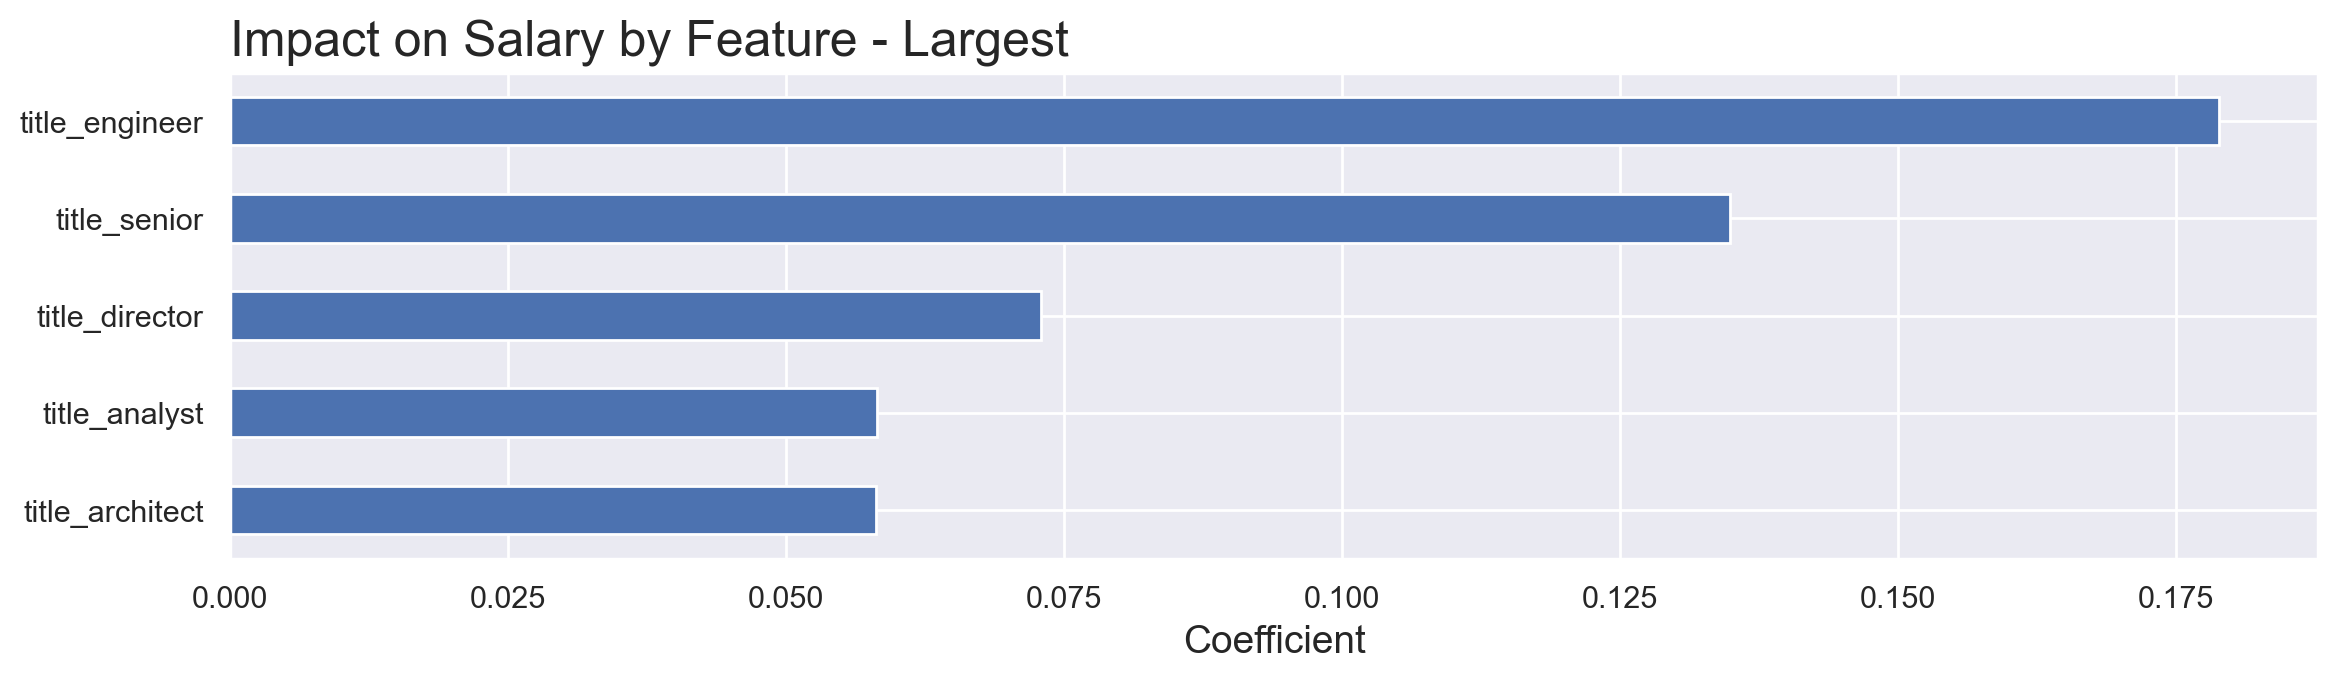

In [319]:
# Plotting the coefficients
plt.figure(figsize=(12,3))
plt.title('Impact on Salary by Feature - Largest', loc='left', fontsize = 18)
plt.xlabel('Coefficient', fontsize = 14)

rf_coef['importance'].sort_values(ascending = True).tail(5).plot(kind='barh');

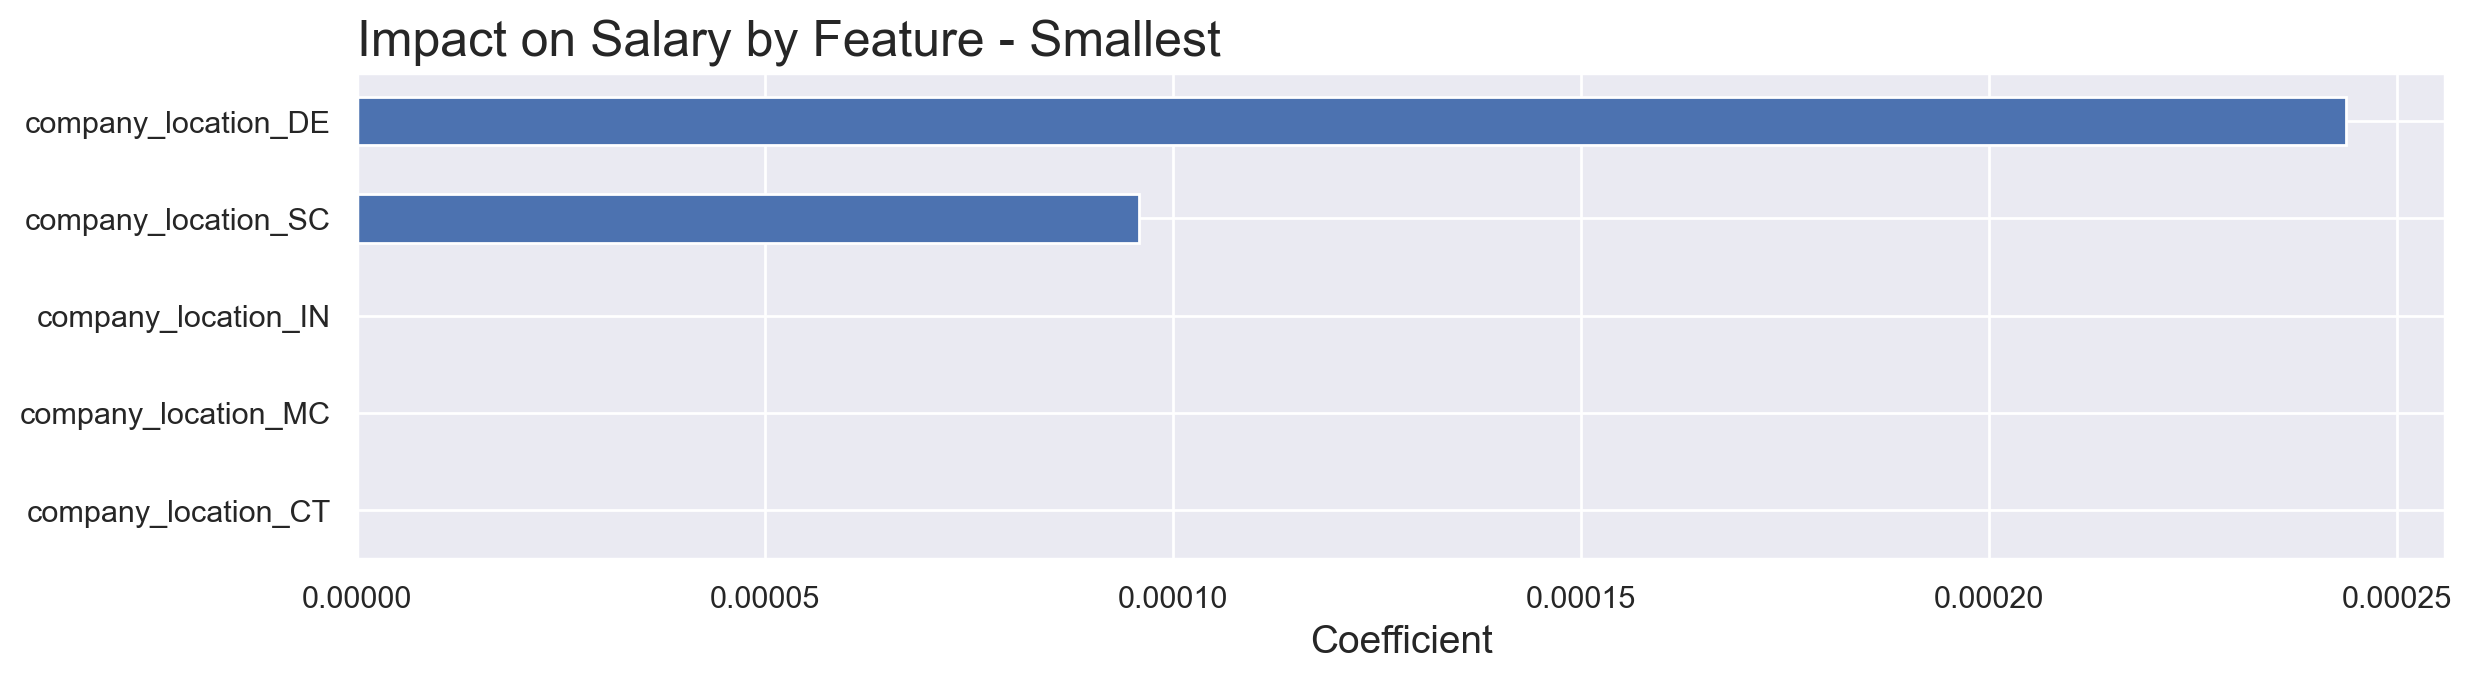

In [320]:
# Plotting the coefficients
plt.figure(figsize=(12,3))
plt.title('Impact on Salary by Feature - Smallest', loc='left', fontsize = 18)
plt.xlabel('Coefficient', fontsize = 14)

rf_coef['importance'].sort_values(ascending = True).head(5).plot(kind='barh');

Feature importance in Random Forest is based on node impurity and describes the size of the relationship between a predictor and the target variable.  
In this model, **title_engineer**, **title_senior** and **title_director** have the highest values, indicating that these features have the largest impact on salaries.  
On the other side, **company_location_CT**, **company_location_MC** and **company_location_IN** have the smallest impact on salaries.
<br/><br/>

Classification Report

In [321]:
predictions = rf_best.predict(X_test)

print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.79      0.70      0.74      1232
           1       0.72      0.81      0.76      1200

    accuracy                           0.75      2432
   macro avg       0.76      0.75      0.75      2432
weighted avg       0.76      0.75      0.75      2432



Confusion Matrix

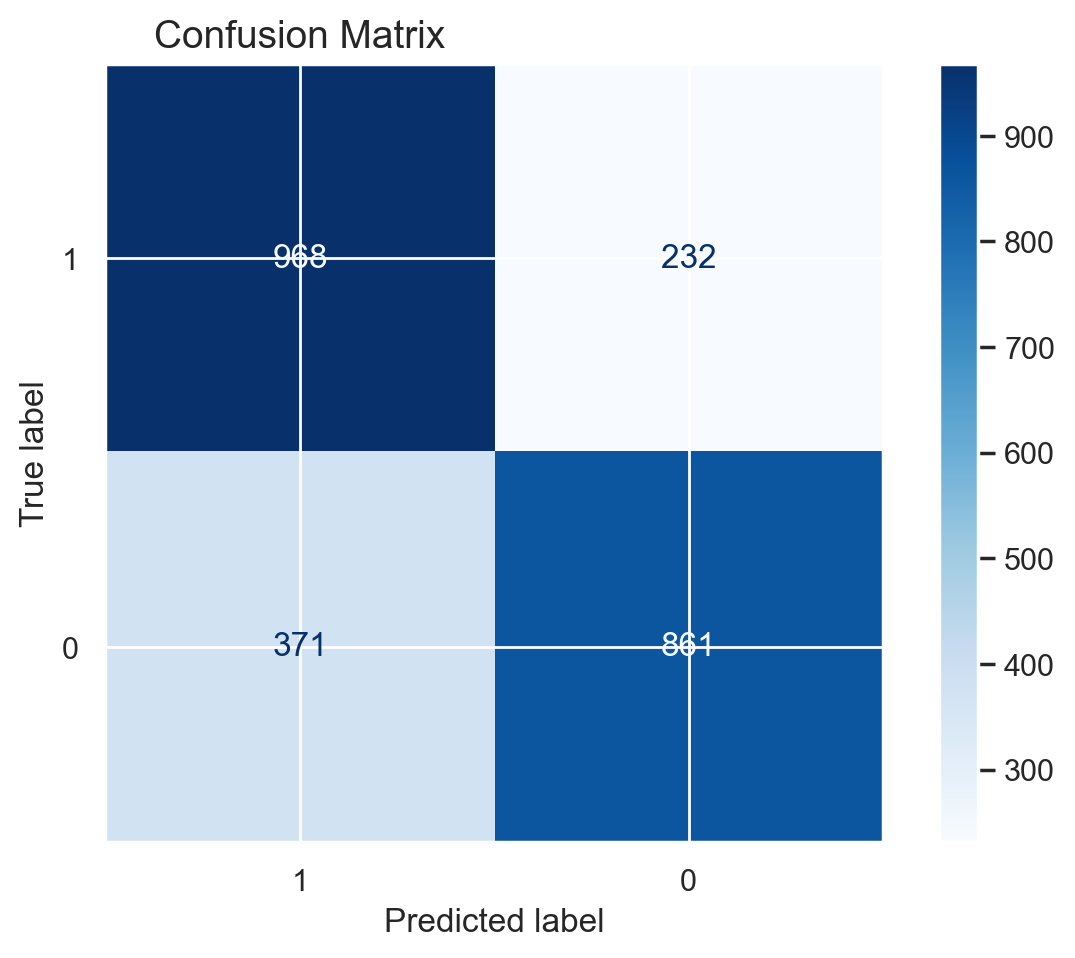

In [322]:
plot_confusion_matrix(rf_best, X_test, y_test, cmap='Blues', labels=[1, 0])
plt.title('Confusion Matrix', x = 0.25, fontsize = 14)
plt.show()

ROC-AUC Curve

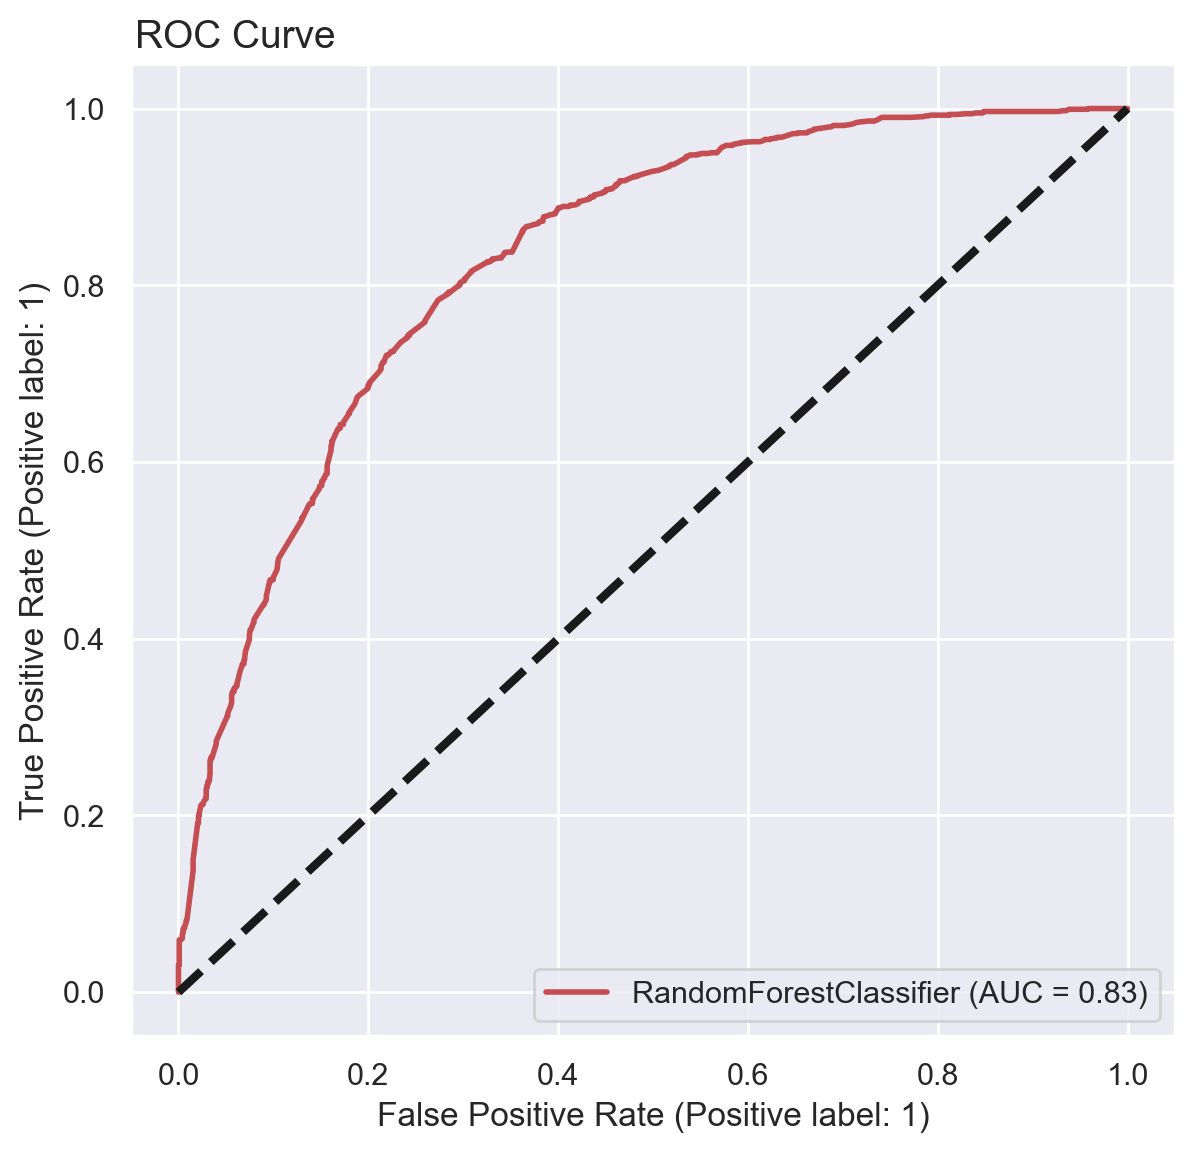

In [323]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_roc_curve(rf_best, X_test, y_test, c='r', lw=2, ax=ax)
plt.title('ROC Curve', x = 0.1, fontsize = 14)
ax.plot([0, 1], [0, 1], 'k--', lw=3)
plt.show()

In [333]:
print('ROC-AUC Score:', roc_auc_score(y_test, rf_best.predict_proba(X_test)[:, 1]))

ROC-AUC Score: 0.828427353896104


Precision-Recall Curve

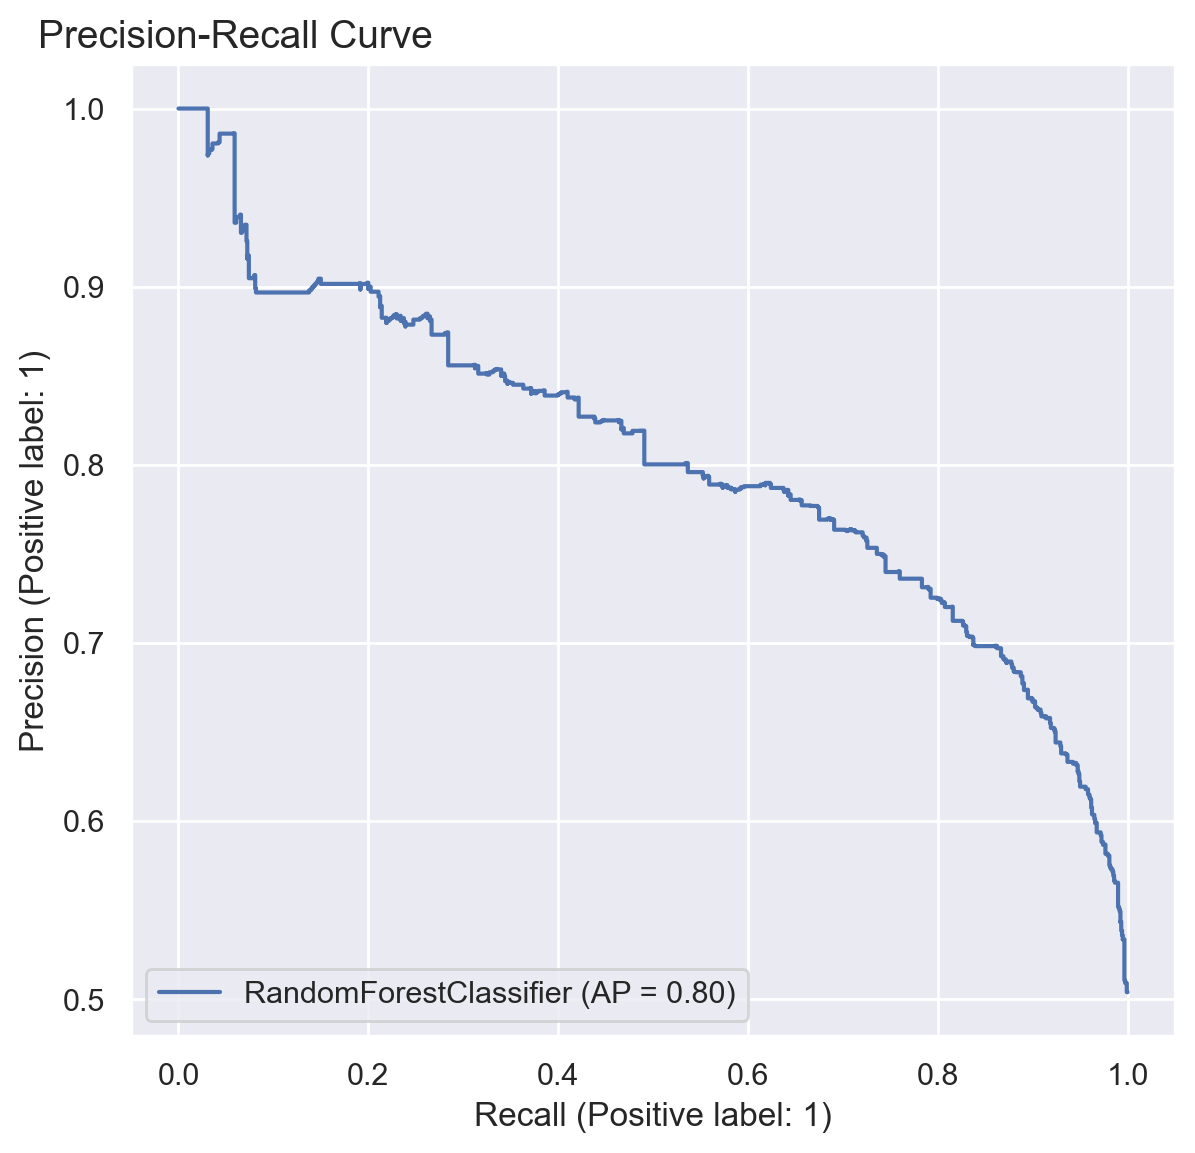

In [334]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_precision_recall_curve(rf_best, X_test, y_test, ax=ax)
plt.title('Precision-Recall Curve', x = 0.1, fontsize = 14)
plt.show()

The f1-score is balanced between the two classes, and the accuracy of the model is fairly good.  
The area under the curve is **0.83**, which tells us that this model has a good class separation capacity.  
The precision-recall curve shows the tradeoff between precision and recall for different threshold; here the PR-AUC is **0.78**, the curve descends in a typical non-monotonic fashion, and the precision decreases significantly at **0.75** when recall is around **0.7**.  
<br/><br/>

#### Model Scores Evaluation

In [325]:
models_2 = pd.concat([new_logreg_df, new_dt_df, new_rf_df], axis = 1)
models_2

Logistic Reg  Decision Tree  Random Forest
train      0.739873       0.759819       0.755706
test       0.742599       0.740543       0.752056
cv         0.734212       0.733496       0.738225

In the three models implemented above, **Random Forest** achieved the highest CV score of **0.7382**  

The most important features for this model were **title_engineer**, **title_senior** and **title_director**. According to the Random Forest Classifier, upper level positions and engineering related jobs have the biggest impact in predicting job salaries.

Although the Random Forest Classifer performed the best, all the three model scores were quite close to one another, and were about 0.23 higher than the baseline of 0.5 indicating that the models made substantially better predictions.  
Since these models did significantly better than the previous models that relied only on location, it can be concluded that factors such as job titles and roles can affect the salary level.  
<br/><br/>

### Model evaluation:

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs.


- Use cross-validation to evaluate your models.
- Evaluate the accuracy, AUC, precision and recall of the models.
- Plot the ROC and precision-recall curves for at least one of your models.

In [15]:
## YOUR CODE HERE

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### Bonus:

- Answer the salary discussion by using your model to explain the tradeoffs between detecting high vs low salary positions. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.
- Obtain the ROC/precision-recall curves for the different models you studied (at least the tuned model of each category) and compare.

In [16]:
## YOUR CODE HERE

### Summarize your results in an executive summary written for a non-technical audience.
   
- Writeups should be at least 500-1000 words, defining any technical terms, explaining your approach, as well as any risks and limitations.

In [17]:
## YOUR TEXT HERE IN MARKDOWN FORMAT 

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### BONUS

Convert your executive summary into a public blog post of at least 500 words, in which you document your approach in a tutorial for other aspiring data scientists. Link to this in your notebook.

In [18]:
## YOUR LINK HERE IN MARKDOWN FORMAT 